# Classifying Confusion with RNN

This notebook holds our confusion classification pipeline for various RNN architectures. Experiments occur with no data augmentation.


In [1]:
import pickle
import os
import random
import shutil

import numpy as np

import torch
from torch import nn
from torch import utils
from torch import autograd
from torchvision import datasets

from utils import pickle_loader
from utils import plot_metrics
from utils import get_train_val_split
from utils import check_metrics

from train import train

MANUAL_SEED = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


MAX_SEQUENCE_LENGTH = 150
INPUT_SIZE = 14
HIDDEN_SIZE = 256
OUTPUT_SIZE = 2
BATCH_SIZE = 256

## RNN model classes

In [ ]:
class ConfusionRNN(nn.Module):
    """
        Basic/Vanilla RNN.
    """
    def __init__(self, input_size, hidden_size, output_size, batch_size, num_layers=1):
        super(ConfusionRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(1)

    def forward(self, inputs, hidden):
        # change input shape to (max_seq_size,batch_size,input_features):
        inputs = inputs.permute(1, 0, 2)
        output, hidden = self.rnn(inputs, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self, batch_size):
        """ Initializes the hidden state with zero tensors.
        """
        return autograd.Variable(torch.zeros(self.num_layers, batch_size,
                                             self.hidden_size, device=DEVICE))

class ConfusionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size, num_layers=1):
        super(ConfusionLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(1)


    def forward(self, inputs, hidden):
        # change input shape to (max_seq_size,batch_size,input_features):
        inputs = inputs.permute(1, 0, 2)
        output, hidden = self.lstm(inputs, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self, batch_size):
        """ Initializes the hidden state and cell state with zero tensors.
        """
        return (autograd.Variable(torch.zeros(self.num_layers, batch_size,
                                              self.hidden_size, device=DEVICE)),
                autograd.Variable(torch.zeros(self.num_layers, batch_size,
                                              self.hidden_size, device=DEVICE)))

class ConfusionGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size, num_layers=1):
        super(ConfusionGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(1)


    def forward(self, inputs, hidden):
        # change input shape to (max_seq_size,batch_size,input_features):
        inputs = inputs.permute(1, 0, 2)
        output, hidden = self.gru(inputs, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self, batch_size):
        """ Initializes the hidden state with zero tensors.
        """
        return autograd.Variable(torch.zeros(self.num_layers, batch_size,
                                             self.hidden_size, device=DEVICE))

## Cross Validation

### The following cell implements 10-fold CV.

In [8]:
def cross_validate(model_type,
                   folds,
                   epochs,
                   criterion_type,
                   optimizer_type,
                   confused_path,
                   not_confused_path,
                   print_every,
                   plot_every,
                   hidden_size,
                   num_layers,
                   down_sample_training=True,
                   early_stopping=False,
                   early_stopping_metric='val_loss',
                   early_stopping_patience=10,
                   rate_decay=False,
                   rate_decay_patience=5,
                   initial_learning_rate=0.003,
                   verbose=False):
    """
        Perform Cross Validation on the model with k-folds. Use test set for
        final model evaluation in each fold.

        Args:
            model_type (string): the type of RNN to use. Must be 'lstm' or 'gru'
            folds: value of k for k-fold CV
            epochs (int): the max number of epochs to train the model for each fold
            criterion_type (string): the name loss function to use for training.
            optimizer_type (string): the name of learning algorithm to use for training.
            confused_path (string): the path to the folder containing the
                confused data samples
            not_confused_path (string): the path to the folder containing the
                not_confused data samples
            print_every (int): the number of batches to train for before
                printing relevant stats
            plot_every (int): the number of batches to train for before
                recording relevant stats, which will be plotted after each fold
            hidden_size (int): number of hidden units in each RNN layer
            num_layers (int): number of layers in the RNN
            down_sample_training (boolean): if True, not_confused items are
                randomly downsampled to match the number of confused
            early_stopping (boolean): if True, training will stop after
                early_stopping_patience epochs without improvement
            early_stopping_patience (int): number of epochs without improvement
                that can pass before training is stopped
            rate_decay (boolean): if True, learning rate will decrease by half
                each rate_decay_patience epochs without improvement
            rate_decay_patience (int): number of epochs without improvement
                before reducing learning rate
            initial_learning_rate (float): the first and highest rate used
            verbose (boolean): if True, function will print additional stats

        Returns: (list,list,list,list,list,list)
            cv_val_accs (list): list containing the validation accuracy for each fold
            cv_val_sensis (list): list containing the validation sensitivity for each fold
            cv_val_specifs (list): list containing the validation specificity for each fold
            cv_test_accs (list): list containing the test accuracy for each fold
            cv_test_sensis (list): list containing the test sensitivity for each fold
            cv_test_specifs (list): list containing the test specificity for each fold

    """

    confused_file_names = os.listdir(confused_path)
    not_confused_file_names = os.listdir(not_confused_path)
    if '.DS_Store' in confused_file_names:
        confused_file_names.remove('.DS_Store')
    if '.DS_Store' in not_confused_file_names:
        not_confused_file_names.remove('.DS_Store')

    #ensure same items appear in folds, for reproducibility:
    infile = open('grouped_10_fold_split_list_2.pickle', 'rb')
    split = pickle.load(infile)
    infile.close()

    train_confused_splits = split[0]
    test_confused_splits = split[1]
    train_not_confused_splits = split[2]
    test_not_confused_splits = split[3]


    cv_val_accs = []
    cv_val_sensis = []
    cv_val_specifs = []
    cv_val_aucs = []

    cv_test_accs = []
    cv_test_sensis = []
    cv_test_specifs = []
    cv_test_aucs = []

    for k in range(folds):
        print("\nFold ", k+1)

        # Get data item file names for this fold and downsample not_confused to balance training set

        train_confused, \
        train_not_confused, \
        val_confused, \
        val_not_confused = \
        get_train_val_split(train_confused_splits[k],
                            train_not_confused_splits[k], percent_val_set=0.2)

        if down_sample_training:
            train_not_confused = random.sample(train_not_confused, k=(len(train_confused)))

        test_confused = test_confused_splits[k]
        test_not_confused = test_not_confused_splits[k]

        if verbose:
            print("confused items in training set: ", len(train_confused))
            print("not_confused items in training set: ", len(train_not_confused))
            print("confused items in validation set: ", len(val_confused))
            print("not_confused items in validation set: ", len(val_not_confused))

        if verbose:
            print("\nTest confused items:\n")
            print(test_confused)

        local_train_confused_path = './dataset/augmented/train3-1/confused/'
        local_val_confused_path = './dataset/augmented/val3-1/confused/'
        local_test_confused_path = './dataset/augmented/test3-1/confused/'
        local_train_not_confused_path = './dataset/augmented/train3-1/not_confused/'
        local_val_not_confused_path = './dataset/augmented/val3-1/not_confused/'
        local_test_not_confused_path = './dataset/augmented/test3-1/not_confused/'

        # Remove any old directories
        if os.path.exists(local_train_confused_path):
            shutil.rmtree(local_train_confused_path)
        if os.path.exists(local_val_confused_path):
            shutil.rmtree(local_val_confused_path)
        if os.path.exists(local_test_confused_path):
            shutil.rmtree(local_test_confused_path)

        if os.path.exists(local_train_not_confused_path):
            shutil.rmtree(local_train_not_confused_path)
        if os.path.exists(local_val_not_confused_path):
            shutil.rmtree(local_val_not_confused_path)
        if os.path.exists(local_test_not_confused_path):
            shutil.rmtree(local_test_not_confused_path)

        # Make new temp directories
        os.makedirs(local_train_confused_path)
        for i in train_confused:
            shutil.copy(src=confused_path+i, dst=local_train_confused_path+i)

        os.makedirs(local_val_confused_path)
        for i in val_confused:
            shutil.copy(src=confused_path+i, dst=local_val_confused_path+i)

        os.makedirs(local_test_confused_path)
        for i in test_confused:
            shutil.copy(src=confused_path+i, dst=local_test_confused_path+i)

        os.makedirs(local_train_not_confused_path)
        for i in train_not_confused:
            shutil.copy(src=not_confused_path+i, dst=local_train_not_confused_path+i)

        os.makedirs(local_val_not_confused_path)
        for i in val_not_confused:
            shutil.copy(src=not_confused_path+i, dst=local_val_not_confused_path+i)

        os.makedirs(local_test_not_confused_path)
        for i in test_not_confused:
            shutil.copy(src=not_confused_path+i, dst=local_test_not_confused_path+i)

        # Prepare training and validation data
        training_data = datasets.DatasetFolder('./dataset/augmented/train3-1/',
                                               loader=pickle_loader,
                                               extensions='.pkl')

        training_data_loader = utils.data.DataLoader(training_data,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     num_workers=1 if \
                                                     DEVICE.type == 'cuda' else 5,
                                                     pin_memory=True,
                                                     drop_last=False)

        validation_data = datasets.DatasetFolder('./dataset/augmented/val3-1/',
                                                 loader=pickle_loader,
                                                 extensions='.pkl')

        validation_data_loader = utils.data.DataLoader(validation_data,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False,
                                                       num_workers=1 if \
                                                       DEVICE.type == 'cuda' else 5,
                                                       pin_memory=True,
                                                       drop_last=False)

        test_data = datasets.DatasetFolder('./dataset/augmented/test3-1/',
                                           loader=pickle_loader,
                                           extensions='.pkl')

        test_data_loader = utils.data.DataLoader(test_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=1 if \
                                                 DEVICE.type == 'cuda' else 5,
                                                 pin_memory=True,
                                                 drop_last=False)
        print("Training data: ", training_data)
        print("Validation data: ", validation_data)
        print("Test data: ", test_data)

        torch.manual_seed(MANUAL_SEED)

        if model_type == 'lstm':
            model = ConfusionLSTM(input_size=INPUT_SIZE, hidden_size=hidden_size,
                                  output_size=OUTPUT_SIZE, batch_size=BATCH_SIZE,
                                  num_layers=num_layers)
            if verbose:
                print(model)
        elif model_type == 'gru':
            model = ConfusionGRU(input_size=INPUT_SIZE, hidden_size=hidden_size,
                                 output_size=OUTPUT_SIZE, batch_size=BATCH_SIZE,
                                 num_layers=num_layers)
            if verbose:
                print(model)

        else:
            model = ConfusionRNN(input_size=INPUT_SIZE, hidden_size=hidden_size,
                                 output_size=OUTPUT_SIZE, batch_size=BATCH_SIZE,
                                 num_layers=num_layers)
            if verbose:
                print(model)

        model = model.to(DEVICE)

        #save fresh model to clear any old ones out
        torch.save(model.state_dict(), './'+ 'best_rnn3-1'+'_fold_'+str(k) +'.pt')

        # Train and evaluate for the k'th fold
        model, \
        (training_accs, \
         validation_accs, \
         training_losses, \
         training_aucs, \
         validation_losses, \
         validation_recalls, \
         validation_specifs, \
         validation_aucs, \
         val_thresh) = train(model=model,
                             epochs=epochs,
                             criterion_type=criterion_type,
                             optimizer_type=optimizer_type,
                             train_loader=training_data_loader,
                             val_loader=validation_data_loader,
                             print_every=print_every,
                             plot_every=plot_every,
                             early_stopping=early_stopping,
                             early_stopping_metric=early_stopping_metric,
                             early_stopping_patience=early_stopping_patience,
                             rate_decay=rate_decay,
                             rate_decay_patience=rate_decay_patience,
                             initial_learning_rate=initial_learning_rate,
                             model_name='best_rnn3-1'+'_fold_'+str(k),
                             verbose=True,
                             return_thresh=True)

        plot_metrics(training_accs, training_losses, training_aucs,
                     validation_accs, validation_losses, validation_recalls,
                     validation_specifs, validation_aucs)

        # store metrics for last epoch of the current fold of CV
        cv_val_accs.append(validation_accs[-1])
        cv_val_sensis.append(validation_recalls[-1])
        cv_val_specifs.append(validation_specifs[-1])
        cv_val_aucs.append(validation_aucs[-1])

        test_accuracy, \
        test_recall, \
        test_specificity, \
        test_auc, \
        test_loss = check_metrics(model, test_data_loader)

        cv_test_accs.append(test_accuracy)
        cv_test_sensis.append(test_recall)
        cv_test_specifs.append(test_specificity)
        cv_test_aucs.append(test_auc)

    #clean up temp directories
    shutil.rmtree(local_val_confused_path)
    shutil.rmtree(local_val_not_confused_path)
    shutil.rmtree(local_train_confused_path)
    shutil.rmtree(local_train_not_confused_path)
    shutil.rmtree(local_test_confused_path)
    shutil.rmtree(local_test_not_confused_path)

    if verbose:
        print("\n%d-fold CV accuracy: %f"% (folds, sum(cv_val_accs)/len(cv_val_accs)))
        print("%d-fold CV sensitivity: %f "% (folds, sum(cv_val_sensis)/len(cv_val_sensis)))
        print("%d-fold CV specificity: %f "% (folds, sum(cv_val_specifs)/len(cv_val_specifs)))
        print("%d-fold CV AUC: %f "% (folds, sum(cv_val_aucs)/len(cv_val_aucs)))
        print("\n%d-fold test accuracy: %f"% (folds, sum(cv_test_accs)/len(cv_test_accs)))
        print("%d-fold test sensitivity: %f "% (folds, sum(cv_test_sensis)/len(cv_test_sensis)))
        print("%d-fold test specificity: %f "% (folds, sum(cv_test_specifs)/len(cv_test_specifs)))
        print("%d-fold test AUC: %f "% (folds, sum(cv_test_aucs)/len(cv_test_aucs)))
    return cv_val_accs, cv_val_sensis, cv_val_specifs, cv_val_aucs, \
            cv_test_accs, cv_test_sensis, cv_test_specifs, cv_test_aucs


Fold  1
confused items in training set:  220
not_confused items in training set:  220
confused items in validation set:  64
not_confused items in validation set:  2172

Test confused items:

['131a_H-CDV-5-1.pkl', '131a_H-CDV-5-2.pkl', '131a_H-CDV-5-3.pkl', '131a_H-CDV-5-4.pkl', '131a_H-SortTwoFactors-12-1.pkl', '131a_H-SortTwoFactors-12-2.pkl', '131a_H-SortTwoFactors-12-3.pkl', '131a_H-SortTwoFactors-12-4.pkl', '131b_V-SortTwoFactors-21-1.pkl', '131b_V-SortTwoFactors-21-2.pkl', '131b_V-SortTwoFactors-21-3.pkl', '131b_V-SortTwoFactors-21-4.pkl', '132a_V-CDV-2-1.pkl', '132a_V-CDV-2-2.pkl', '132a_V-CDV-2-3.pkl', '132a_V-CDV-2-4.pkl', '132a_V-SortOverall-21-1.pkl', '132a_V-SortOverall-21-2.pkl', '132a_V-SortOverall-21-3.pkl', '132a_V-SortOverall-21-4.pkl', '132a_V-SortOverall-9-1.pkl', '132a_V-SortOverall-9-2.pkl', '132a_V-SortOverall-9-3.pkl', '132a_V-SortOverall-9-4.pkl', '132a_V-SortTwoFactors-6-1.pkl', '132a_V-SortTwoFactors-6-2.pkl', '132a_V-SortTwoFactors-6-3.pkl', '132a_V-SortTwoF

[epoch: 14, batches:     1] loss: 0.46876 | accuracy: 0.76562
[epoch: 14, batches:     2] loss: 0.47430 | accuracy: 0.74457
Training accuracy for epoch:  0.7550951086956521
validation accuracy:  0.5138640429338104
validation loss:  0.6059357954396142
validation recall:  0.65625
validation specificity:  0.5096685082872928
validation AUC:  0.5463210750460404
Epochs without improvement:  1
[epoch: 15, batches:     1] loss: 0.46630 | accuracy: 0.77344
[epoch: 15, batches:     2] loss: 0.47171 | accuracy: 0.75543
Training accuracy for epoch:  0.7644361413043479
validation accuracy:  0.6650268336314848
validation loss:  0.6102108359336853
validation recall:  0.484375
validation specificity:  0.6703499079189686
validation AUC:  0.5566801910681399
Old best AUC:  0.5561190722836095
New best SUC:  0.5566801910681399
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 16, batches:     1] loss: 0.46435 | accuracy: 0.76172
[epoch: 16, batches:     2] loss: 0.46604 | accuracy: 0

[epoch: 34, batches:     2] loss: 0.44261 | accuracy: 0.76630
Training accuracy for epoch:  0.7815896739130435
validation accuracy:  0.5585867620751341
validation loss:  0.6124523745642768
validation recall:  0.59375
validation specificity:  0.5575506445672191
validation AUC:  0.5450621546961325
Epochs without improvement:  18
[epoch: 35, batches:     1] loss: 0.43734 | accuracy: 0.79297
[epoch: 35, batches:     2] loss: 0.42453 | accuracy: 0.77174
Training accuracy for epoch:  0.7823539402173914
validation accuracy:  0.5129695885509838
validation loss:  0.5997180640697479
validation recall:  0.609375
validation specificity:  0.5101289134438306
validation AUC:  0.547544026243094
Epochs without improvement:  19
[epoch: 36, batches:     1] loss: 0.42644 | accuracy: 0.78516
[epoch: 36, batches:     2] loss: 0.42222 | accuracy: 0.78261
Training accuracy for epoch:  0.7838824728260869
validation accuracy:  0.5559033989266547
validation loss:  0.5750767091910044
validation recall:  0.5625
va

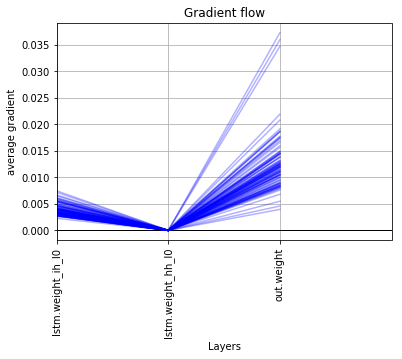

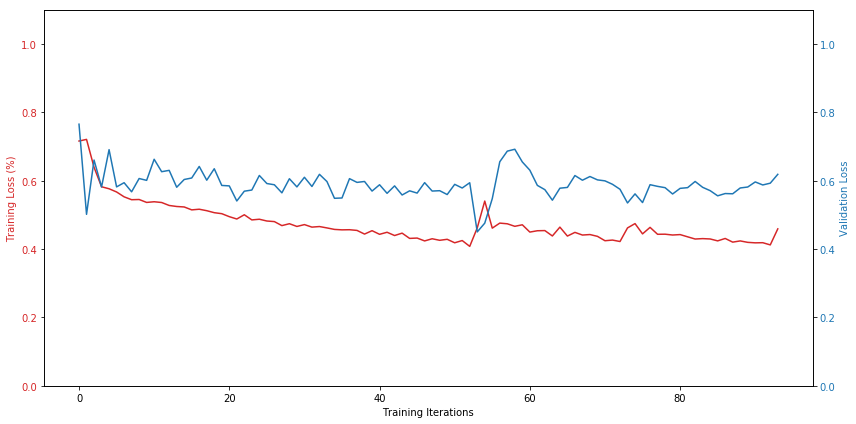

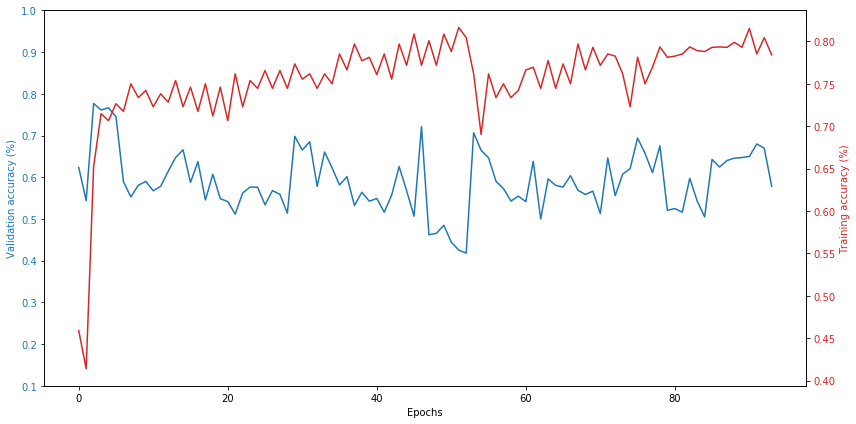

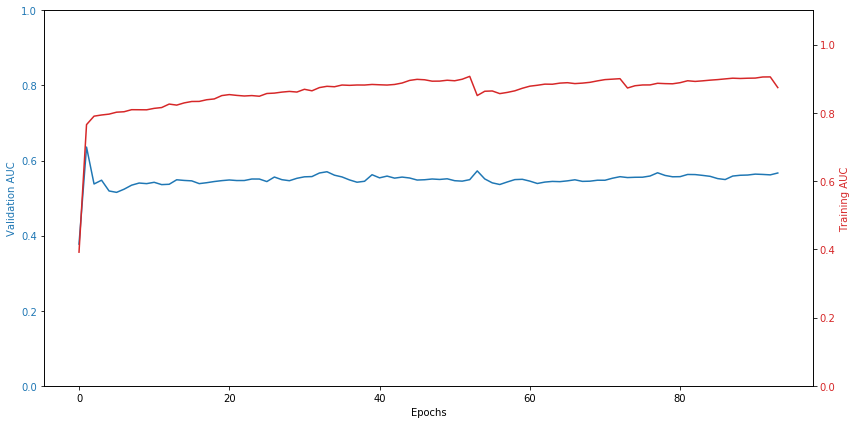

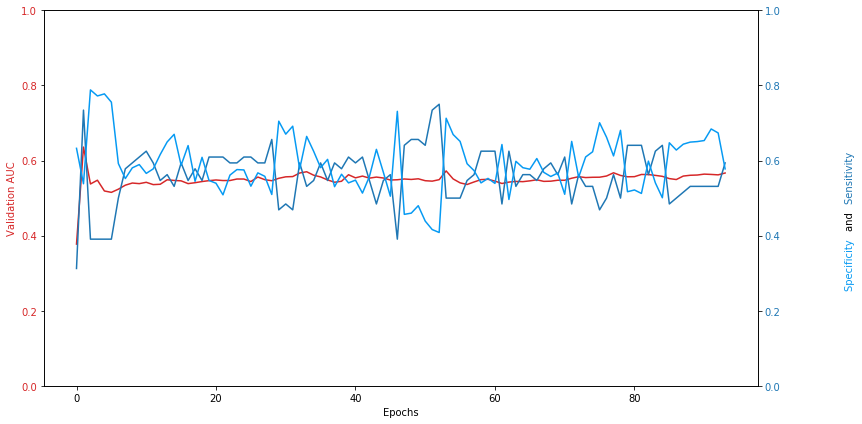


Fold  2
confused items in training set:  224
not_confused items in training set:  224
confused items in validation set:  84
not_confused items in validation set:  2336

Test confused items:

['126a_V-SortTwoFactors-6-1.pkl', '126a_V-SortTwoFactors-6-2.pkl', '126a_V-SortTwoFactors-6-3.pkl', '126a_V-SortTwoFactors-6-4.pkl', '133a_H-CDV-16-1.pkl', '133a_H-CDV-16-2.pkl', '133a_H-CDV-16-3.pkl', '133a_H-CDV-16-4.pkl', '1b_V-CDV-17-1.pkl', '1b_V-CDV-17-2.pkl', '1b_V-CDV-17-3.pkl', '1b_V-CDV-17-4.pkl', '36a_V-SortTwoFactors-2-1.pkl', '36a_V-SortTwoFactors-2-2.pkl', '36a_V-SortTwoFactors-2-3.pkl', '36a_V-SortTwoFactors-2-4.pkl', '48a_V-SortTwoFactors-12-1.pkl', '48a_V-SortTwoFactors-12-2.pkl', '48a_V-SortTwoFactors-12-3.pkl', '48a_V-SortTwoFactors-12-4.pkl', '63a_H-SortTwoFactors-5-1.pkl', '63a_H-SortTwoFactors-5-2.pkl', '63a_H-SortTwoFactors-5-3.pkl', '63a_H-SortTwoFactors-5-4.pkl', '8a_V-SortTwoFactors-10-1.pkl', '8a_V-SortTwoFactors-10-2.pkl', '8a_V-SortTwoFactors-10-3.pkl', '8a_V-SortTwoFa

[epoch: 15, batches:     1] loss: 0.53044 | accuracy: 0.75781
[epoch: 15, batches:     2] loss: 0.54159 | accuracy: 0.73438
Training accuracy for epoch:  0.74609375
validation accuracy:  0.6566115702479339
validation loss:  0.5829841494560242
validation recall:  0.7261904761904762
validation specificity:  0.6541095890410958
validation AUC:  0.7457497553816047
Epochs without improvement:  5
[epoch: 16, batches:     1] loss: 0.52655 | accuracy: 0.73047
[epoch: 16, batches:     2] loss: 0.53308 | accuracy: 0.71875
Training accuracy for epoch:  0.724609375
validation accuracy:  0.7586776859504132
validation loss:  0.5518805593252182
validation recall:  0.6071428571428571
validation specificity:  0.7641267123287672
validation AUC:  0.7294673434442269
Epochs without improvement:  6
[epoch: 17, batches:     1] loss: 0.52022 | accuracy: 0.75000
[epoch: 17, batches:     2] loss: 0.53077 | accuracy: 0.71875
Training accuracy for epoch:  0.734375
validation accuracy:  0.7805785123966942
validatio

[epoch: 35, batches:     1] loss: 0.52229 | accuracy: 0.74219
[epoch: 35, batches:     2] loss: 0.52359 | accuracy: 0.73958
Training accuracy for epoch:  0.7408854166666667
validation accuracy:  0.7520661157024794
validation loss:  0.5525694608688354
validation recall:  0.6666666666666666
validation specificity:  0.7551369863013698
validation AUC:  0.7454745596868884
Epochs without improvement:  25
[epoch: 36, batches:     1] loss: 0.51397 | accuracy: 0.73828
[epoch: 36, batches:     2] loss: 0.52282 | accuracy: 0.71875
Training accuracy for epoch:  0.728515625
validation accuracy:  0.8194214876033058
validation loss:  0.5412463515996933
validation recall:  0.6428571428571429
validation specificity:  0.8257705479452054
validation AUC:  0.7452452299412916
Epochs without improvement:  26
[epoch: 37, batches:     1] loss: 0.51034 | accuracy: 0.72656
[epoch: 37, batches:     2] loss: 0.51676 | accuracy: 0.72917
Training accuracy for epoch:  0.7278645833333333
validation accuracy:  0.742561

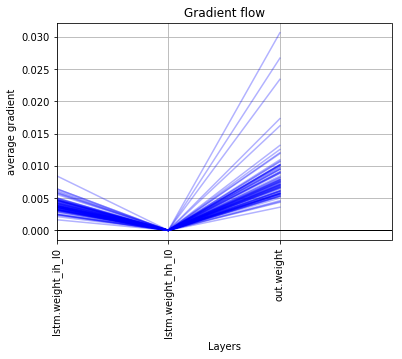

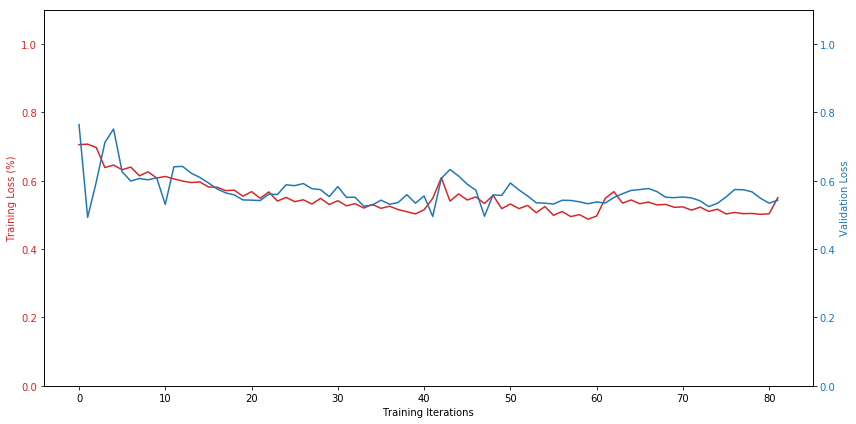

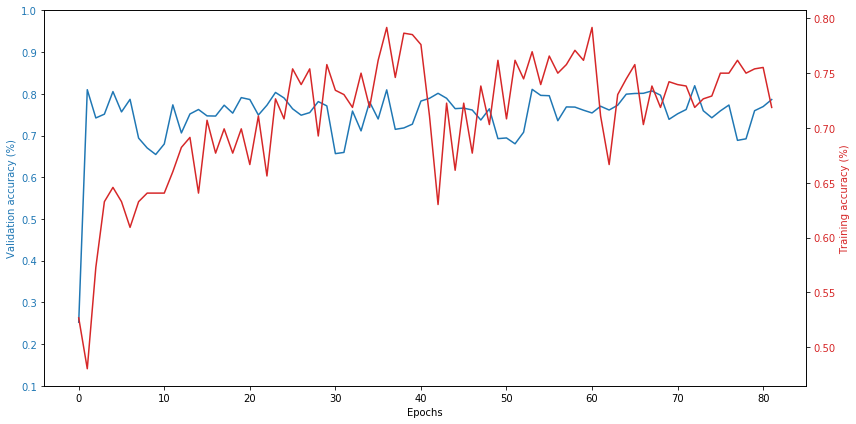

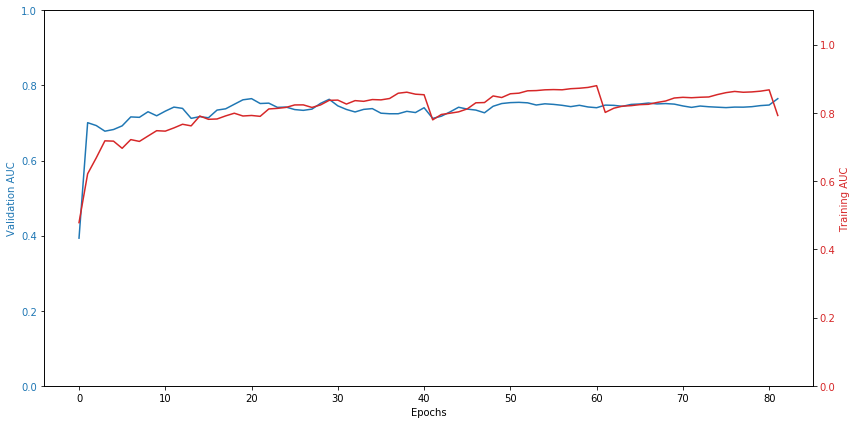

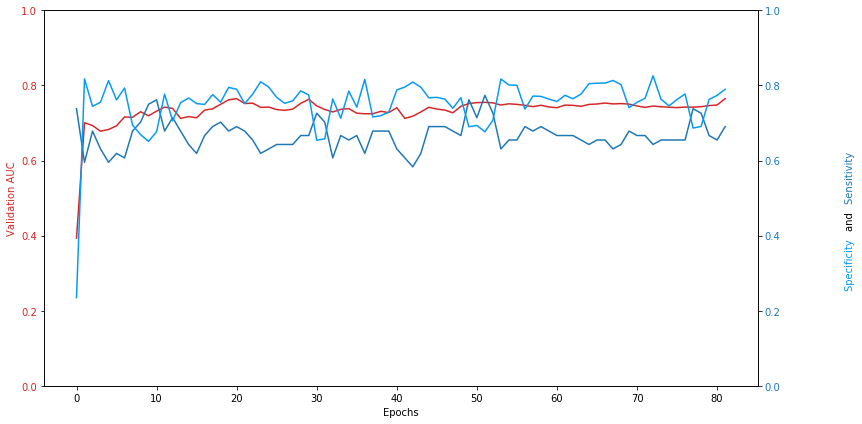


Fold  3
confused items in training set:  236
not_confused items in training set:  236
confused items in validation set:  64
not_confused items in validation set:  2244

Test confused items:

['111a_H-SortTwoFactors-3-1.pkl', '111a_H-SortTwoFactors-3-2.pkl', '111a_H-SortTwoFactors-3-3.pkl', '111a_H-SortTwoFactors-3-4.pkl', '137a_H-FE-4-1.pkl', '137a_H-FE-4-2.pkl', '137a_H-FE-4-3.pkl', '137a_H-FE-4-4.pkl', '137a_H-SortTwoFactors-2-1.pkl', '137a_H-SortTwoFactors-2-2.pkl', '137a_H-SortTwoFactors-2-3.pkl', '137a_H-SortTwoFactors-2-4.pkl', '137b_V-FE-20-1.pkl', '137b_V-FE-20-2.pkl', '137b_V-FE-20-3.pkl', '137b_V-FE-20-4.pkl', '145b_V-SortTwoFactors-10-1.pkl', '145b_V-SortTwoFactors-10-2.pkl', '145b_V-SortTwoFactors-10-3.pkl', '145b_V-SortTwoFactors-10-4.pkl', '145b_V-SortTwoFactors-24-1.pkl', '145b_V-SortTwoFactors-24-2.pkl', '145b_V-SortTwoFactors-24-3.pkl', '145b_V-SortTwoFactors-24-4.pkl', '14a_V-SortTwoFactors-3-1.pkl', '14a_V-SortTwoFactors-3-2.pkl', '14a_V-SortTwoFactors-3-3.pkl', '14

[epoch: 15, batches:     1] loss: 0.53187 | accuracy: 0.75781
[epoch: 15, batches:     2] loss: 0.53555 | accuracy: 0.71759
Training accuracy for epoch:  0.7377025462962963
validation accuracy:  0.6824090121317158
validation loss:  0.5783529788255691
validation recall:  0.609375
validation specificity:  0.6844919786096256
validation AUC:  0.6389260249554366
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.003
New learning rate: 0.0015
Validation AUC:  0.6749039104278075
Validation Loss:  0.5778014838695527
Epochs without improvement:  10
[epoch: 16, batches:     1] loss: 0.58385 | accuracy: 0.68359
[epoch: 16, batches:     2] loss: 0.61094 | accuracy: 0.64352
Training accuracy for epoch:  0.6635561342592593
validation accuracy:  0.6785095320623917
validation loss:  0.6011227905750275
validation recall:  0.65625
validation specificity:  0.679144385026738
validation AUC:  0.6577261586452763
Epochs without improvement:  11
[epoch: 17, batches:

[epoch: 35, batches:     1] loss: 0.52325 | accuracy: 0.75781
[epoch: 35, batches:     2] loss: 0.53423 | accuracy: 0.73611
Training accuracy for epoch:  0.7469618055555556
validation accuracy:  0.7946273830155979
validation loss:  0.5582648456096649
validation recall:  0.59375
validation specificity:  0.8003565062388592
validation AUC:  0.6509302584670232
No decrease in validation loss in 30 epochs. Stopping training early.
Finished Training
validation accuracy:  0.7361351819757366
validation loss:  0.5778014838695527
validation recall:  0.671875
validation specificity:  0.7379679144385026
validation AUC:  0.6749039104278075


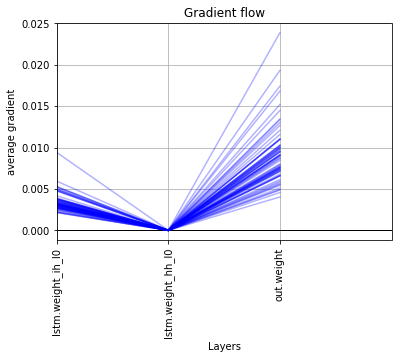

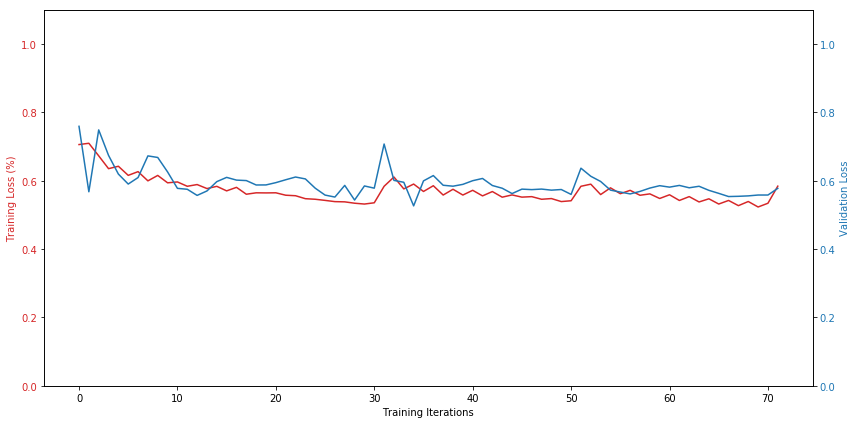

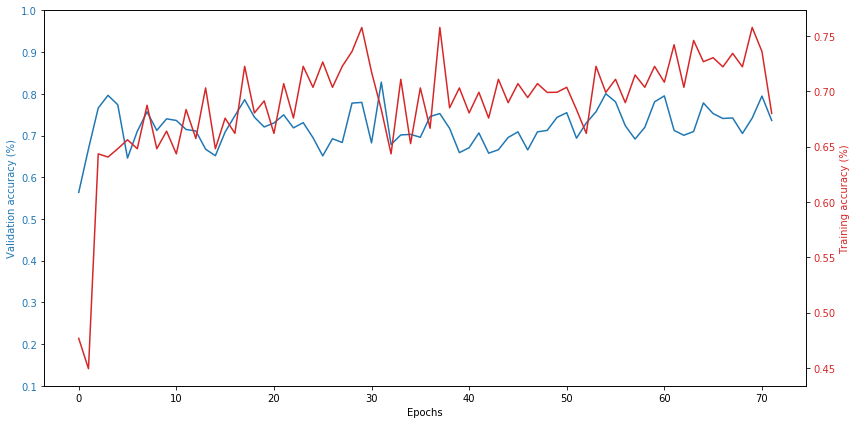

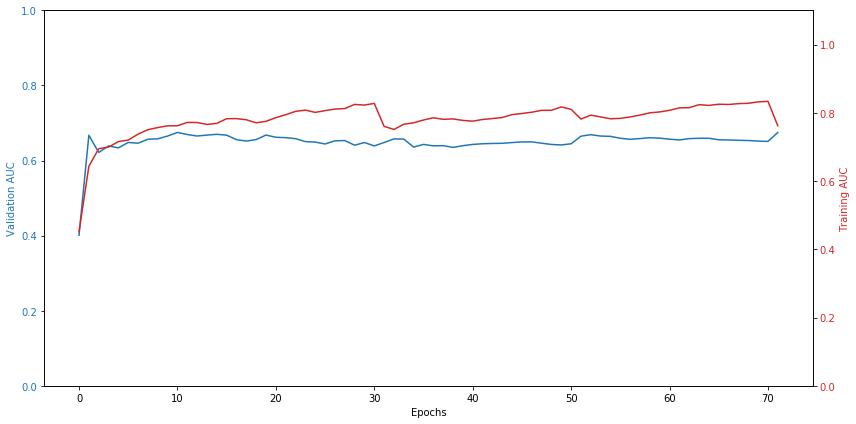

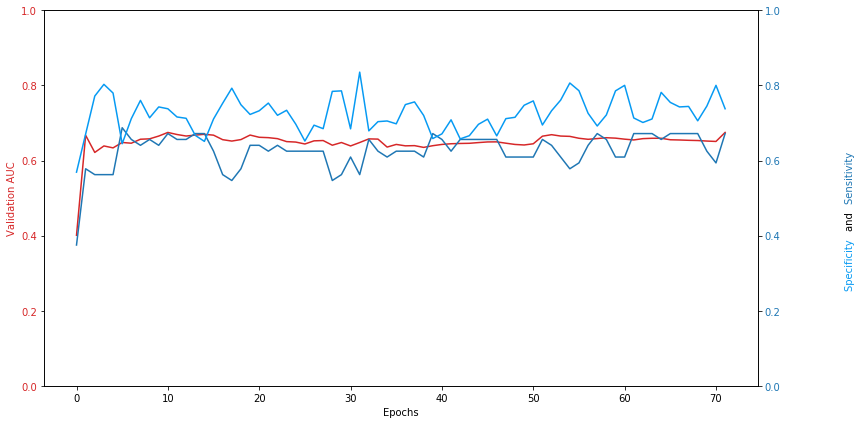


Fold  4
confused items in training set:  248
not_confused items in training set:  248
confused items in validation set:  68
not_confused items in validation set:  2244

Test confused items:

['58a_V-SortTwoFactors-14-1.pkl', '58a_V-SortTwoFactors-14-2.pkl', '58a_V-SortTwoFactors-14-3.pkl', '58a_V-SortTwoFactors-14-4.pkl', '58a_V-SortTwoFactors-23-1.pkl', '58a_V-SortTwoFactors-23-2.pkl', '58a_V-SortTwoFactors-23-3.pkl', '58a_V-SortTwoFactors-23-4.pkl', '58a_V-SortTwoFactors-6-1.pkl', '58a_V-SortTwoFactors-6-2.pkl', '58a_V-SortTwoFactors-6-3.pkl', '58a_V-SortTwoFactors-6-4.pkl', '86a_V-FE-10-1.pkl', '86a_V-FE-10-2.pkl', '86a_V-FE-10-3.pkl', '86a_V-FE-10-4.pkl', '86a_V-SortTwoFactors-4-1.pkl', '86a_V-SortTwoFactors-4-2.pkl', '86a_V-SortTwoFactors-4-3.pkl', '86a_V-SortTwoFactors-4-4.pkl', '86b_H-CDV-6-1.pkl', '86b_H-CDV-6-2.pkl', '86b_H-CDV-6-3.pkl', '86b_H-CDV-6-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 496
    Root Location: ./dataset/augmented/train3-1/
  

[epoch: 17, batches:     1] loss: 0.56319 | accuracy: 0.65625
[epoch: 17, batches:     2] loss: 0.54313 | accuracy: 0.70000
Training accuracy for epoch:  0.678125
validation accuracy:  0.7179930795847751
validation loss:  0.5893036842346191
validation recall:  0.39705882352941174
validation specificity:  0.7277183600713012
validation AUC:  0.5224716892104435
Epochs without improvement:  16
[epoch: 18, batches:     1] loss: 0.54807 | accuracy: 0.74609
[epoch: 18, batches:     2] loss: 0.53150 | accuracy: 0.76250
Training accuracy for epoch:  0.754296875
validation accuracy:  0.7681660899653979
validation loss:  0.591641652584076
validation recall:  0.36764705882352944
validation specificity:  0.7803030303030303
validation AUC:  0.5108131487889274
Epochs without improvement:  17
[epoch: 19, batches:     1] loss: 0.54372 | accuracy: 0.75781
[epoch: 19, batches:     2] loss: 0.52556 | accuracy: 0.71250
Training accuracy for epoch:  0.73515625
validation accuracy:  0.71280276816609
validati

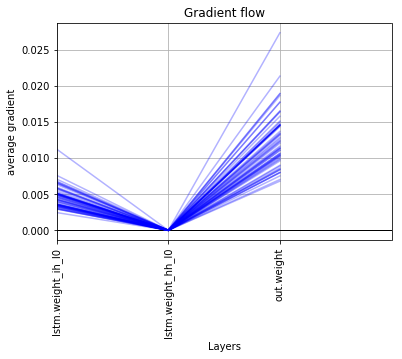

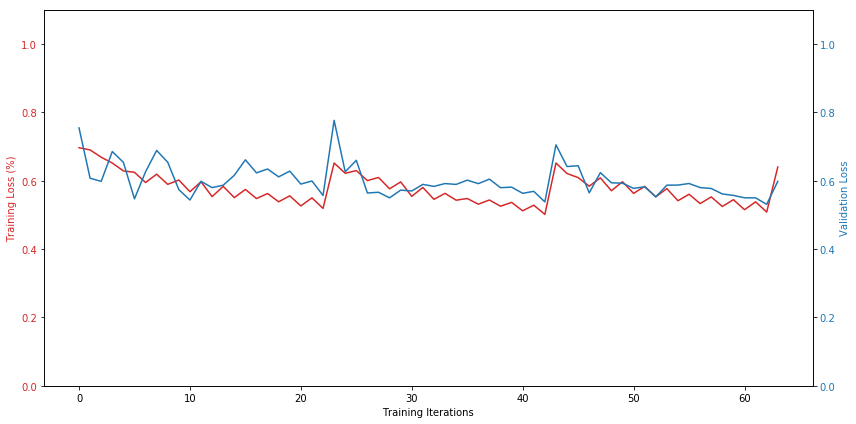

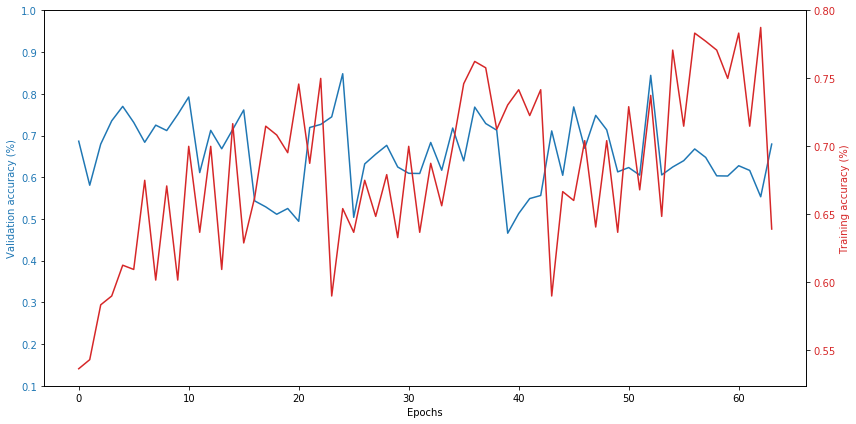

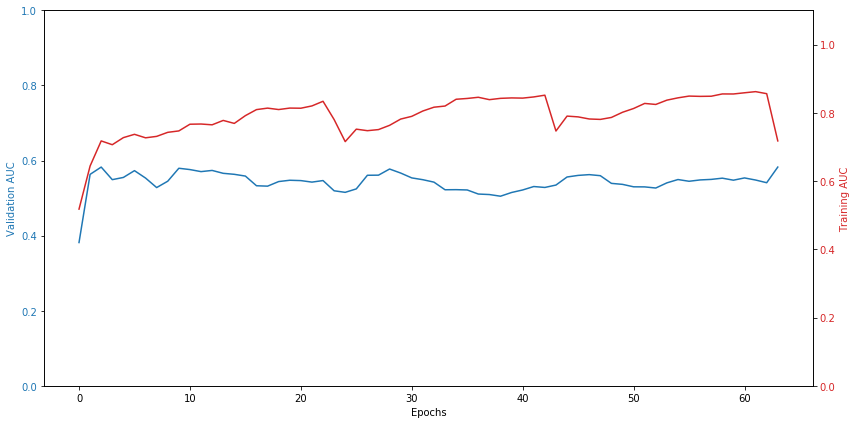

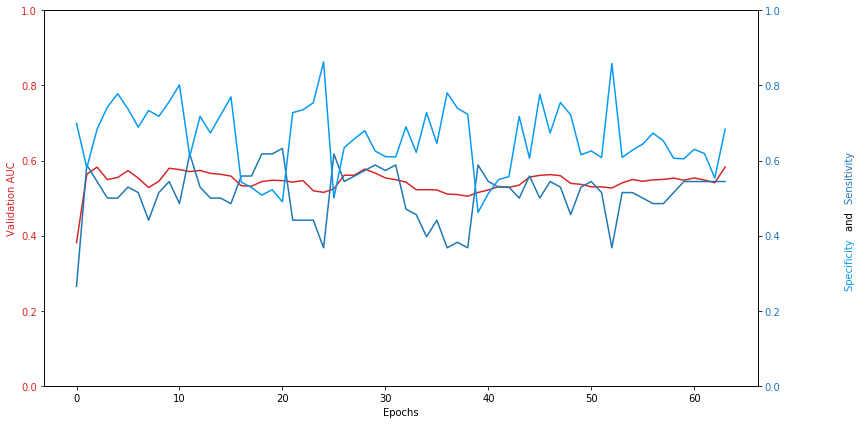


Fold  5
confused items in training set:  220
not_confused items in training set:  220
confused items in validation set:  96
not_confused items in validation set:  2196

Test confused items:

['122a_V-SortTwoFactors-4-1.pkl', '122a_V-SortTwoFactors-4-2.pkl', '122a_V-SortTwoFactors-4-3.pkl', '122a_V-SortTwoFactors-4-4.pkl', '142a_V-CDV-15-1.pkl', '142a_V-CDV-15-2.pkl', '142a_V-CDV-15-3.pkl', '142a_V-CDV-15-4.pkl', '142b_H-CDV-22-1.pkl', '142b_H-CDV-22-2.pkl', '142b_H-CDV-22-3.pkl', '142b_H-CDV-22-4.pkl', '25a_H-RV-22-1.pkl', '25a_H-RV-22-2.pkl', '25a_H-RV-22-3.pkl', '25a_H-RV-22-4.pkl', '32a_V-SortTwoFactors-11-1.pkl', '32a_V-SortTwoFactors-11-2.pkl', '32a_V-SortTwoFactors-11-3.pkl', '32a_V-SortTwoFactors-11-4.pkl', '82a_V-SortTwoFactors-4-1.pkl', '82a_V-SortTwoFactors-4-2.pkl', '82a_V-SortTwoFactors-4-3.pkl', '82a_V-SortTwoFactors-4-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 440
    Root Location: ./dataset/augmented/train3-1/
    Transforms (if any): None


[epoch: 17, batches:     1] loss: 0.58050 | accuracy: 0.66406
[epoch: 17, batches:     2] loss: 0.55521 | accuracy: 0.72826
Training accuracy for epoch:  0.6961616847826086
validation accuracy:  0.6605584642233857
validation loss:  0.5957607494460212
validation recall:  0.6770833333333334
validation specificity:  0.6598360655737705
validation AUC:  0.680621964177292
Old best AUC:  0.6773015330904675
New best SUC:  0.680621964177292
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 18, batches:     1] loss: 0.57304 | accuracy: 0.67578
[epoch: 18, batches:     2] loss: 0.54457 | accuracy: 0.73913
Training accuracy for epoch:  0.7074558423913043
validation accuracy:  0.6740837696335078
validation loss:  0.6199471685621474
validation recall:  0.6041666666666666
validation specificity:  0.6771402550091075
validation AUC:  0.6692992941712204
Epochs without improvement:  1
[epoch: 19, batches:     1] loss: 0.56737 | accuracy: 0.69531
[epoch: 19, batches:     2] loss: 0.

[epoch: 37, batches:     1] loss: 0.50966 | accuracy: 0.73047
[epoch: 37, batches:     2] loss: 0.48161 | accuracy: 0.78804
Training accuracy for epoch:  0.7592561141304348
validation accuracy:  0.6282722513089005
validation loss:  0.565302163362503
validation recall:  0.625
validation specificity:  0.6284153005464481
validation AUC:  0.6582896933819065
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.00075
New learning rate: 0.000375
Validation AUC:  0.680621964177292
Validation Loss:  0.5957607494460212
Epochs without improvement:  20
[epoch: 38, batches:     1] loss: 0.57304 | accuracy: 0.67578
[epoch: 38, batches:     2] loss: 0.54623 | accuracy: 0.74457
Training accuracy for epoch:  0.7101732336956521
validation accuracy:  0.6527050610820244
validation loss:  0.5794174141354032
validation recall:  0.6354166666666666
validation specificity:  0.6534608378870674
validation AUC:  0.6763860428051001
Epochs without improvement:  21
[epoch: 3

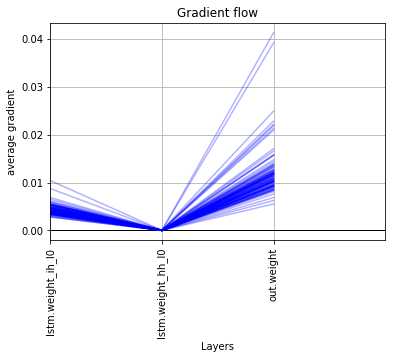

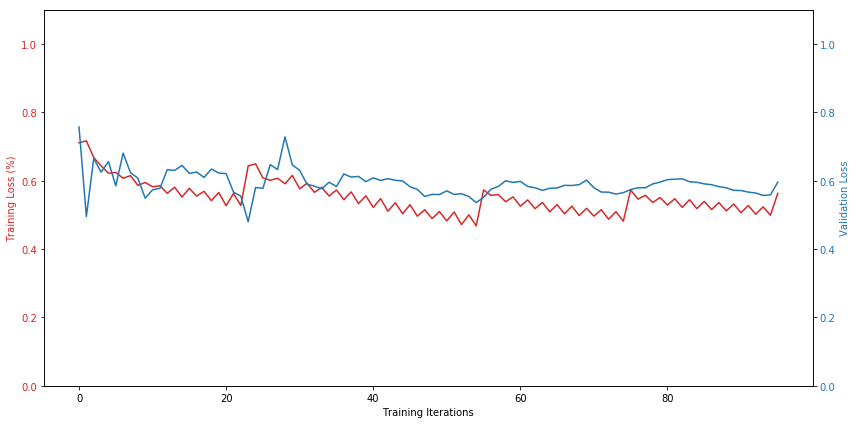

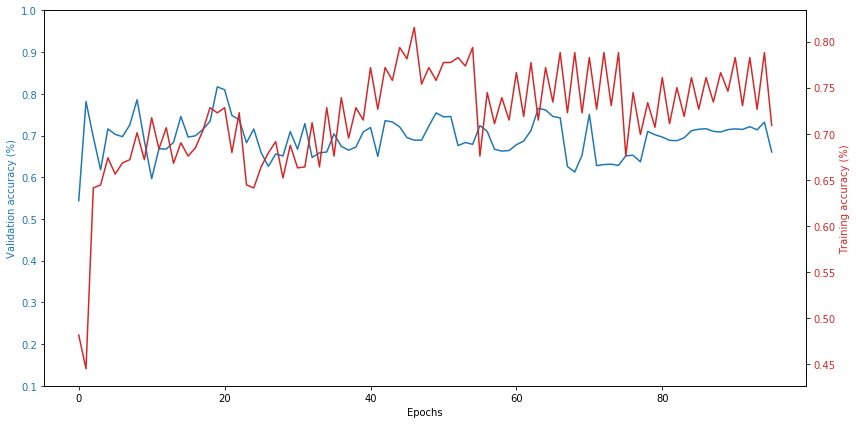

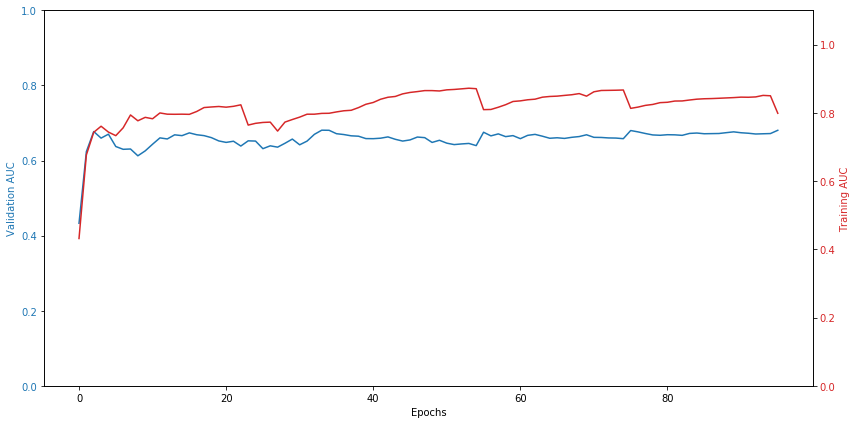

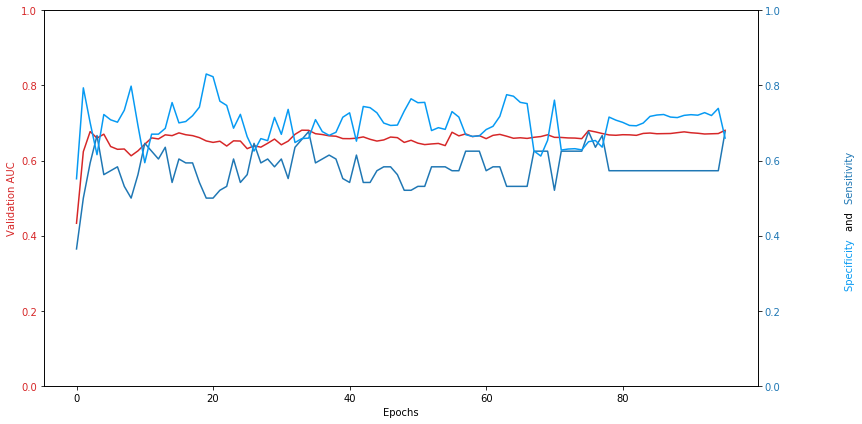


Fold  6
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  84
not_confused items in validation set:  2164

Test confused items:

['10a_V-CDV-2-1.pkl', '10a_V-CDV-2-2.pkl', '10a_V-CDV-2-3.pkl', '10a_V-CDV-2-4.pkl', '12b_H-CDV-5-1.pkl', '12b_H-CDV-5-2.pkl', '12b_H-CDV-5-3.pkl', '12b_H-CDV-5-4.pkl', '3a_H-SortTwoFactors-11-1.pkl', '3a_H-SortTwoFactors-11-2.pkl', '3a_H-SortTwoFactors-11-3.pkl', '3a_H-SortTwoFactors-11-4.pkl', '9a_H-SortTwoFactors-12-1.pkl', '9a_H-SortTwoFactors-12-2.pkl', '9a_H-SortTwoFactors-12-3.pkl', '9a_H-SortTwoFactors-12-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 480
    Root Location: ./dataset/augmented/train3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2248
    Root Location: ./dataset/augmented/val3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Test data:  Da

[epoch: 17, batches:     1] loss: 0.50432 | accuracy: 0.77344
[epoch: 17, batches:     2] loss: 0.50954 | accuracy: 0.72768
Training accuracy for epoch:  0.7505580357142857
validation accuracy:  0.7206405693950177
validation loss:  0.6025634838475121
validation recall:  0.6666666666666666
validation specificity:  0.722735674676525
validation AUC:  0.7114965672035912
Epochs without improvement:  3
[epoch: 18, batches:     1] loss: 0.49469 | accuracy: 0.76172
[epoch: 18, batches:     2] loss: 0.49578 | accuracy: 0.74554
Training accuracy for epoch:  0.7536272321428572
validation accuracy:  0.7531138790035588
validation loss:  0.5919356875949435
validation recall:  0.6666666666666666
validation specificity:  0.7564695009242144
validation AUC:  0.7086799137399877
Epochs without improvement:  4
[epoch: 19, batches:     1] loss: 0.50002 | accuracy: 0.74219
[epoch: 19, batches:     2] loss: 0.49183 | accuracy: 0.75446
Training accuracy for epoch:  0.7483258928571428
validation accuracy:  0.72

[epoch: 37, batches:     1] loss: 0.50546 | accuracy: 0.76953
[epoch: 37, batches:     2] loss: 0.50042 | accuracy: 0.74107
Training accuracy for epoch:  0.7553013392857143
validation accuracy:  0.75355871886121
validation loss:  0.5688313974274529
validation recall:  0.6428571428571429
validation specificity:  0.7578558225508318
validation AUC:  0.6973197781885397
Epochs without improvement:  23
[epoch: 38, batches:     1] loss: 0.50580 | accuracy: 0.78125
[epoch: 38, batches:     2] loss: 0.49782 | accuracy: 0.74107
Training accuracy for epoch:  0.7611607142857143
validation accuracy:  0.7927046263345195
validation loss:  0.588350643714269
validation recall:  0.6428571428571429
validation specificity:  0.7985212569316081
validation AUC:  0.7006370477950884
Epochs without improvement:  24
[epoch: 39, batches:     1] loss: 0.49943 | accuracy: 0.76953
[epoch: 39, batches:     2] loss: 0.49515 | accuracy: 0.75446
Training accuracy for epoch:  0.7619977678571428
validation accuracy:  0.78

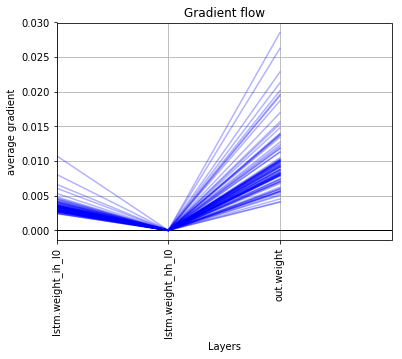

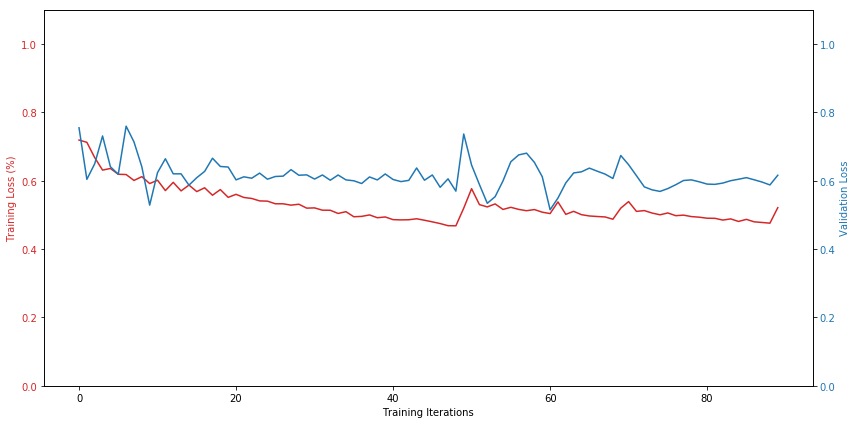

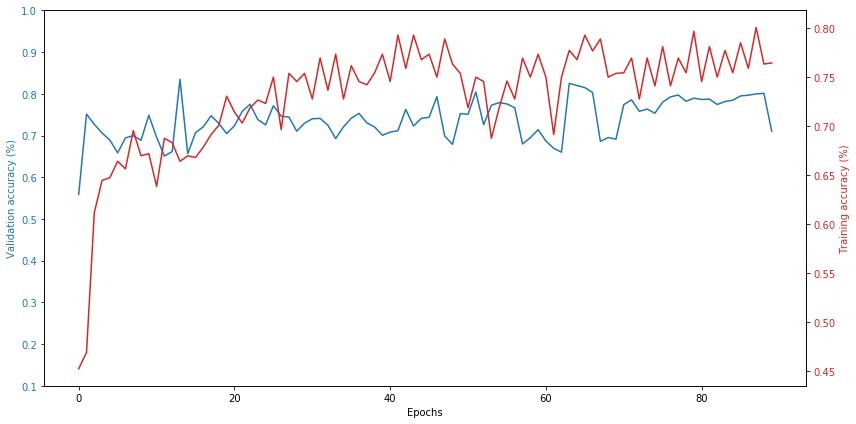

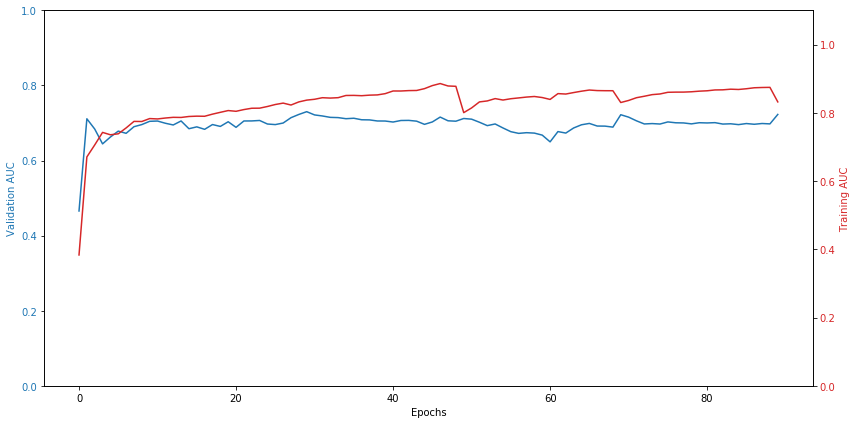

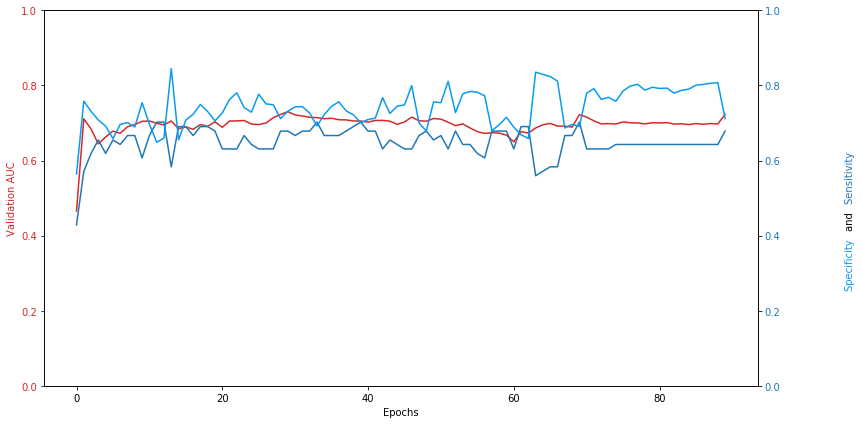


Fold  7
confused items in training set:  224
not_confused items in training set:  224
confused items in validation set:  72
not_confused items in validation set:  2040

Test confused items:

['105a_H-FE-17-1.pkl', '105a_H-FE-17-2.pkl', '105a_H-FE-17-3.pkl', '105a_H-FE-17-4.pkl', '105a_H-RV-22-1.pkl', '105a_H-RV-22-2.pkl', '105a_H-RV-22-3.pkl', '105a_H-RV-22-4.pkl', '105a_H-RV-8-1.pkl', '105a_H-RV-8-2.pkl', '105a_H-RV-8-3.pkl', '105a_H-RV-8-4.pkl', '105b_V-FE-20-1.pkl', '105b_V-FE-20-2.pkl', '105b_V-FE-20-3.pkl', '105b_V-FE-20-4.pkl', '105b_V-FE-8-1.pkl', '105b_V-FE-8-2.pkl', '105b_V-FE-8-3.pkl', '105b_V-FE-8-4.pkl', '105b_V-RV-5-1.pkl', '105b_V-RV-5-2.pkl', '105b_V-RV-5-3.pkl', '105b_V-RV-5-4.pkl', '134b_H-CDV-15-1.pkl', '134b_H-CDV-15-2.pkl', '134b_H-CDV-15-3.pkl', '134b_H-CDV-15-4.pkl', '134b_H-CDV-4-1.pkl', '134b_H-CDV-4-2.pkl', '134b_H-CDV-4-3.pkl', '134b_H-CDV-4-4.pkl', '50a_V-SortTwoFactors-22-1.pkl', '50a_V-SortTwoFactors-22-2.pkl', '50a_V-SortTwoFactors-22-3.pkl', '50a_V-SortT

[epoch: 15, batches:     1] loss: 0.51258 | accuracy: 0.75391
[epoch: 15, batches:     2] loss: 0.52177 | accuracy: 0.72917
Training accuracy for epoch:  0.7415364583333333
validation accuracy:  0.8745265151515151
validation loss:  0.5736146503024631
validation recall:  0.5833333333333334
validation specificity:  0.8848039215686274
validation AUC:  0.6928308823529412
Epochs without improvement:  3
[epoch: 16, batches:     1] loss: 0.50634 | accuracy: 0.75000
[epoch: 16, batches:     2] loss: 0.51811 | accuracy: 0.70833
Training accuracy for epoch:  0.7291666666666667
validation accuracy:  0.8196022727272727
validation loss:  0.5374417437447442
validation recall:  0.5972222222222222
validation specificity:  0.8274509803921568
validation AUC:  0.6996936274509804
Epochs without improvement:  4
[epoch: 17, batches:     1] loss: 0.49745 | accuracy: 0.75000
[epoch: 17, batches:     2] loss: 0.50826 | accuracy: 0.71875
Training accuracy for epoch:  0.734375
validation accuracy:  0.87357954545

[epoch: 35, batches:     1] loss: 0.49918 | accuracy: 0.74219
[epoch: 35, batches:     2] loss: 0.51646 | accuracy: 0.70312
Training accuracy for epoch:  0.72265625
validation accuracy:  0.8129734848484849
validation loss:  0.5632102456357744
validation recall:  0.5972222222222222
validation specificity:  0.8205882352941176
validation AUC:  0.6855664488017429
Epochs without improvement:  23
[epoch: 36, batches:     1] loss: 0.49716 | accuracy: 0.74219
[epoch: 36, batches:     2] loss: 0.50585 | accuracy: 0.75000
Training accuracy for epoch:  0.74609375
validation accuracy:  0.8096590909090909
validation loss:  0.5741986102528043
validation recall:  0.5972222222222222
validation specificity:  0.817156862745098
validation AUC:  0.6909041394335511
Epochs without improvement:  24
[epoch: 37, batches:     1] loss: 0.49437 | accuracy: 0.72266
[epoch: 37, batches:     2] loss: 0.50132 | accuracy: 0.75521
Training accuracy for epoch:  0.7389322916666667
validation accuracy:  0.8181818181818182

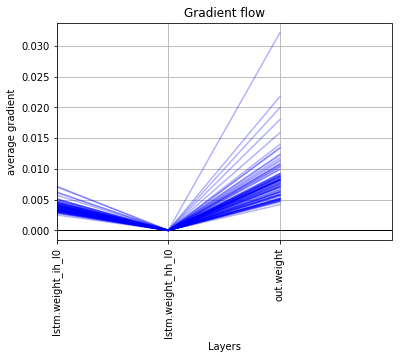

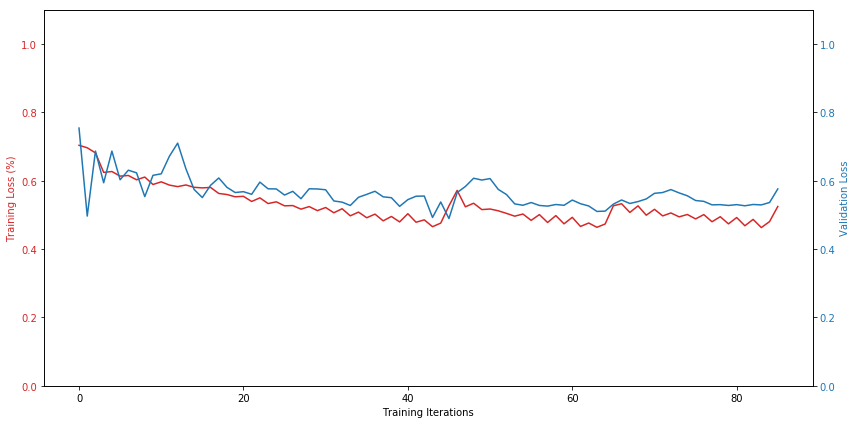

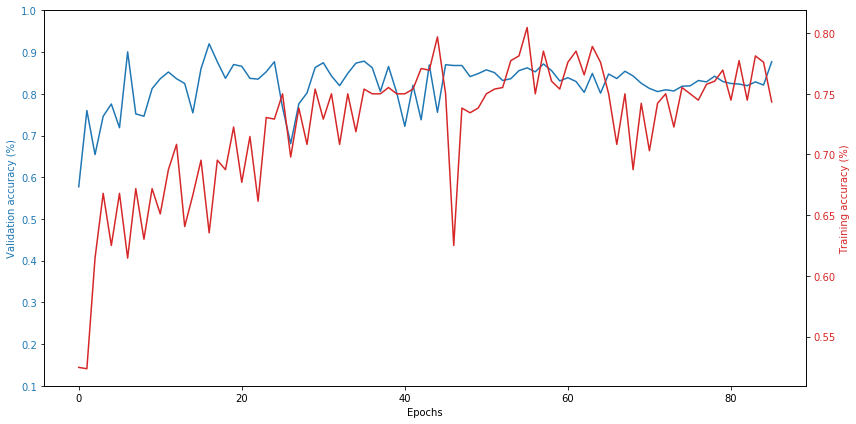

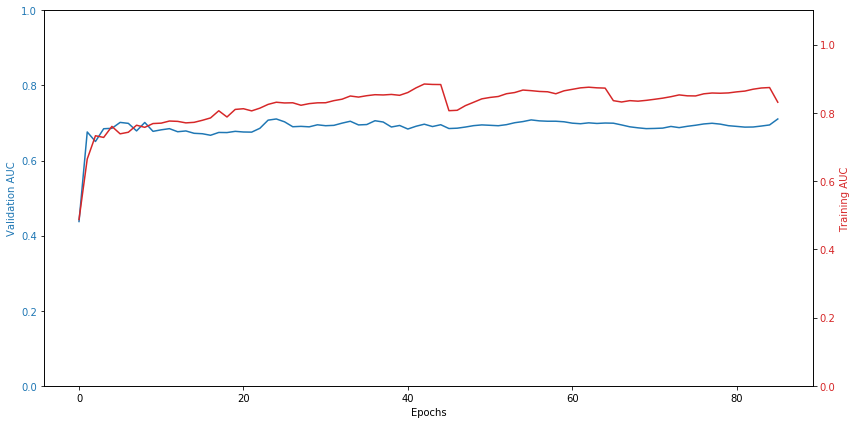

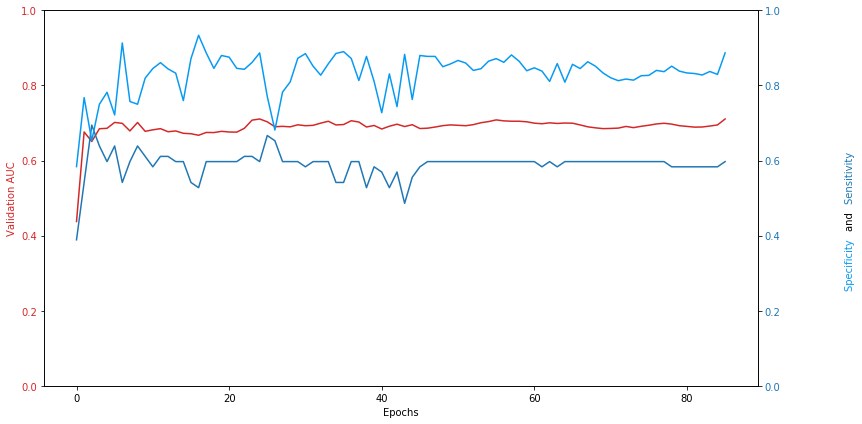


Fold  8
confused items in training set:  236
not_confused items in training set:  236
confused items in validation set:  68
not_confused items in validation set:  1964

Test confused items:

['121a_H-CDV-9-1.pkl', '121a_H-CDV-9-2.pkl', '121a_H-CDV-9-3.pkl', '121a_H-CDV-9-4.pkl', '121a_H-SortTwoFactors-20-1.pkl', '121a_H-SortTwoFactors-20-2.pkl', '121a_H-SortTwoFactors-20-3.pkl', '121a_H-SortTwoFactors-20-4.pkl', '121b_V-FE-2-1.pkl', '121b_V-FE-2-2.pkl', '121b_V-FE-2-3.pkl', '121b_V-FE-2-4.pkl', '121b_V-SortTwoFactors-11-1.pkl', '121b_V-SortTwoFactors-11-2.pkl', '121b_V-SortTwoFactors-11-3.pkl', '121b_V-SortTwoFactors-11-4.pkl', '129b_V-SortTwoFactors-23-1.pkl', '129b_V-SortTwoFactors-23-2.pkl', '129b_V-SortTwoFactors-23-3.pkl', '129b_V-SortTwoFactors-23-4.pkl', '141a_H-RV-18-1.pkl', '141a_H-RV-18-2.pkl', '141a_H-RV-18-3.pkl', '141a_H-RV-18-4.pkl', '141a_H-SortTwoFactors-22-1.pkl', '141a_H-SortTwoFactors-22-2.pkl', '141a_H-SortTwoFactors-22-3.pkl', '141a_H-SortTwoFactors-22-4.pkl', '55

[epoch: 15, batches:     2] loss: 0.47725 | accuracy: 0.78241
Training accuracy for epoch:  0.7759693287037037
validation accuracy:  0.5816929133858267
validation loss:  0.6018502786755562
validation recall:  0.5588235294117647
validation specificity:  0.5824847250509165
validation AUC:  0.5571986941416077
Epochs without improvement:  6
[epoch: 16, batches:     1] loss: 0.48002 | accuracy: 0.76562
[epoch: 16, batches:     2] loss: 0.46602 | accuracy: 0.81944
Training accuracy for epoch:  0.7925347222222222
validation accuracy:  0.6274606299212598
validation loss:  0.5708869360387325
validation recall:  0.5147058823529411
validation specificity:  0.6313645621181263
validation AUC:  0.5596097400263568
Epochs without improvement:  7
[epoch: 17, batches:     1] loss: 0.47746 | accuracy: 0.77344
[epoch: 17, batches:     2] loss: 0.46371 | accuracy: 0.80093
Training accuracy for epoch:  0.787181712962963
validation accuracy:  0.5374015748031497
validation loss:  0.5743605121970177
validation

Validation AUC:  0.5832484725050916
Validation Loss:  0.552352424710989
Epochs without improvement:  10
[epoch: 35, batches:     1] loss: 0.43799 | accuracy: 0.81250
[epoch: 35, batches:     2] loss: 0.52479 | accuracy: 0.69444
Training accuracy for epoch:  0.7534722222222222
validation accuracy:  0.6806102362204725
validation loss:  0.6156536862254143
validation recall:  0.45588235294117646
validation specificity:  0.6883910386965377
validation AUC:  0.5492542230741584
Epochs without improvement:  11
[epoch: 36, batches:     1] loss: 0.44398 | accuracy: 0.79297
[epoch: 36, batches:     2] loss: 0.44190 | accuracy: 0.81481
Training accuracy for epoch:  0.8038917824074074
validation accuracy:  0.5964566929133859
validation loss:  0.4825616218149662
validation recall:  0.5588235294117647
validation specificity:  0.5977596741344195
validation AUC:  0.5527435006589194
Epochs without improvement:  12
[epoch: 37, batches:     1] loss: 0.47980 | accuracy: 0.71484
[epoch: 37, batches:     2] l

validation accuracy:  0.5743110236220472
validation loss:  0.552352424710989
validation recall:  0.6764705882352942
validation specificity:  0.5707739307535642
validation AUC:  0.5832484725050916


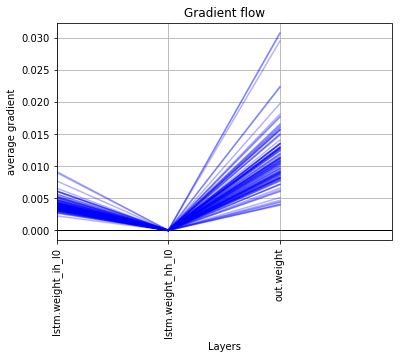

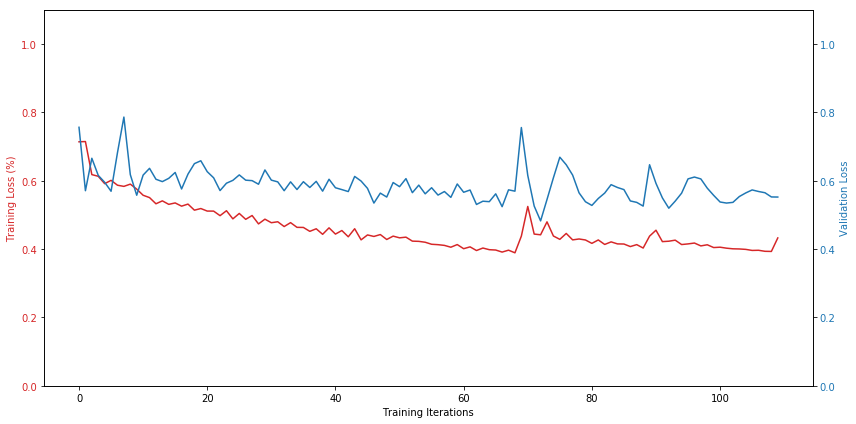

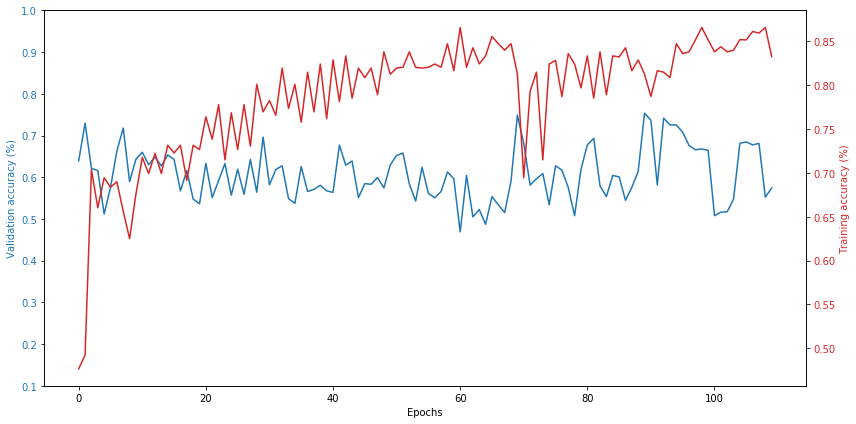

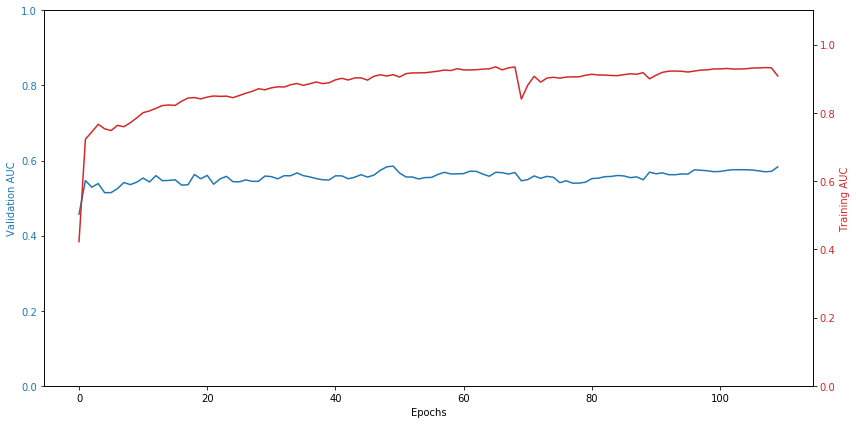

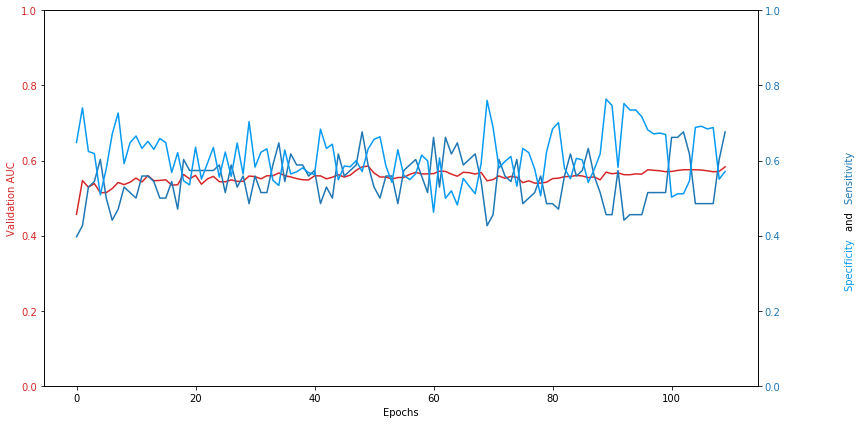


Fold  9
confused items in training set:  268
not_confused items in training set:  268
confused items in validation set:  56
not_confused items in validation set:  2388

Test confused items:

['103a_H-CDV-12-1.pkl', '103a_H-CDV-12-2.pkl', '103a_H-CDV-12-3.pkl', '103a_H-CDV-12-4.pkl', '103a_H-CDV-17-1.pkl', '103a_H-CDV-17-2.pkl', '103a_H-CDV-17-3.pkl', '103a_H-CDV-17-4.pkl', '11a_H-SortTwoFactors-5-1.pkl', '11a_H-SortTwoFactors-5-2.pkl', '11a_H-SortTwoFactors-5-3.pkl', '11a_H-SortTwoFactors-5-4.pkl', '143a_H-CDV-17-1.pkl', '143a_H-CDV-17-2.pkl', '143a_H-CDV-17-3.pkl', '143a_H-CDV-17-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 536
    Root Location: ./dataset/augmented/train3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2444
    Root Location: ./dataset/augmented/val3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Test data:  Dataset DatasetFolder


[epoch: 15, batches:     1] loss: 0.54223 | accuracy: 0.75781
[epoch: 15, batches:     2] loss: 0.57057 | accuracy: 0.69922
[epoch: 15, batches:     3] loss: 0.54170 | accuracy: 0.62500
Training accuracy for epoch:  0.6940104166666666
validation accuracy:  0.529050736497545
validation loss:  0.6074426472187042
validation recall:  0.625
validation specificity:  0.5268006700167505
validation AUC:  0.5579684134960518
Epochs without improvement:  13
[epoch: 16, batches:     1] loss: 0.53684 | accuracy: 0.73828
[epoch: 16, batches:     2] loss: 0.55993 | accuracy: 0.68359
[epoch: 16, batches:     3] loss: 0.52628 | accuracy: 0.66667
Training accuracy for epoch:  0.6961805555555555
validation accuracy:  0.6714402618657938
validation loss:  0.6522344350814819
validation recall:  0.5357142857142857
validation specificity:  0.6746231155778895
validation AUC:  0.5626495573103614
Epochs without improvement:  14
[epoch: 17, batches:     1] loss: 0.52925 | accuracy: 0.72266
[epoch: 17, batches:    

[epoch: 32, batches:     1] loss: 0.50249 | accuracy: 0.75391
[epoch: 32, batches:     2] loss: 0.52648 | accuracy: 0.69531
[epoch: 32, batches:     3] loss: 0.43097 | accuracy: 0.79167
Training accuracy for epoch:  0.7469618055555555
validation accuracy:  0.7139934533551555
validation loss:  0.6122042119503022
validation recall:  0.5714285714285714
validation specificity:  0.7173366834170855
validation AUC:  0.6036955611390284
Epochs without improvement:  1
[epoch: 33, batches:     1] loss: 0.49902 | accuracy: 0.76953
[epoch: 33, batches:     2] loss: 0.51840 | accuracy: 0.71094
[epoch: 33, batches:     3] loss: 0.43036 | accuracy: 0.83333
Training accuracy for epoch:  0.7712673611111112
validation accuracy:  0.6910801963993454
validation loss:  0.6114329725503922
validation recall:  0.5535714285714286
validation specificity:  0.6943048576214406
validation AUC:  0.5995827351040919
Epochs without improvement:  2
[epoch: 34, batches:     1] loss: 0.49588 | accuracy: 0.76562
[epoch: 34, 

Training accuracy for epoch:  0.8441840277777778
validation accuracy:  0.7643207855973814
validation loss:  0.6155078500509262
validation recall:  0.5
validation specificity:  0.7705192629815746
validation AUC:  0.6044209140942809
Epochs without improvement:  8
[epoch: 50, batches:     1] loss: 0.44950 | accuracy: 0.79688
[epoch: 50, batches:     2] loss: 0.45968 | accuracy: 0.79297
[epoch: 50, batches:     3] loss: 0.30984 | accuracy: 0.95833
Training accuracy for epoch:  0.8493923611111112
validation accuracy:  0.7647299509001637
validation loss:  0.6115602940320969
validation recall:  0.5
validation specificity:  0.7709380234505863
validation AUC:  0.6043536133046183
Epochs without improvement:  9
[epoch: 51, batches:     1] loss: 0.44449 | accuracy: 0.80469
[epoch: 51, batches:     2] loss: 0.45888 | accuracy: 0.80469
[epoch: 51, batches:     3] loss: 0.31508 | accuracy: 0.95833
Training accuracy for epoch:  0.8559027777777778
validation accuracy:  0.686988543371522
validation loss

[epoch: 66, batches:     1] loss: 0.39520 | accuracy: 0.83984
[epoch: 66, batches:     2] loss: 0.40598 | accuracy: 0.82422
[epoch: 66, batches:     3] loss: 0.24555 | accuracy: 1.00000
Training accuracy for epoch:  0.8880208333333334
validation accuracy:  0.6824877250409165
validation loss:  0.6065891087055206
validation recall:  0.5535714285714286
validation specificity:  0.6855108877721943
validation AUC:  0.6247980976310122
Epochs without improvement:  6
[epoch: 67, batches:     1] loss: 0.39268 | accuracy: 0.84766
[epoch: 67, batches:     2] loss: 0.40340 | accuracy: 0.83203
[epoch: 67, batches:     3] loss: 0.24571 | accuracy: 1.00000
Training accuracy for epoch:  0.8932291666666666
validation accuracy:  0.6816693944353519
validation loss:  0.6030586570501327
validation recall:  0.5535714285714286
validation specificity:  0.6846733668341709
validation AUC:  0.6261366355587461
Old best AUC:  0.6257029193586983
New best SUC:  0.6261366355587461
New best model found. Saving now.
Epo

[epoch: 83, batches:     1] loss: 0.37865 | accuracy: 0.84766
[epoch: 83, batches:     2] loss: 0.39107 | accuracy: 0.84375
[epoch: 83, batches:     3] loss: 0.23177 | accuracy: 1.00000
Training accuracy for epoch:  0.8971354166666666
validation accuracy:  0.7180851063829787
validation loss:  0.6011169165372848
validation recall:  0.5535714285714286
validation specificity:  0.7219430485762144
validation AUC:  0.6232576573342904
Epochs without improvement:  15
[epoch: 84, batches:     1] loss: 0.37198 | accuracy: 0.86328
[epoch: 84, batches:     2] loss: 0.38722 | accuracy: 0.84375
[epoch: 84, batches:     3] loss: 0.22964 | accuracy: 1.00000
Training accuracy for epoch:  0.90234375
validation accuracy:  0.6256137479541735
validation loss:  0.6126045912504197
validation recall:  0.6071428571428571
validation specificity:  0.6260469011725294
validation AUC:  0.6238110193826274
Epochs without improvement:  16
[epoch: 85, batches:     1] loss: 0.37135 | accuracy: 0.85547
[epoch: 85, batche

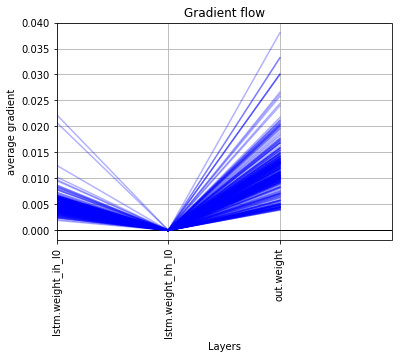

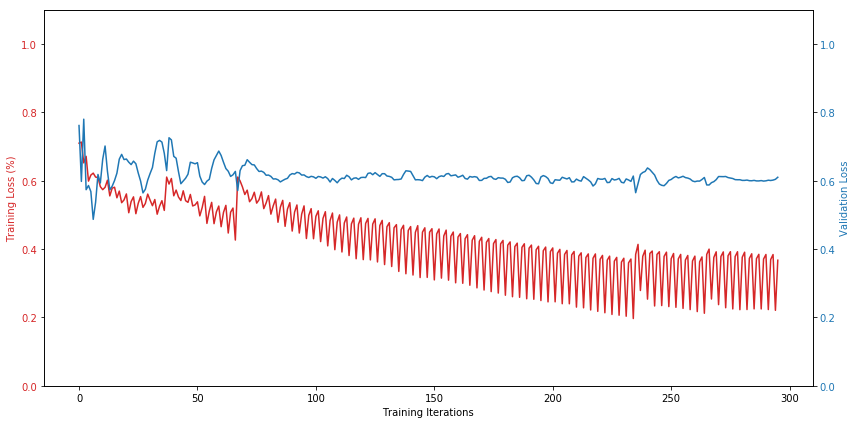

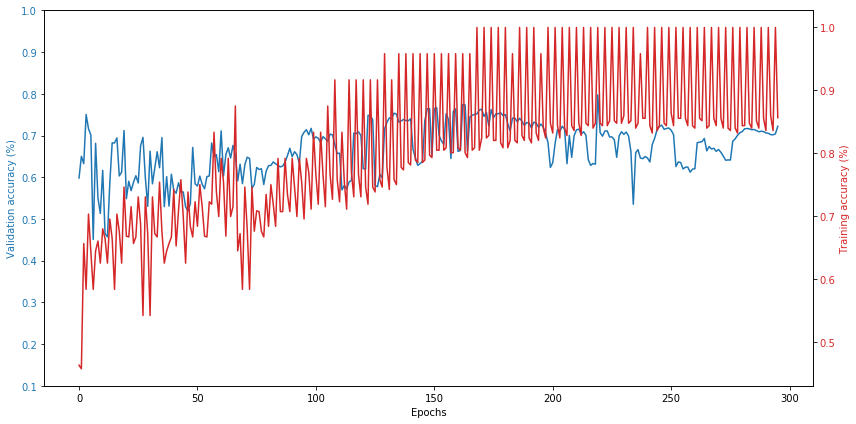

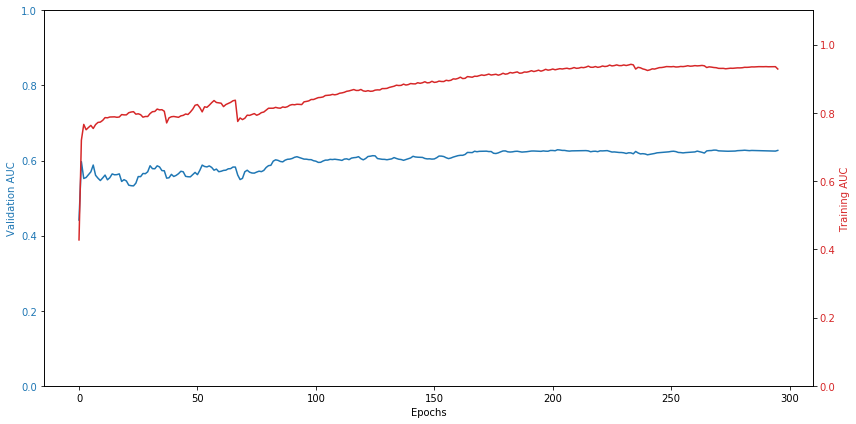

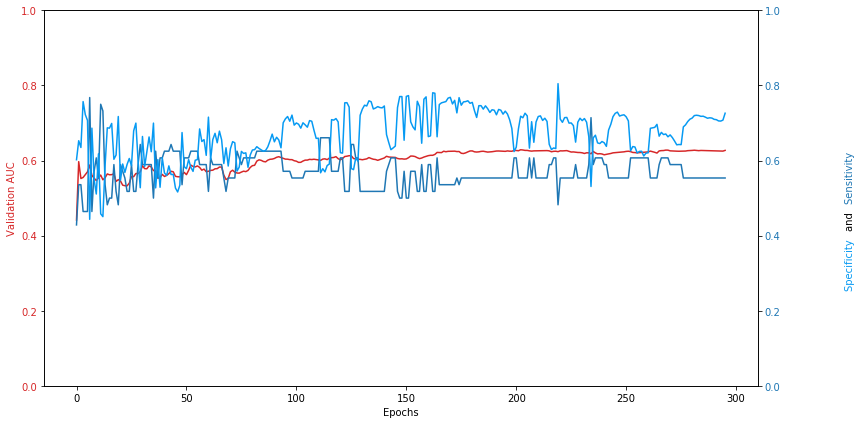


Fold  10
confused items in training set:  212
not_confused items in training set:  212
confused items in validation set:  76
not_confused items in validation set:  2300

Test confused items:

['112a_V-SortTwoFactors-5-1.pkl', '112a_V-SortTwoFactors-5-2.pkl', '112a_V-SortTwoFactors-5-3.pkl', '112a_V-SortTwoFactors-5-4.pkl', '114a_V-SortTwoFactors-12-1.pkl', '114a_V-SortTwoFactors-12-2.pkl', '114a_V-SortTwoFactors-12-3.pkl', '114a_V-SortTwoFactors-12-4.pkl', '130a_V-RV-10-1.pkl', '130a_V-RV-10-2.pkl', '130a_V-RV-10-3.pkl', '130a_V-RV-10-4.pkl', '35a_H-SortTwoFactors-15-1.pkl', '35a_H-SortTwoFactors-15-2.pkl', '35a_H-SortTwoFactors-15-3.pkl', '35a_H-SortTwoFactors-15-4.pkl', '35a_H-SortTwoFactors-22-1.pkl', '35a_H-SortTwoFactors-22-2.pkl', '35a_H-SortTwoFactors-22-3.pkl', '35a_H-SortTwoFactors-22-4.pkl', '35a_H-SortTwoFactors-4-1.pkl', '35a_H-SortTwoFactors-4-2.pkl', '35a_H-SortTwoFactors-4-3.pkl', '35a_H-SortTwoFactors-4-4.pkl', '39a_H-SortTwoFactors-10-1.pkl', '39a_H-SortTwoFactors-10-

[epoch: 14, batches:     1] loss: 0.55278 | accuracy: 0.72266
[epoch: 14, batches:     2] loss: 0.55043 | accuracy: 0.69643
Training accuracy for epoch:  0.7095424107142857
validation accuracy:  0.6792929292929293
validation loss:  0.583312651515007
validation recall:  0.5394736842105263
validation specificity:  0.6839130434782609
validation AUC:  0.626824942791762
Epochs without improvement:  9
[epoch: 15, batches:     1] loss: 0.54331 | accuracy: 0.71094
[epoch: 15, batches:     2] loss: 0.54293 | accuracy: 0.70833
Training accuracy for epoch:  0.7096354166666667
validation accuracy:  0.5050505050505051
validation loss:  0.5803768396377563
validation recall:  0.7105263157894737
validation specificity:  0.49826086956521737
validation AUC:  0.6094908466819222
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.003
New learning rate: 0.0015
Validation AUC:  0.6621338672768878
Validation Loss:  0.6263767004013061
Epochs without improvement:  10


[epoch: 33, batches:     1] loss: 0.54000 | accuracy: 0.73828
[epoch: 33, batches:     2] loss: 0.55343 | accuracy: 0.71429
Training accuracy for epoch:  0.7262834821428572
validation accuracy:  0.6195286195286195
validation loss:  0.6100275129079819
validation recall:  0.6842105263157895
validation specificity:  0.6173913043478261
validation AUC:  0.6473655606407323
Epochs without improvement:  11
[epoch: 34, batches:     1] loss: 0.54084 | accuracy: 0.72266
[epoch: 34, batches:     2] loss: 0.53710 | accuracy: 0.70238
Training accuracy for epoch:  0.7125186011904762
validation accuracy:  0.6687710437710438
validation loss:  0.582488614320755
validation recall:  0.6578947368421053
validation specificity:  0.6691304347826087
validation AUC:  0.6378489702517163
Epochs without improvement:  12
[epoch: 35, batches:     1] loss: 0.53869 | accuracy: 0.68750
[epoch: 35, batches:     2] loss: 0.53153 | accuracy: 0.70833
Training accuracy for epoch:  0.6979166666666667
validation accuracy:  0.

[epoch: 53, batches:     1] loss: 0.50248 | accuracy: 0.76953
[epoch: 53, batches:     2] loss: 0.50784 | accuracy: 0.75595
Training accuracy for epoch:  0.7627418154761905
validation accuracy:  0.7218013468013468
validation loss:  0.5624942928552628
validation recall:  0.631578947368421
validation specificity:  0.7247826086956521
validation AUC:  0.6479862700228832
Epochs without improvement:  13
[epoch: 54, batches:     1] loss: 0.50364 | accuracy: 0.77734
[epoch: 54, batches:     2] loss: 0.50498 | accuracy: 0.74405
Training accuracy for epoch:  0.7606956845238095
validation accuracy:  0.7104377104377104
validation loss:  0.5632722854614258
validation recall:  0.6447368421052632
validation specificity:  0.7126086956521739
validation AUC:  0.648329519450801
Epochs without improvement:  14
[epoch: 55, batches:     1] loss: 0.50305 | accuracy: 0.76953
[epoch: 55, batches:     2] loss: 0.50140 | accuracy: 0.73214
Training accuracy for epoch:  0.7508370535714286
validation accuracy:  0.7

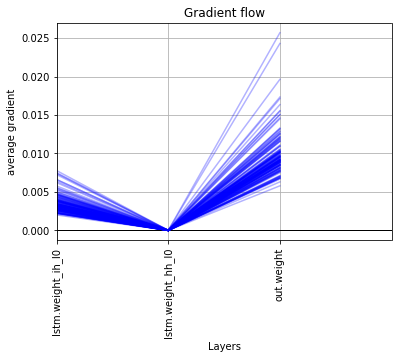

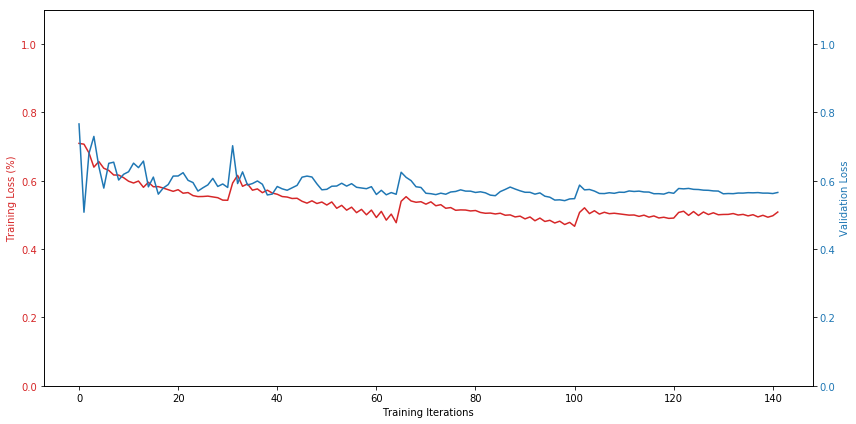

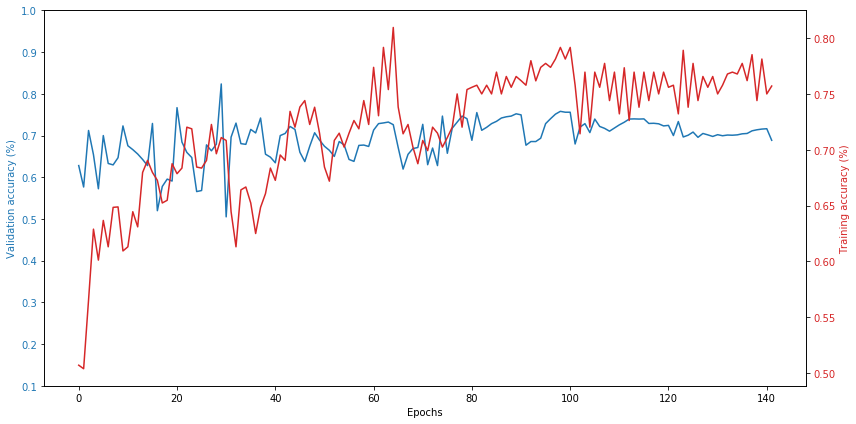

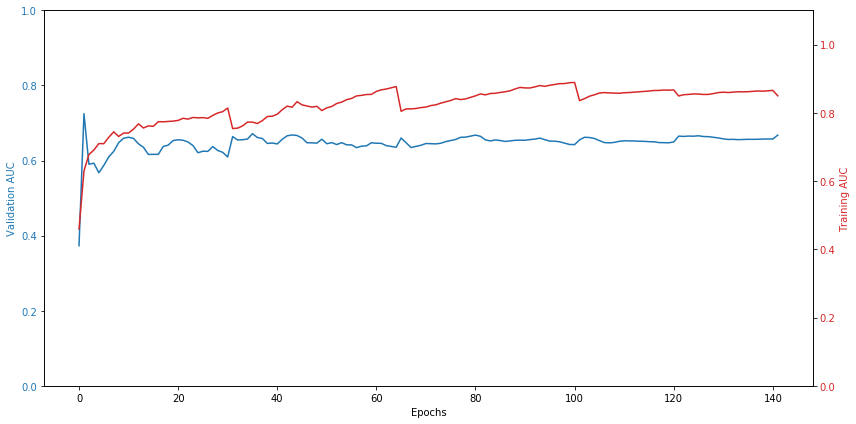

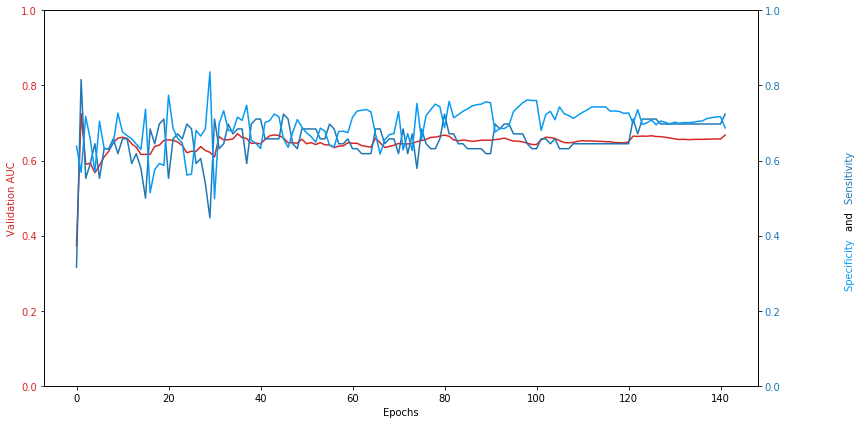


10-fold CV accuracy: 0.701316
10-fold CV sensitivity: 0.640682 
10-fold CV specificity: 0.703173 
10-fold CV AUC: 0.658170 

10-fold test accuracy: 0.601017
10-fold test sensitivity: 0.716554 
10-fold test specificity: 0.597740 
10-fold test AUC: 0.653340 


([0.5782647584973166,
  0.7863636363636364,
  0.7361351819757366,
  0.6794982698961938,
  0.6605584642233857,
  0.7104092526690391,
  0.8768939393939394,
  0.5743110236220472,
  0.722176759410802,
  0.6885521885521886],
 [0.59375,
  0.6904761904761905,
  0.671875,
  0.5441176470588235,
  0.6770833333333334,
  0.6785714285714286,
  0.5972222222222222,
  0.6764705882352942,
  0.5535714285714286,
  0.7236842105263158],
 [0.5778084714548803,
  0.7898116438356164,
  0.7379679144385026,
  0.6836007130124777,
  0.6598360655737705,
  0.711645101663586,
  0.8867647058823529,
  0.5707739307535642,
  0.7261306532663316,
  0.6873913043478261],
 [0.5668594613259669,
  0.7649166258969341,
  0.6749039104278075,
  0.5826517772884554,
  0.680621964177292,
  0.7228567027550392,
  0.7107911220043572,
  0.5832484725050916,
  0.6270564130174683,
  0.6677974828375286],
 [0.5132398753894081,
  0.7437694704049844,
  0.5981308411214953,
  0.822429906542056,
  0.3940809968847352,
  0.59472049689441,
  0.6066978

In [9]:
# monitoring validation AUC
np.random.seed(MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

cross_validate(model_type='lstm',
                   folds=10,
                   epochs=300,
                   criterion_type='NLLLoss',
                   optimizer_type='Adam',
                   confused_path='./dataset/augmented/confused_highly_valid/',
                   not_confused_path='./dataset/augmented/not_confused_highly_valid/',
                   print_every=1,
                   plot_every=1,
                   hidden_size=HIDDEN_SIZE,
                   num_layers=1,
                   early_stopping=True,
                   early_stopping_metric='val_auc',
                   early_stopping_patience=30,
                   rate_decay=True,
                   rate_decay_patience=10,
                   initial_learning_rate=0.003,
                   verbose=True)


Fold  1
confused items in training set:  220
not_confused items in training set:  220
confused items in validation set:  64
not_confused items in validation set:  2172

Test confused items:

['131a_H-CDV-5-1.pkl', '131a_H-CDV-5-2.pkl', '131a_H-CDV-5-3.pkl', '131a_H-CDV-5-4.pkl', '131a_H-SortTwoFactors-12-1.pkl', '131a_H-SortTwoFactors-12-2.pkl', '131a_H-SortTwoFactors-12-3.pkl', '131a_H-SortTwoFactors-12-4.pkl', '131b_V-SortTwoFactors-21-1.pkl', '131b_V-SortTwoFactors-21-2.pkl', '131b_V-SortTwoFactors-21-3.pkl', '131b_V-SortTwoFactors-21-4.pkl', '132a_V-CDV-2-1.pkl', '132a_V-CDV-2-2.pkl', '132a_V-CDV-2-3.pkl', '132a_V-CDV-2-4.pkl', '132a_V-SortOverall-21-1.pkl', '132a_V-SortOverall-21-2.pkl', '132a_V-SortOverall-21-3.pkl', '132a_V-SortOverall-21-4.pkl', '132a_V-SortOverall-9-1.pkl', '132a_V-SortOverall-9-2.pkl', '132a_V-SortOverall-9-3.pkl', '132a_V-SortOverall-9-4.pkl', '132a_V-SortTwoFactors-6-1.pkl', '132a_V-SortTwoFactors-6-2.pkl', '132a_V-SortTwoFactors-6-3.pkl', '132a_V-SortTwoF

[epoch: 14, batches:     1] loss: 0.44829 | accuracy: 0.78906
[epoch: 14, batches:     2] loss: 0.46692 | accuracy: 0.75543
Training accuracy for epoch:  0.7722486413043479
validation accuracy:  0.644901610017889
validation loss:  0.5731369455655416
validation recall:  0.5625
validation specificity:  0.647329650092081
validation AUC:  0.5904983885819521
Epochs without improvement:  3
[epoch: 15, batches:     1] loss: 0.43738 | accuracy: 0.80078
[epoch: 15, batches:     2] loss: 0.45954 | accuracy: 0.77717
Training accuracy for epoch:  0.7889775815217391
validation accuracy:  0.6520572450805009
validation loss:  0.548999610874388
validation recall:  0.5625
validation specificity:  0.6546961325966851
validation AUC:  0.5958362108655617
Epochs without improvement:  4
[epoch: 16, batches:     1] loss: 0.42532 | accuracy: 0.80859
[epoch: 16, batches:     2] loss: 0.45268 | accuracy: 0.78261
Training accuracy for epoch:  0.7956012228260869
validation accuracy:  0.6699463327370304
validation 

[epoch: 34, batches:     1] loss: 0.45252 | accuracy: 0.78906
[epoch: 34, batches:     2] loss: 0.46465 | accuracy: 0.75000
Training accuracy for epoch:  0.76953125
validation accuracy:  0.6422182468694096
validation loss:  0.6087798807356093
validation recall:  0.53125
validation specificity:  0.64548802946593
validation AUC:  0.5696218922651934
Epochs without improvement:  23
[epoch: 35, batches:     1] loss: 0.44339 | accuracy: 0.79297
[epoch: 35, batches:     2] loss: 0.45766 | accuracy: 0.76087
Training accuracy for epoch:  0.7769191576086957
validation accuracy:  0.5693202146690519
validation loss:  0.5552890996138254
validation recall:  0.625
validation specificity:  0.5676795580110497
validation AUC:  0.5801392725598526
Epochs without improvement:  24
[epoch: 36, batches:     1] loss: 0.43173 | accuracy: 0.80469
[epoch: 36, batches:     2] loss: 0.45396 | accuracy: 0.77174
Training accuracy for epoch:  0.7882133152173914
validation accuracy:  0.5532200357781754
validation loss:

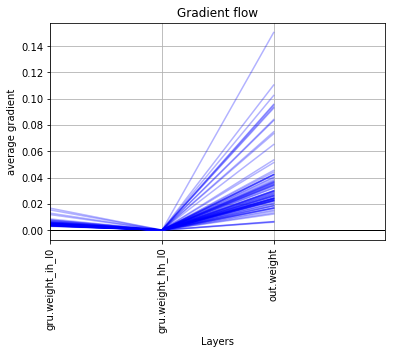

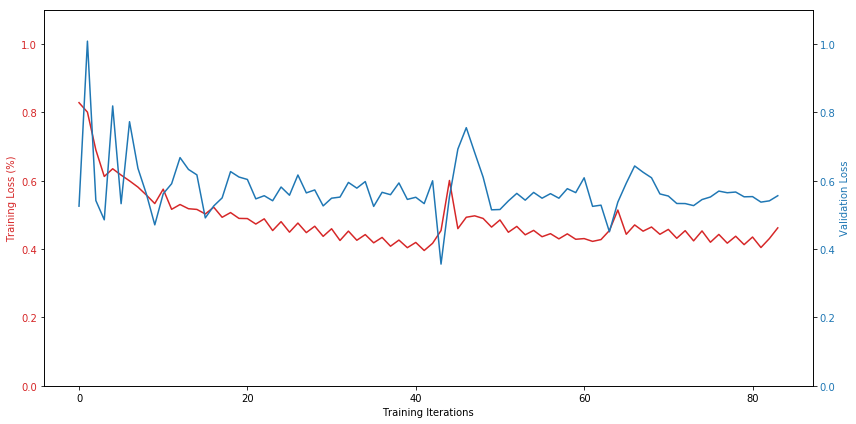

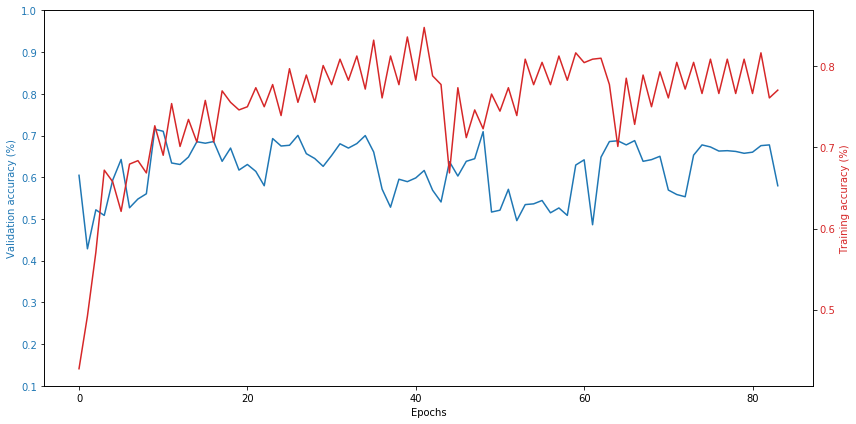

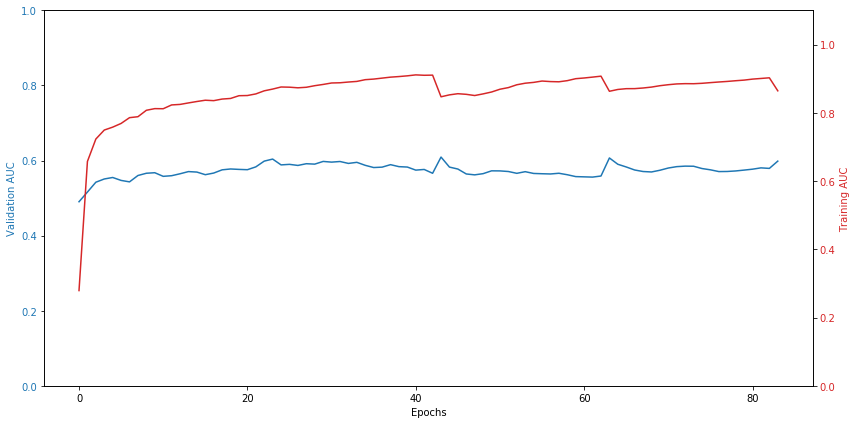

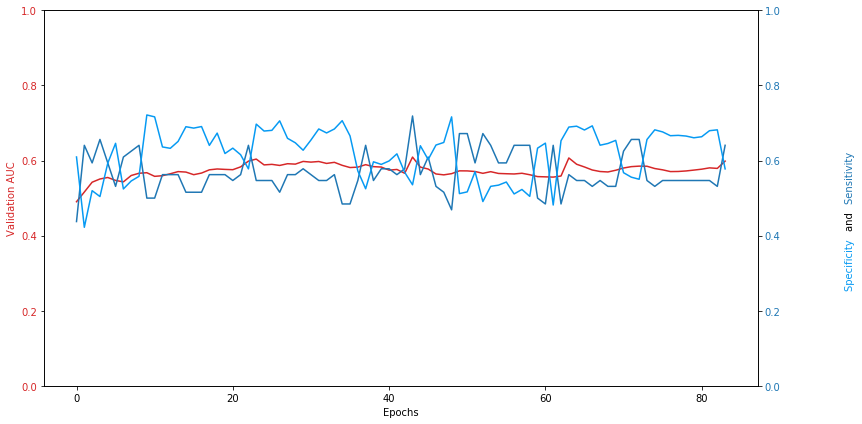


Fold  2
confused items in training set:  224
not_confused items in training set:  224
confused items in validation set:  84
not_confused items in validation set:  2336

Test confused items:

['126a_V-SortTwoFactors-6-1.pkl', '126a_V-SortTwoFactors-6-2.pkl', '126a_V-SortTwoFactors-6-3.pkl', '126a_V-SortTwoFactors-6-4.pkl', '133a_H-CDV-16-1.pkl', '133a_H-CDV-16-2.pkl', '133a_H-CDV-16-3.pkl', '133a_H-CDV-16-4.pkl', '1b_V-CDV-17-1.pkl', '1b_V-CDV-17-2.pkl', '1b_V-CDV-17-3.pkl', '1b_V-CDV-17-4.pkl', '36a_V-SortTwoFactors-2-1.pkl', '36a_V-SortTwoFactors-2-2.pkl', '36a_V-SortTwoFactors-2-3.pkl', '36a_V-SortTwoFactors-2-4.pkl', '48a_V-SortTwoFactors-12-1.pkl', '48a_V-SortTwoFactors-12-2.pkl', '48a_V-SortTwoFactors-12-3.pkl', '48a_V-SortTwoFactors-12-4.pkl', '63a_H-SortTwoFactors-5-1.pkl', '63a_H-SortTwoFactors-5-2.pkl', '63a_H-SortTwoFactors-5-3.pkl', '63a_H-SortTwoFactors-5-4.pkl', '8a_V-SortTwoFactors-10-1.pkl', '8a_V-SortTwoFactors-10-2.pkl', '8a_V-SortTwoFactors-10-3.pkl', '8a_V-SortTwoFa

[epoch: 15, batches:     1] loss: 0.52167 | accuracy: 0.72266
[epoch: 15, batches:     2] loss: 0.48446 | accuracy: 0.81250
Training accuracy for epoch:  0.767578125
validation accuracy:  0.7115702479338843
validation loss:  0.5749562919139862
validation recall:  0.7023809523809523
validation specificity:  0.7119006849315068
validation AUC:  0.7339418215916503
Epochs without improvement:  4
[epoch: 16, batches:     1] loss: 0.50791 | accuracy: 0.74219
[epoch: 16, batches:     2] loss: 0.47177 | accuracy: 0.82812
Training accuracy for epoch:  0.78515625
validation accuracy:  0.7128099173553719
validation loss:  0.5353091418743133
validation recall:  0.6904761904761905
validation specificity:  0.7136130136986302
validation AUC:  0.7177460453359428
Epochs without improvement:  5
[epoch: 17, batches:     1] loss: 0.49469 | accuracy: 0.77734
[epoch: 17, batches:     2] loss: 0.47449 | accuracy: 0.81250
Training accuracy for epoch:  0.794921875
validation accuracy:  0.759090909090909
validat

[epoch: 35, batches:     1] loss: 0.51901 | accuracy: 0.74609
[epoch: 35, batches:     2] loss: 0.48849 | accuracy: 0.79167
Training accuracy for epoch:  0.7688802083333333
validation accuracy:  0.8165289256198347
validation loss:  0.4933118551969528
validation recall:  0.6547619047619048
validation specificity:  0.822345890410959
validation AUC:  0.7468301532941944
Epochs without improvement:  1
[epoch: 36, batches:     1] loss: 0.50994 | accuracy: 0.76172
[epoch: 36, batches:     2] loss: 0.48621 | accuracy: 0.79167
Training accuracy for epoch:  0.7766927083333333
validation accuracy:  0.7867768595041322
validation loss:  0.5155899345874786
validation recall:  0.6904761904761905
validation specificity:  0.7902397260273972
validation AUC:  0.7430742416829745
Epochs without improvement:  2
[epoch: 37, batches:     1] loss: 0.50145 | accuracy: 0.78516
[epoch: 37, batches:     2] loss: 0.47967 | accuracy: 0.82812
Training accuracy for epoch:  0.806640625
validation accuracy:  0.804958677

Validation AUC:  0.7490775848010439
Validation Loss:  0.5563523441553115
Epochs without improvement:  20
[epoch: 55, batches:     1] loss: 0.51901 | accuracy: 0.74609
[epoch: 55, batches:     2] loss: 0.49005 | accuracy: 0.80729
Training accuracy for epoch:  0.7766927083333333
validation accuracy:  0.7702479338842976
validation loss:  0.5166898101568222
validation recall:  0.7142857142857143
validation specificity:  0.7722602739726028
validation AUC:  0.7520231979778214
Old best AUC:  0.7490775848010439
New best SUC:  0.7520231979778214
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 56, batches:     1] loss: 0.50793 | accuracy: 0.78125
[epoch: 56, batches:     2] loss: 0.48657 | accuracy: 0.80208
Training accuracy for epoch:  0.7916666666666667
validation accuracy:  0.7446280991735538
validation loss:  0.5308436423540115
validation recall:  0.7142857142857143
validation specificity:  0.7457191780821918
validation AUC:  0.7477627609262882
Epochs without improve

[epoch: 75, batches:     1] loss: 0.49427 | accuracy: 0.78125
[epoch: 75, batches:     2] loss: 0.47224 | accuracy: 0.81250
Training accuracy for epoch:  0.796875
validation accuracy:  0.7648760330578512
validation loss:  0.5249553024768829
validation recall:  0.6904761904761905
validation specificity:  0.7675513698630136
validation AUC:  0.7425748124592303
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 9.375e-05
New learning rate: 4.6875e-05
Validation AUC:  0.7520231979778214
Validation Loss:  0.5166898101568222
Epochs without improvement:  20
[epoch: 76, batches:     1] loss: 0.50793 | accuracy: 0.78125
[epoch: 76, batches:     2] loss: 0.48738 | accuracy: 0.80208
Training accuracy for epoch:  0.7916666666666667
validation accuracy:  0.7648760330578512
validation loss:  0.5229222804307938
validation recall:  0.7142857142857143
validation specificity:  0.766695205479452
validation AUC:  0.7516970401174169
Epochs without improvement:  21
[

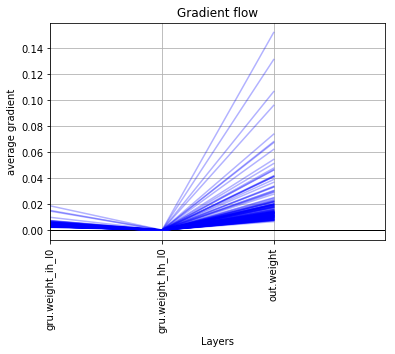

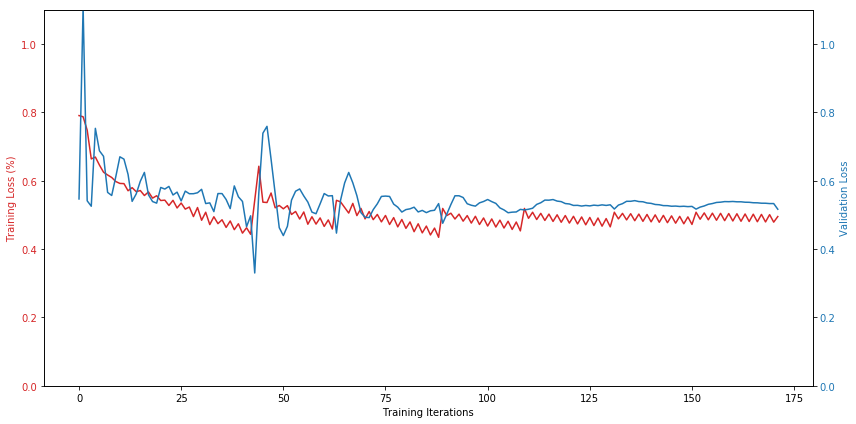

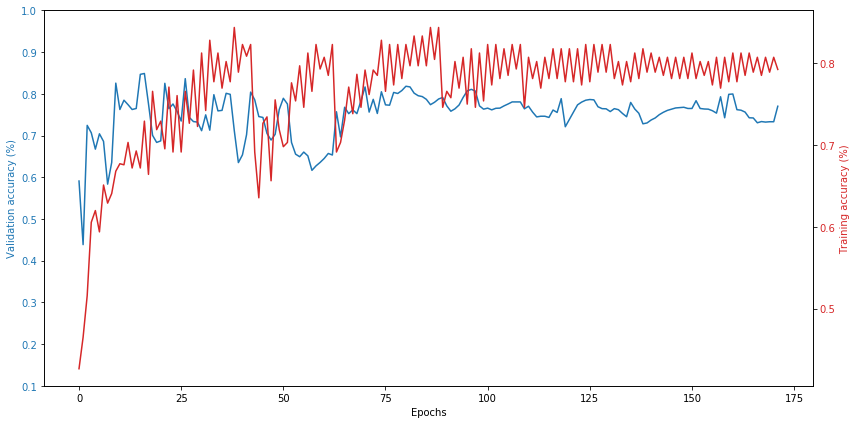

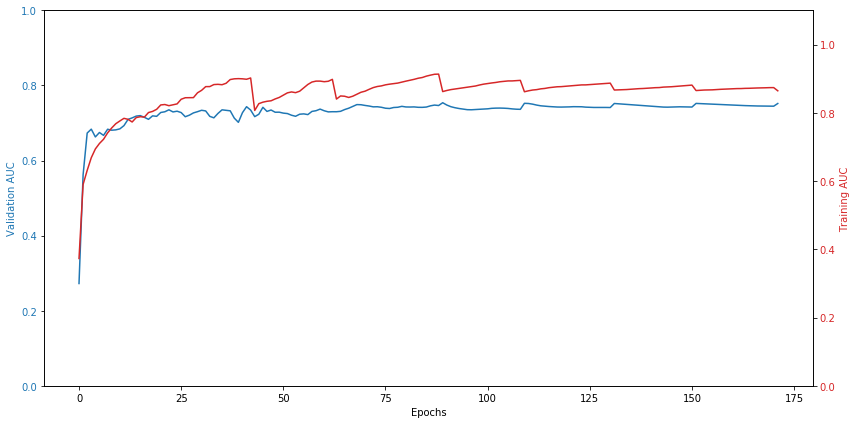

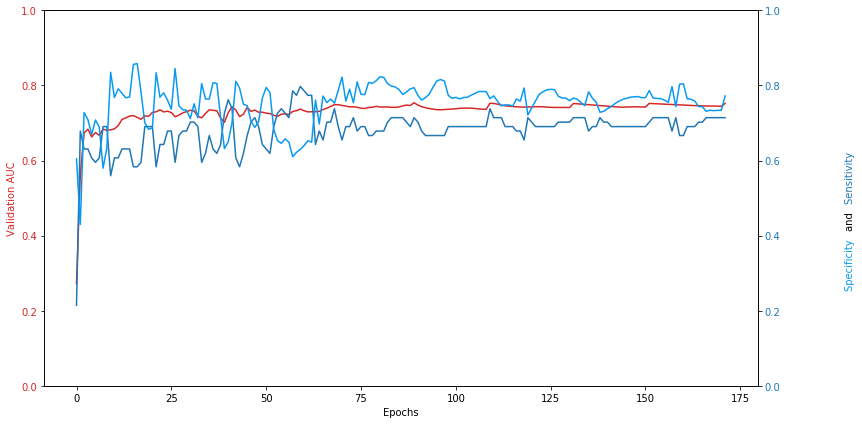


Fold  3
confused items in training set:  236
not_confused items in training set:  236
confused items in validation set:  64
not_confused items in validation set:  2244

Test confused items:

['111a_H-SortTwoFactors-3-1.pkl', '111a_H-SortTwoFactors-3-2.pkl', '111a_H-SortTwoFactors-3-3.pkl', '111a_H-SortTwoFactors-3-4.pkl', '137a_H-FE-4-1.pkl', '137a_H-FE-4-2.pkl', '137a_H-FE-4-3.pkl', '137a_H-FE-4-4.pkl', '137a_H-SortTwoFactors-2-1.pkl', '137a_H-SortTwoFactors-2-2.pkl', '137a_H-SortTwoFactors-2-3.pkl', '137a_H-SortTwoFactors-2-4.pkl', '137b_V-FE-20-1.pkl', '137b_V-FE-20-2.pkl', '137b_V-FE-20-3.pkl', '137b_V-FE-20-4.pkl', '145b_V-SortTwoFactors-10-1.pkl', '145b_V-SortTwoFactors-10-2.pkl', '145b_V-SortTwoFactors-10-3.pkl', '145b_V-SortTwoFactors-10-4.pkl', '145b_V-SortTwoFactors-24-1.pkl', '145b_V-SortTwoFactors-24-2.pkl', '145b_V-SortTwoFactors-24-3.pkl', '145b_V-SortTwoFactors-24-4.pkl', '14a_V-SortTwoFactors-3-1.pkl', '14a_V-SortTwoFactors-3-2.pkl', '14a_V-SortTwoFactors-3-3.pkl', '14

[epoch: 16, batches:     1] loss: 0.51618 | accuracy: 0.74219
[epoch: 16, batches:     2] loss: 0.50195 | accuracy: 0.72222
Training accuracy for epoch:  0.7322048611111112
validation accuracy:  0.6702772963604853
validation loss:  0.6121081501245499
validation recall:  0.609375
validation specificity:  0.6720142602495544
validation AUC:  0.6488135026737968
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.003
New learning rate: 0.0015
Validation AUC:  0.6729960450089127
Validation Loss:  0.5759575486183166
Epochs without improvement:  10
[epoch: 17, batches:     1] loss: 0.57786 | accuracy: 0.66016
[epoch: 17, batches:     2] loss: 0.64862 | accuracy: 0.61574
Training accuracy for epoch:  0.6379484953703703
validation accuracy:  0.7686308492201039
validation loss:  0.5455021262168884
validation recall:  0.5625
validation specificity:  0.7745098039215687
validation AUC:  0.6644872437611409
Epochs without improvement:  11
[epoch: 18, batches:

[epoch: 36, batches:     1] loss: 0.51360 | accuracy: 0.74219
[epoch: 36, batches:     2] loss: 0.50794 | accuracy: 0.75926
Training accuracy for epoch:  0.7507233796296297
validation accuracy:  0.7335355285961872
validation loss:  0.5397345036268234
validation recall:  0.59375
validation specificity:  0.7375222816399287
validation AUC:  0.6598011363636362
Epochs without improvement:  17
[epoch: 37, batches:     1] loss: 0.50627 | accuracy: 0.74219
[epoch: 37, batches:     2] loss: 0.50048 | accuracy: 0.75926
Training accuracy for epoch:  0.7507233796296297
validation accuracy:  0.6503466204506065
validation loss:  0.4988882213830948
validation recall:  0.671875
validation specificity:  0.6497326203208557
validation AUC:  0.6656570298573975
Epochs without improvement:  18
[epoch: 38, batches:     1] loss: 0.50402 | accuracy: 0.75000
[epoch: 38, batches:     2] loss: 0.49396 | accuracy: 0.77778
Training accuracy for epoch:  0.7638888888888888
validation accuracy:  0.7214038128249567
val

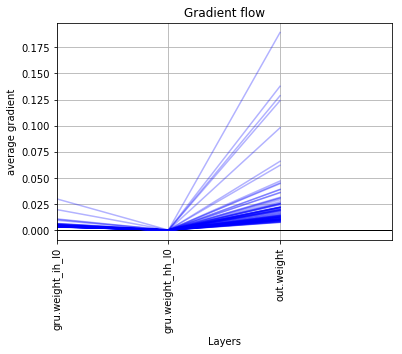

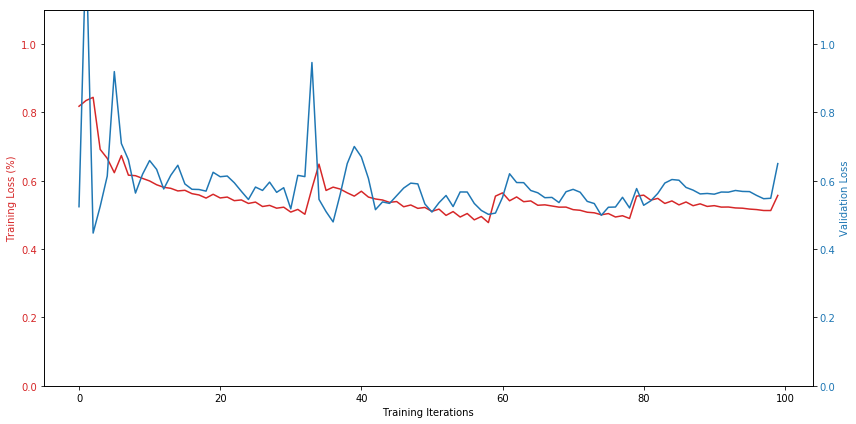

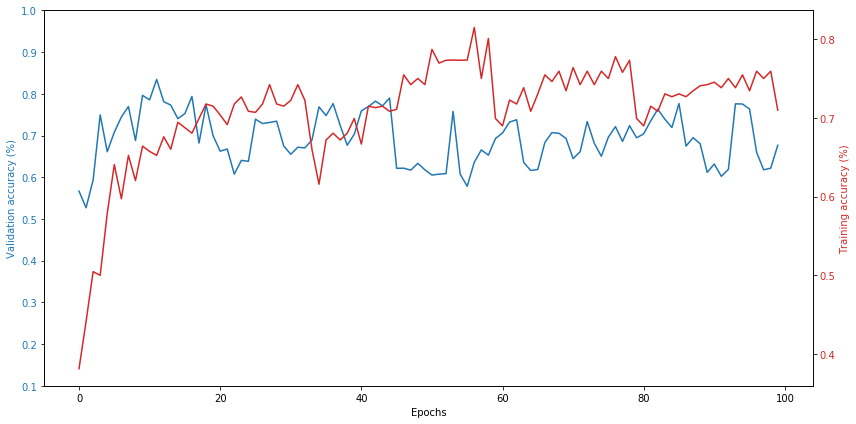

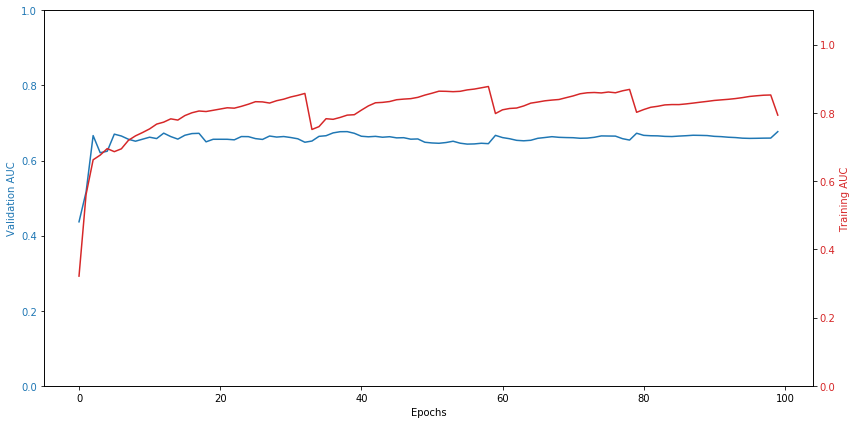

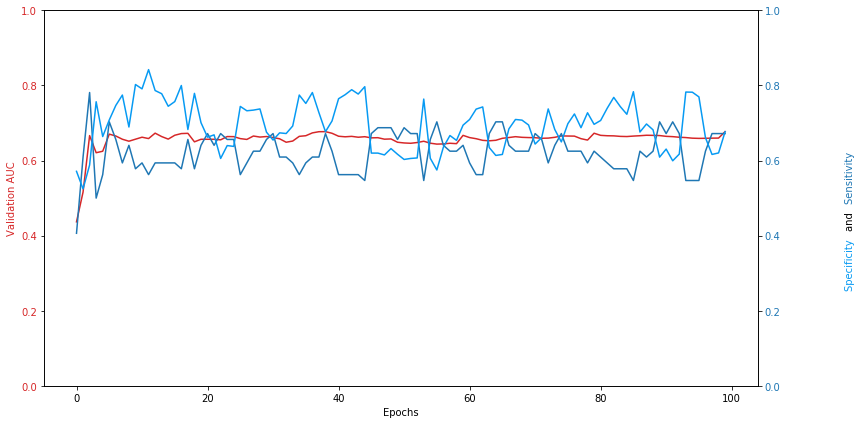


Fold  4
confused items in training set:  248
not_confused items in training set:  248
confused items in validation set:  68
not_confused items in validation set:  2244

Test confused items:

['58a_V-SortTwoFactors-14-1.pkl', '58a_V-SortTwoFactors-14-2.pkl', '58a_V-SortTwoFactors-14-3.pkl', '58a_V-SortTwoFactors-14-4.pkl', '58a_V-SortTwoFactors-23-1.pkl', '58a_V-SortTwoFactors-23-2.pkl', '58a_V-SortTwoFactors-23-3.pkl', '58a_V-SortTwoFactors-23-4.pkl', '58a_V-SortTwoFactors-6-1.pkl', '58a_V-SortTwoFactors-6-2.pkl', '58a_V-SortTwoFactors-6-3.pkl', '58a_V-SortTwoFactors-6-4.pkl', '86a_V-FE-10-1.pkl', '86a_V-FE-10-2.pkl', '86a_V-FE-10-3.pkl', '86a_V-FE-10-4.pkl', '86a_V-SortTwoFactors-4-1.pkl', '86a_V-SortTwoFactors-4-2.pkl', '86a_V-SortTwoFactors-4-3.pkl', '86a_V-SortTwoFactors-4-4.pkl', '86b_H-CDV-6-1.pkl', '86b_H-CDV-6-2.pkl', '86b_H-CDV-6-3.pkl', '86b_H-CDV-6-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 496
    Root Location: ./dataset/augmented/train3-1/
  

[epoch: 15, batches:     1] loss: 0.51402 | accuracy: 0.72656
[epoch: 15, batches:     2] loss: 0.44815 | accuracy: 0.79167
Training accuracy for epoch:  0.7591145833333333
validation accuracy:  0.634515570934256
validation loss:  0.6015645742416382
validation recall:  0.5735294117647058
validation specificity:  0.6363636363636364
validation AUC:  0.5702330397399602
Epochs without improvement:  4
[epoch: 16, batches:     1] loss: 0.50655 | accuracy: 0.73438
[epoch: 16, batches:     2] loss: 0.44438 | accuracy: 0.77500
Training accuracy for epoch:  0.7546875
validation accuracy:  0.6496539792387543
validation loss:  0.5584214687347412
validation recall:  0.5882352941176471
validation specificity:  0.6515151515151515
validation AUC:  0.5780971479500892
Epochs without improvement:  5
[epoch: 17, batches:     1] loss: 0.50748 | accuracy: 0.74219
[epoch: 17, batches:     2] loss: 0.43439 | accuracy: 0.78333
Training accuracy for epoch:  0.7627604166666666
validation accuracy:  0.66955017301

[epoch: 35, batches:     2] loss: 0.34496 | accuracy: 0.85000
Training accuracy for epoch:  0.83515625
validation accuracy:  0.7344290657439446
validation loss:  0.6340064316987991
validation recall:  0.5441176470588235
validation specificity:  0.7401960784313726
validation AUC:  0.5816949774562231
Epochs without improvement:  9
[epoch: 36, batches:     1] loss: 0.39628 | accuracy: 0.84375
[epoch: 36, batches:     2] loss: 0.34532 | accuracy: 0.85000
Training accuracy for epoch:  0.846875
validation accuracy:  0.7612456747404844
validation loss:  0.5531193315982819
validation recall:  0.5735294117647058
validation specificity:  0.7669340463458111
validation AUC:  0.5979605746041733
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.003
New learning rate: 0.0015
Validation AUC:  0.6069846387752963
Validation Loss:  0.5459781765937806
Epochs without improvement:  10
[epoch: 37, batches:     1] loss: 0.43251 | accuracy: 0.82812
[epoch: 37, batch

[epoch: 55, batches:     1] loss: 0.39942 | accuracy: 0.83984
[epoch: 55, batches:     2] loss: 0.33850 | accuracy: 0.84167
Training accuracy for epoch:  0.8407552083333334
validation accuracy:  0.7435121107266436
validation loss:  0.5363627761602402
validation recall:  0.5441176470588235
validation specificity:  0.749554367201426
validation AUC:  0.6015518506867987
Epochs without improvement:  29
[epoch: 56, batches:     1] loss: 0.39677 | accuracy: 0.83984
[epoch: 56, batches:     2] loss: 0.33448 | accuracy: 0.86250
Training accuracy for epoch:  0.851171875
validation accuracy:  0.7517301038062284
validation loss:  0.5311485022306442
validation recall:  0.5441176470588235
validation specificity:  0.7580213903743316
validation AUC:  0.6040224913494809
No decrease in validation loss in 30 epochs. Stopping training early.
Finished Training
validation accuracy:  0.7383217993079585
validation loss:  0.5459781765937806
validation recall:  0.5735294117647058
validation specificity:  0.7433

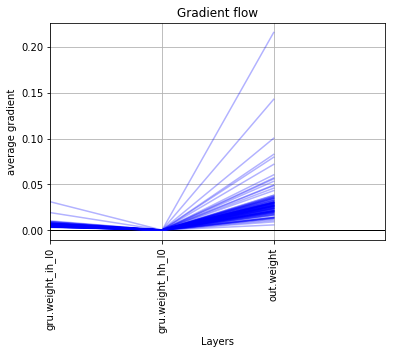

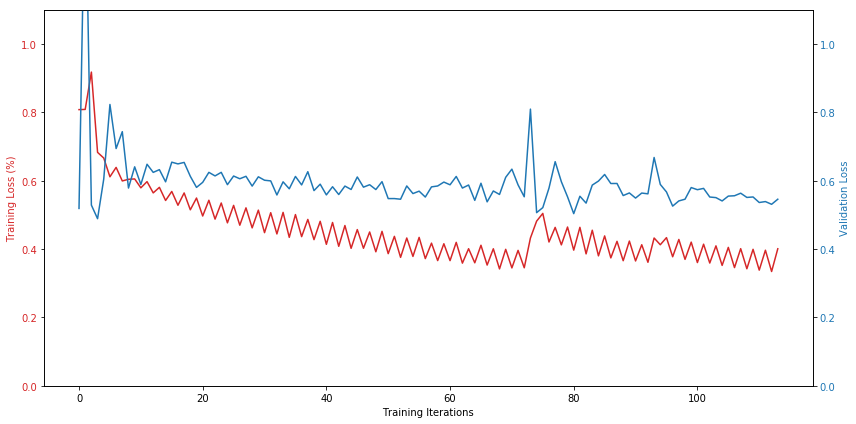

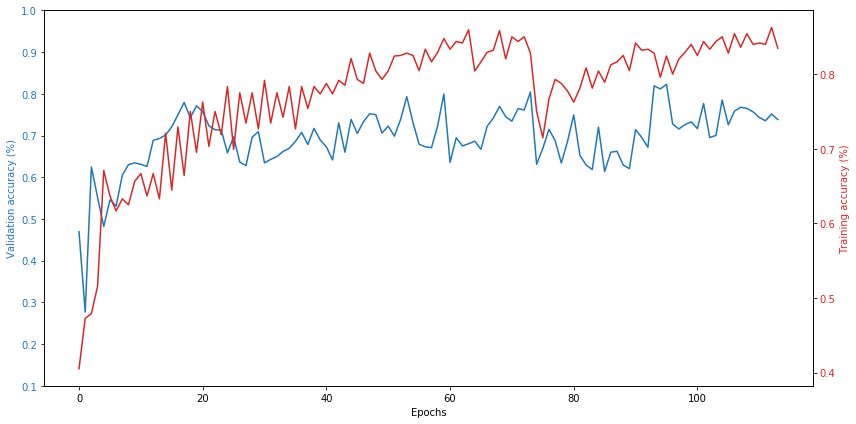

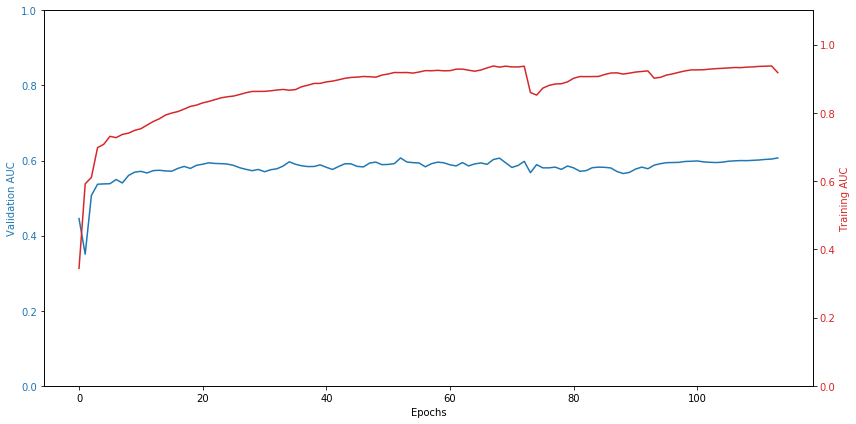

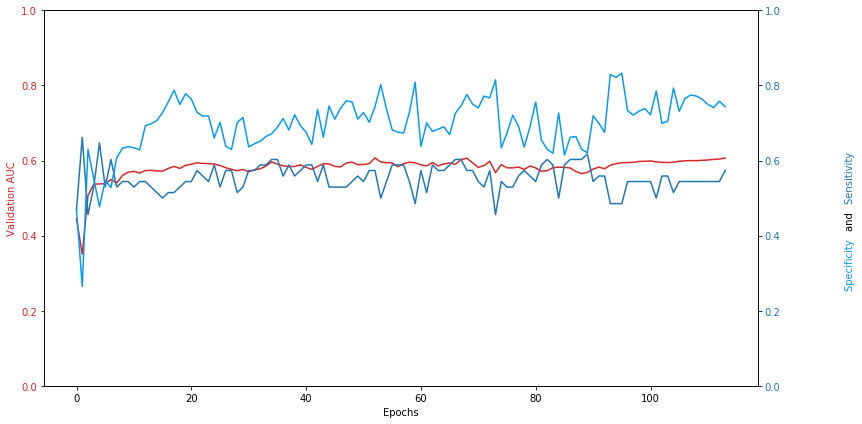


Fold  5
confused items in training set:  220
not_confused items in training set:  220
confused items in validation set:  96
not_confused items in validation set:  2196

Test confused items:

['122a_V-SortTwoFactors-4-1.pkl', '122a_V-SortTwoFactors-4-2.pkl', '122a_V-SortTwoFactors-4-3.pkl', '122a_V-SortTwoFactors-4-4.pkl', '142a_V-CDV-15-1.pkl', '142a_V-CDV-15-2.pkl', '142a_V-CDV-15-3.pkl', '142a_V-CDV-15-4.pkl', '142b_H-CDV-22-1.pkl', '142b_H-CDV-22-2.pkl', '142b_H-CDV-22-3.pkl', '142b_H-CDV-22-4.pkl', '25a_H-RV-22-1.pkl', '25a_H-RV-22-2.pkl', '25a_H-RV-22-3.pkl', '25a_H-RV-22-4.pkl', '32a_V-SortTwoFactors-11-1.pkl', '32a_V-SortTwoFactors-11-2.pkl', '32a_V-SortTwoFactors-11-3.pkl', '32a_V-SortTwoFactors-11-4.pkl', '82a_V-SortTwoFactors-4-1.pkl', '82a_V-SortTwoFactors-4-2.pkl', '82a_V-SortTwoFactors-4-3.pkl', '82a_V-SortTwoFactors-4-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 440
    Root Location: ./dataset/augmented/train3-1/
    Transforms (if any): None


[epoch: 16, batches:     1] loss: 0.50391 | accuracy: 0.73047
[epoch: 16, batches:     2] loss: 0.46279 | accuracy: 0.79348
Training accuracy for epoch:  0.7619735054347826
validation accuracy:  0.6121291448516579
validation loss:  0.6180471645461189
validation recall:  0.6458333333333334
validation specificity:  0.610655737704918
validation AUC:  0.6516678051001822
Epochs without improvement:  9
[epoch: 17, batches:     1] loss: 0.49601 | accuracy: 0.76172
[epoch: 17, batches:     2] loss: 0.45970 | accuracy: 0.79348
Training accuracy for epoch:  0.7775985054347826
validation accuracy:  0.62521815008726
validation loss:  0.6071332063939836
validation recall:  0.6041666666666666
validation specificity:  0.6261384335154827
validation AUC:  0.6512314055859137
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.003
New learning rate: 0.0015
Validation AUC:  0.6578532938676381
Validation Loss:  0.6302342745992873
Epochs without improvement:  10
[e

[epoch: 36, batches:     1] loss: 0.50157 | accuracy: 0.76953
[epoch: 36, batches:     2] loss: 0.46550 | accuracy: 0.79891
Training accuracy for epoch:  0.7842221467391304
validation accuracy:  0.7294938917975567
validation loss:  0.5927991370360056
validation recall:  0.5208333333333334
validation specificity:  0.738615664845173
validation AUC:  0.6345913023679417
Epochs without improvement:  8
[epoch: 37, batches:     1] loss: 0.49508 | accuracy: 0.75391
[epoch: 37, batches:     2] loss: 0.46239 | accuracy: 0.80435
Training accuracy for epoch:  0.7791270380434783
validation accuracy:  0.7116055846422339
validation loss:  0.5888129671414694
validation recall:  0.5416666666666666
validation specificity:  0.7190346083788707
validation AUC:  0.6363890786278081
Epochs without improvement:  9
[epoch: 38, batches:     1] loss: 0.48862 | accuracy: 0.77734
[epoch: 38, batches:     2] loss: 0.45941 | accuracy: 0.80978
Training accuracy for epoch:  0.7935631793478262
validation accuracy:  0.72

[epoch: 56, batches:     1] loss: 0.51410 | accuracy: 0.73047
[epoch: 56, batches:     2] loss: 0.48653 | accuracy: 0.79891
Training accuracy for epoch:  0.7646908967391304
validation accuracy:  0.7229493891797557
validation loss:  0.588577624824312
validation recall:  0.5520833333333334
validation specificity:  0.7304189435336976
validation AUC:  0.6431295537340619
Epochs without improvement:  28
[epoch: 57, batches:     1] loss: 0.51230 | accuracy: 0.74219
[epoch: 57, batches:     2] loss: 0.48485 | accuracy: 0.80978
Training accuracy for epoch:  0.7759850543478262
validation accuracy:  0.743891797556719
validation loss:  0.5887715551588271
validation recall:  0.5416666666666666
validation specificity:  0.7527322404371585
validation AUC:  0.6429777625986642
Epochs without improvement:  29
[epoch: 58, batches:     1] loss: 0.51087 | accuracy: 0.75000
[epoch: 58, batches:     2] loss: 0.48302 | accuracy: 0.81522
Training accuracy for epoch:  0.7826086956521738
validation accuracy:  0.7

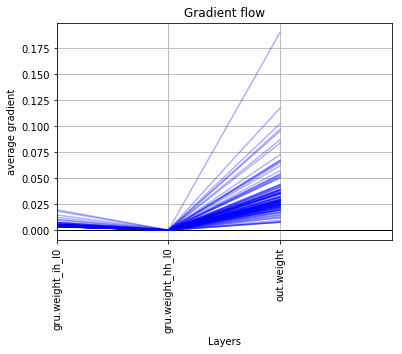

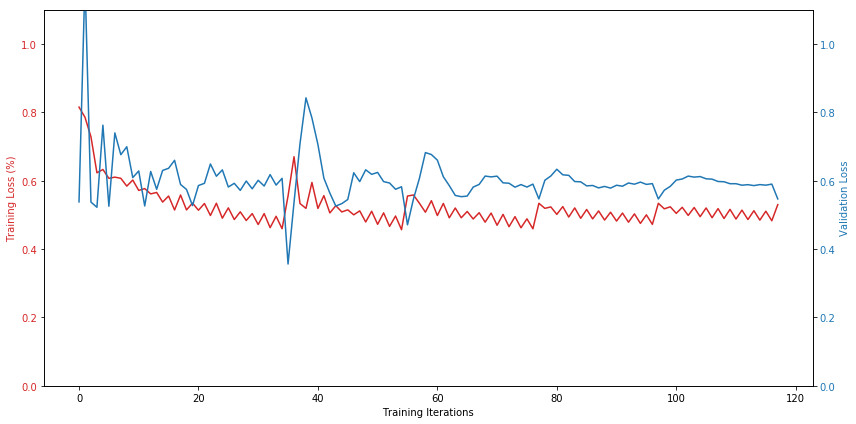

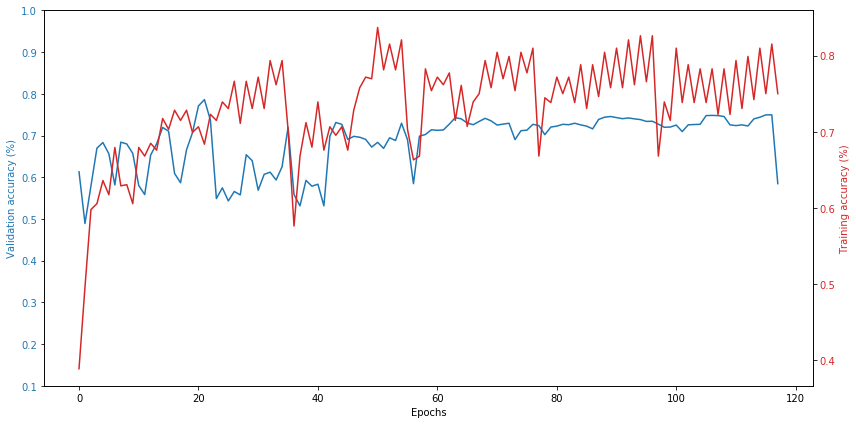

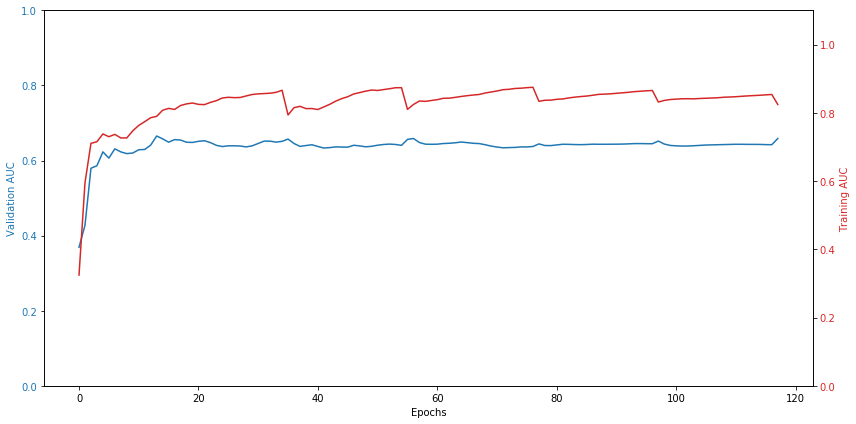

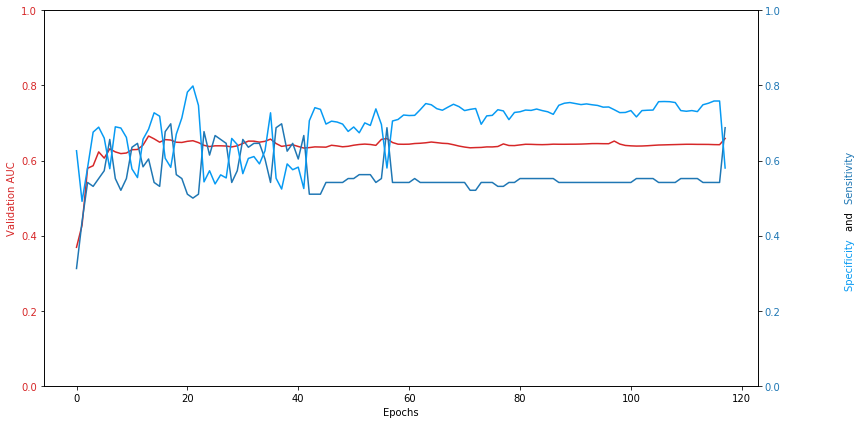


Fold  6
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  84
not_confused items in validation set:  2164

Test confused items:

['10a_V-CDV-2-1.pkl', '10a_V-CDV-2-2.pkl', '10a_V-CDV-2-3.pkl', '10a_V-CDV-2-4.pkl', '12b_H-CDV-5-1.pkl', '12b_H-CDV-5-2.pkl', '12b_H-CDV-5-3.pkl', '12b_H-CDV-5-4.pkl', '3a_H-SortTwoFactors-11-1.pkl', '3a_H-SortTwoFactors-11-2.pkl', '3a_H-SortTwoFactors-11-3.pkl', '3a_H-SortTwoFactors-11-4.pkl', '9a_H-SortTwoFactors-12-1.pkl', '9a_H-SortTwoFactors-12-2.pkl', '9a_H-SortTwoFactors-12-3.pkl', '9a_H-SortTwoFactors-12-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 480
    Root Location: ./dataset/augmented/train3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2248
    Root Location: ./dataset/augmented/val3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Test data:  Da

Validation AUC:  0.7089439750022006
Validation Loss:  0.6256233917342292
Epochs without improvement:  10
[epoch: 17, batches:     1] loss: 0.57761 | accuracy: 0.67578
[epoch: 17, batches:     2] loss: 0.67759 | accuracy: 0.61161
Training accuracy for epoch:  0.6436941964285714
validation accuracy:  0.7153024911032029
validation loss:  0.637795971499549
validation recall:  0.6904761904761905
validation specificity:  0.7162661737523105
validation AUC:  0.7091475222251563
Old best AUC:  0.7089439750022006
New best SUC:  0.7091475222251563
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 18, batches:     1] loss: 0.56703 | accuracy: 0.69922
[epoch: 18, batches:     2] loss: 0.57454 | accuracy: 0.65179
Training accuracy for epoch:  0.6755022321428572
validation accuracy:  0.733540925266904
validation loss:  0.5010027885437012
validation recall:  0.6547619047619048
validation specificity:  0.7365988909426987
validation AUC:  0.7203096118299446
Old best AUC:  0.7091475

[epoch: 36, batches:     1] loss: 0.51878 | accuracy: 0.75391
[epoch: 36, batches:     2] loss: 0.51406 | accuracy: 0.75446
Training accuracy for epoch:  0.7541852678571428
validation accuracy:  0.7370996441281139
validation loss:  0.5938954187764062
validation recall:  0.6904761904761905
validation specificity:  0.738909426987061
validation AUC:  0.7291336590088902
Epochs without improvement:  13
[epoch: 37, batches:     1] loss: 0.50272 | accuracy: 0.75781
[epoch: 37, batches:     2] loss: 0.50891 | accuracy: 0.75000
Training accuracy for epoch:  0.75390625
validation accuracy:  0.7504448398576512
validation loss:  0.6082219978173574
validation recall:  0.6666666666666666
validation specificity:  0.7536968576709797
validation AUC:  0.7256458498371622
Epochs without improvement:  14
[epoch: 38, batches:     1] loss: 0.49542 | accuracy: 0.78125
[epoch: 38, batches:     2] loss: 0.50038 | accuracy: 0.76339
Training accuracy for epoch:  0.7723214285714286
validation accuracy:  0.73887900

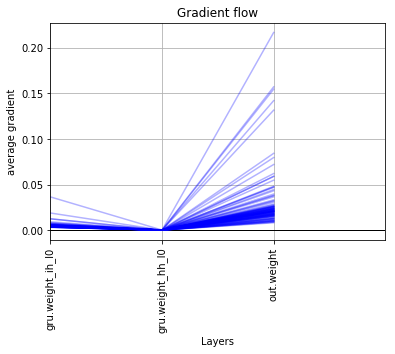

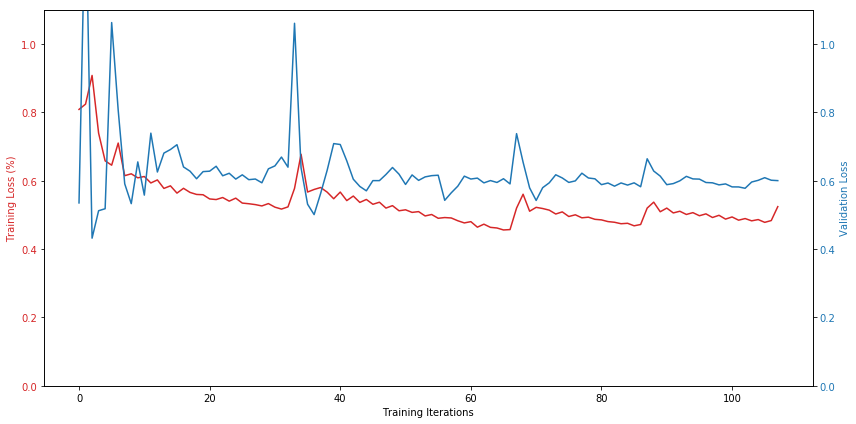

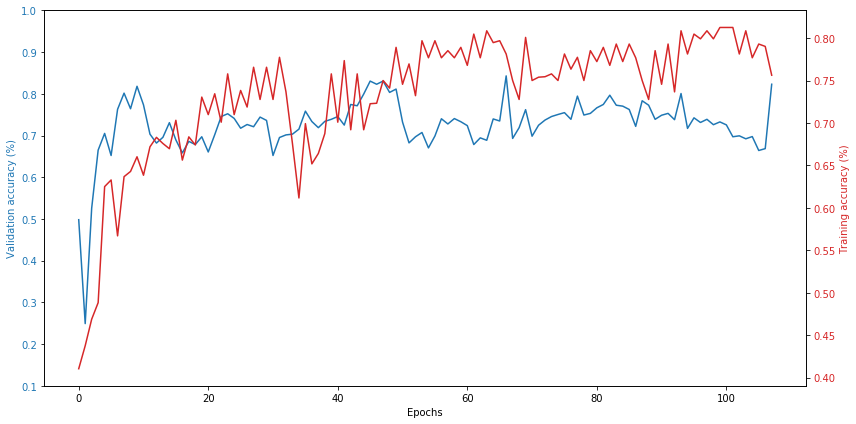

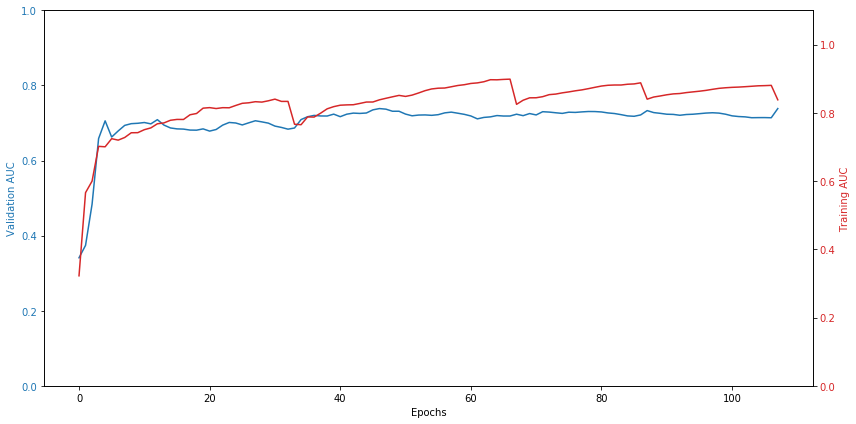

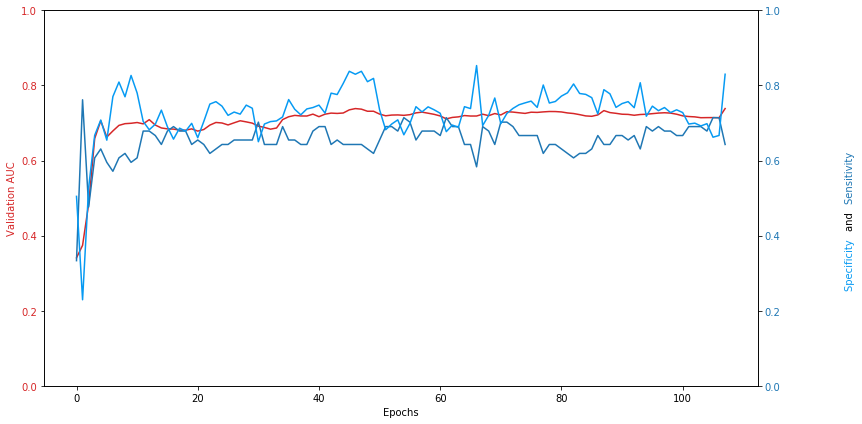


Fold  7
confused items in training set:  224
not_confused items in training set:  224
confused items in validation set:  72
not_confused items in validation set:  2040

Test confused items:

['105a_H-FE-17-1.pkl', '105a_H-FE-17-2.pkl', '105a_H-FE-17-3.pkl', '105a_H-FE-17-4.pkl', '105a_H-RV-22-1.pkl', '105a_H-RV-22-2.pkl', '105a_H-RV-22-3.pkl', '105a_H-RV-22-4.pkl', '105a_H-RV-8-1.pkl', '105a_H-RV-8-2.pkl', '105a_H-RV-8-3.pkl', '105a_H-RV-8-4.pkl', '105b_V-FE-20-1.pkl', '105b_V-FE-20-2.pkl', '105b_V-FE-20-3.pkl', '105b_V-FE-20-4.pkl', '105b_V-FE-8-1.pkl', '105b_V-FE-8-2.pkl', '105b_V-FE-8-3.pkl', '105b_V-FE-8-4.pkl', '105b_V-RV-5-1.pkl', '105b_V-RV-5-2.pkl', '105b_V-RV-5-3.pkl', '105b_V-RV-5-4.pkl', '134b_H-CDV-15-1.pkl', '134b_H-CDV-15-2.pkl', '134b_H-CDV-15-3.pkl', '134b_H-CDV-15-4.pkl', '134b_H-CDV-4-1.pkl', '134b_H-CDV-4-2.pkl', '134b_H-CDV-4-3.pkl', '134b_H-CDV-4-4.pkl', '50a_V-SortTwoFactors-22-1.pkl', '50a_V-SortTwoFactors-22-2.pkl', '50a_V-SortTwoFactors-22-3.pkl', '50a_V-SortT

[epoch: 16, batches:     1] loss: 0.56483 | accuracy: 0.67969
[epoch: 16, batches:     2] loss: 0.57108 | accuracy: 0.67708
Training accuracy for epoch:  0.6783854166666667
validation accuracy:  0.7395833333333334
validation loss:  0.556496176454756
validation recall:  0.5833333333333334
validation specificity:  0.7450980392156863
validation AUC:  0.6749999999999999
Epochs without improvement:  15
[epoch: 17, batches:     1] loss: 0.55264 | accuracy: 0.72266
[epoch: 17, batches:     2] loss: 0.56784 | accuracy: 0.66146
Training accuracy for epoch:  0.6920572916666667
validation accuracy:  0.837594696969697
validation loss:  0.6206367082066007
validation recall:  0.5694444444444444
validation specificity:  0.8470588235294118
validation AUC:  0.6816993464052288
Epochs without improvement:  16
[epoch: 18, batches:     1] loss: 0.53655 | accuracy: 0.71484
[epoch: 18, batches:     2] loss: 0.54231 | accuracy: 0.74479
Training accuracy for epoch:  0.7298177083333333
validation accuracy:  0.8

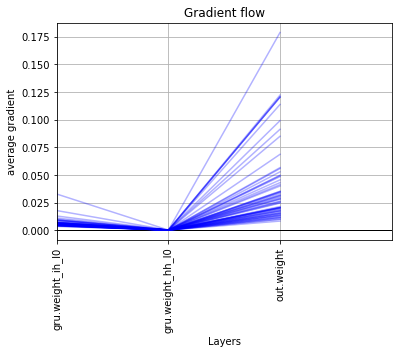

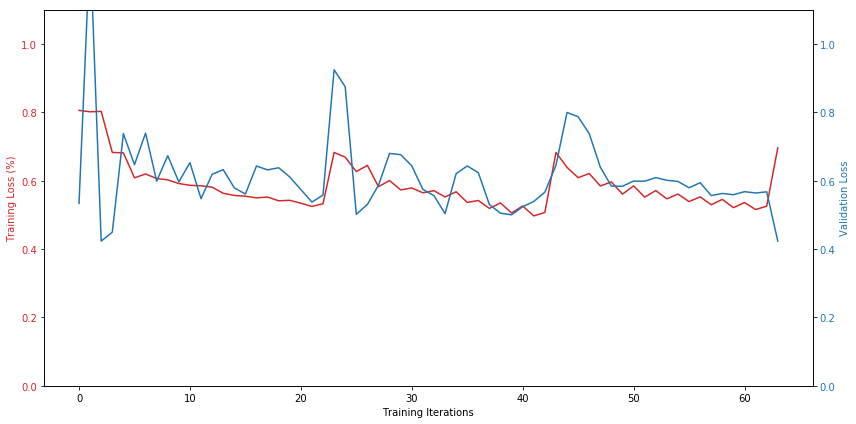

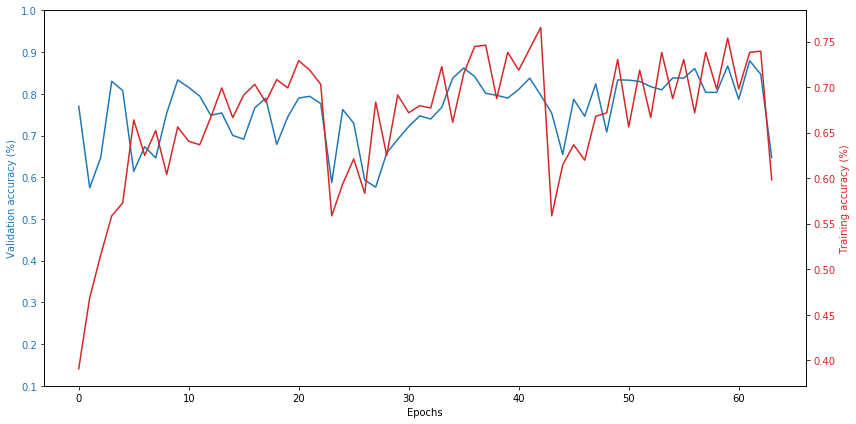

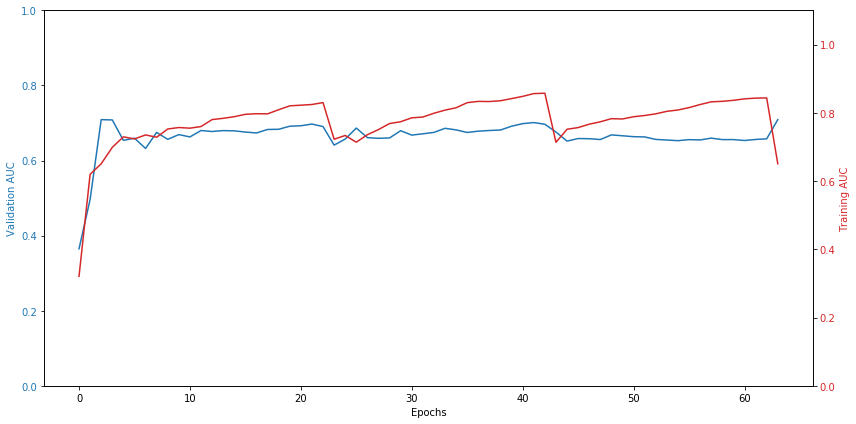

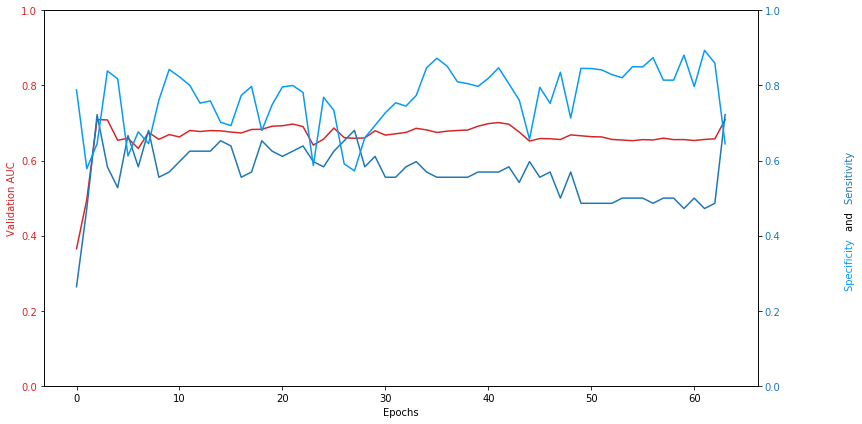


Fold  8
confused items in training set:  236
not_confused items in training set:  236
confused items in validation set:  68
not_confused items in validation set:  1964

Test confused items:

['121a_H-CDV-9-1.pkl', '121a_H-CDV-9-2.pkl', '121a_H-CDV-9-3.pkl', '121a_H-CDV-9-4.pkl', '121a_H-SortTwoFactors-20-1.pkl', '121a_H-SortTwoFactors-20-2.pkl', '121a_H-SortTwoFactors-20-3.pkl', '121a_H-SortTwoFactors-20-4.pkl', '121b_V-FE-2-1.pkl', '121b_V-FE-2-2.pkl', '121b_V-FE-2-3.pkl', '121b_V-FE-2-4.pkl', '121b_V-SortTwoFactors-11-1.pkl', '121b_V-SortTwoFactors-11-2.pkl', '121b_V-SortTwoFactors-11-3.pkl', '121b_V-SortTwoFactors-11-4.pkl', '129b_V-SortTwoFactors-23-1.pkl', '129b_V-SortTwoFactors-23-2.pkl', '129b_V-SortTwoFactors-23-3.pkl', '129b_V-SortTwoFactors-23-4.pkl', '141a_H-RV-18-1.pkl', '141a_H-RV-18-2.pkl', '141a_H-RV-18-3.pkl', '141a_H-RV-18-4.pkl', '141a_H-SortTwoFactors-22-1.pkl', '141a_H-SortTwoFactors-22-2.pkl', '141a_H-SortTwoFactors-22-3.pkl', '141a_H-SortTwoFactors-22-4.pkl', '55

[epoch: 15, batches:     1] loss: 0.46405 | accuracy: 0.77344
[epoch: 15, batches:     2] loss: 0.45368 | accuracy: 0.81944
Training accuracy for epoch:  0.7964409722222222
validation accuracy:  0.656496062992126
validation loss:  0.5354936867952347
validation recall:  0.5441176470588235
validation specificity:  0.6603869653767821
validation AUC:  0.5754088295195878
Epochs without improvement:  1
[epoch: 16, batches:     1] loss: 0.45971 | accuracy: 0.79297
[epoch: 16, batches:     2] loss: 0.45871 | accuracy: 0.77778
Training accuracy for epoch:  0.7853732638888888
validation accuracy:  0.7436023622047244
validation loss:  0.5648230277001858
validation recall:  0.45588235294117646
validation specificity:  0.7535641547861507
validation AUC:  0.5663861267521265
Epochs without improvement:  2
[epoch: 17, batches:     1] loss: 0.44982 | accuracy: 0.78906
[epoch: 17, batches:     2] loss: 0.44680 | accuracy: 0.76852
Training accuracy for epoch:  0.7787905092592593
validation accuracy:  0.6

[epoch: 35, batches:     1] loss: 0.42079 | accuracy: 0.83594
[epoch: 35, batches:     2] loss: 0.41339 | accuracy: 0.81481
Training accuracy for epoch:  0.8253761574074074
validation accuracy:  0.7037401574803149
validation loss:  0.5198608674108982
validation recall:  0.5147058823529411
validation specificity:  0.710285132382892
validation AUC:  0.567337067209776
Epochs without improvement:  3
[epoch: 36, batches:     1] loss: 0.41537 | accuracy: 0.84375
[epoch: 36, batches:     2] loss: 0.40802 | accuracy: 0.81019
Training accuracy for epoch:  0.8269675925925926
validation accuracy:  0.6840551181102362
validation loss:  0.5440922416746616
validation recall:  0.5
validation specificity:  0.6904276985743381
validation AUC:  0.5644168563555769
Epochs without improvement:  4
[epoch: 37, batches:     1] loss: 0.40689 | accuracy: 0.85547
[epoch: 37, batches:     2] loss: 0.40333 | accuracy: 0.82407
Training accuracy for epoch:  0.839771412037037
validation accuracy:  0.6732283464566929
va

[epoch: 55, batches:     1] loss: 0.41590 | accuracy: 0.82812
[epoch: 55, batches:     2] loss: 0.42206 | accuracy: 0.81944
Training accuracy for epoch:  0.8237847222222222
validation accuracy:  0.7249015748031497
validation loss:  0.51874815300107
validation recall:  0.5294117647058824
validation specificity:  0.7316700610997964
validation AUC:  0.5723837905834431
Epochs without improvement:  23
[epoch: 56, batches:     1] loss: 0.41263 | accuracy: 0.84766
[epoch: 56, batches:     2] loss: 0.41819 | accuracy: 0.81481
Training accuracy for epoch:  0.8312355324074074
validation accuracy:  0.718996062992126
validation loss:  0.552174024283886
validation recall:  0.5294117647058824
validation specificity:  0.7255600814663951
validation AUC:  0.5717398466514916
Epochs without improvement:  24
[epoch: 57, batches:     1] loss: 0.40747 | accuracy: 0.83984
[epoch: 57, batches:     2] loss: 0.41639 | accuracy: 0.81019
Training accuracy for epoch:  0.8250144675925926
validation accuracy:  0.720

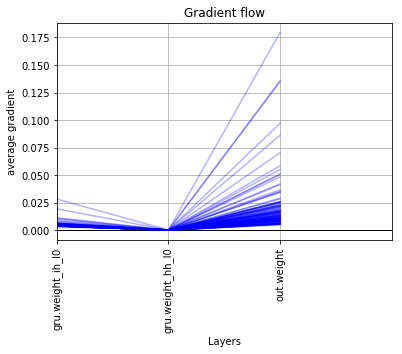

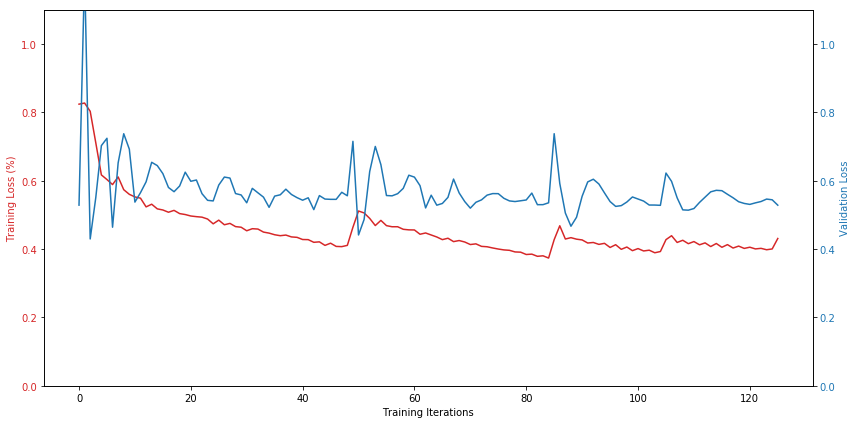

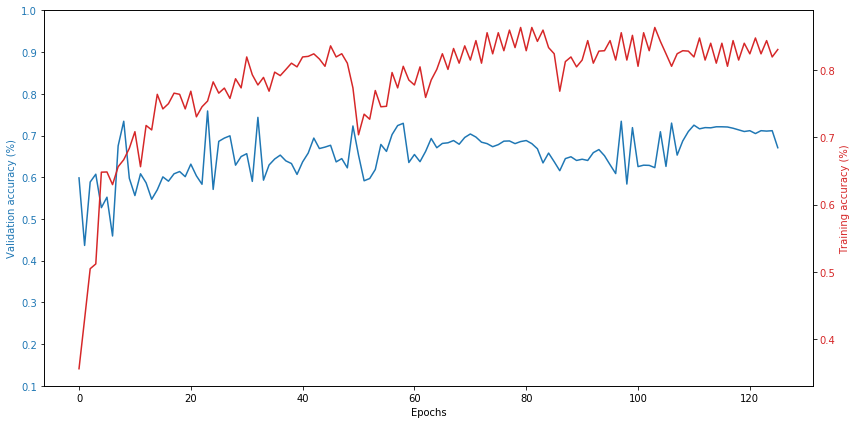

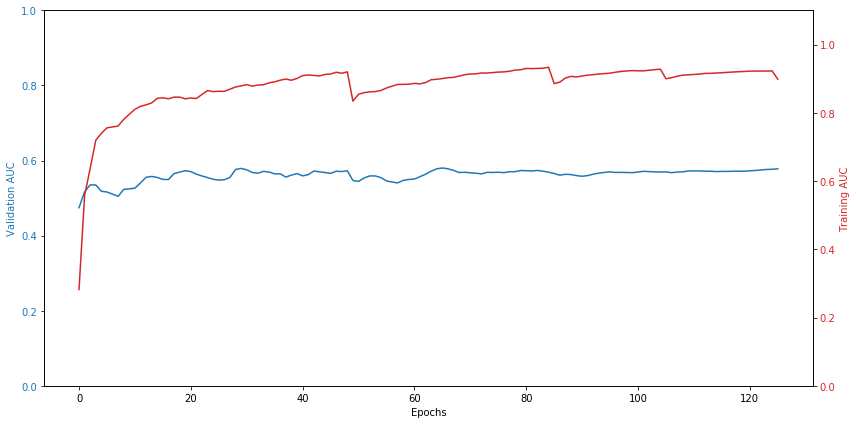

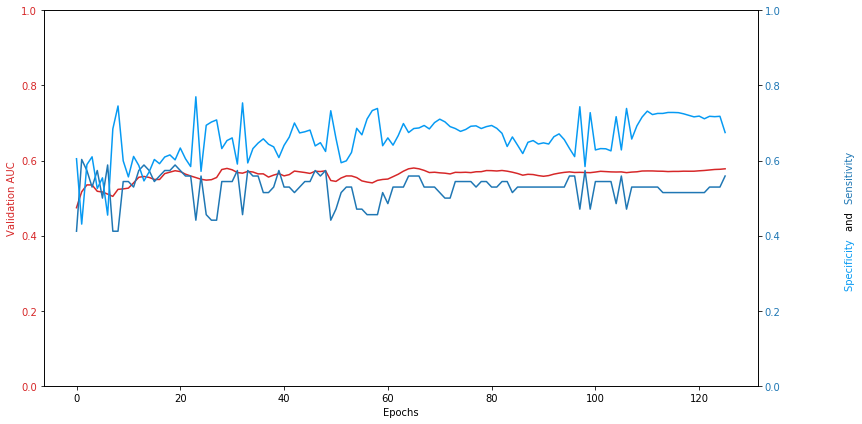


Fold  9
confused items in training set:  268
not_confused items in training set:  268
confused items in validation set:  56
not_confused items in validation set:  2388

Test confused items:

['103a_H-CDV-12-1.pkl', '103a_H-CDV-12-2.pkl', '103a_H-CDV-12-3.pkl', '103a_H-CDV-12-4.pkl', '103a_H-CDV-17-1.pkl', '103a_H-CDV-17-2.pkl', '103a_H-CDV-17-3.pkl', '103a_H-CDV-17-4.pkl', '11a_H-SortTwoFactors-5-1.pkl', '11a_H-SortTwoFactors-5-2.pkl', '11a_H-SortTwoFactors-5-3.pkl', '11a_H-SortTwoFactors-5-4.pkl', '143a_H-CDV-17-1.pkl', '143a_H-CDV-17-2.pkl', '143a_H-CDV-17-3.pkl', '143a_H-CDV-17-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 536
    Root Location: ./dataset/augmented/train3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2444
    Root Location: ./dataset/augmented/val3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Test data:  Dataset DatasetFolder


[epoch: 14, batches:     1] loss: 0.50036 | accuracy: 0.71875
[epoch: 14, batches:     2] loss: 0.52852 | accuracy: 0.69922
[epoch: 14, batches:     3] loss: 0.47679 | accuracy: 0.79167
Training accuracy for epoch:  0.7365451388888888
validation accuracy:  0.5094108019639935
validation loss:  0.5704491198062897
validation recall:  0.7678571428571429
validation specificity:  0.5033500837520938
validation AUC:  0.6377497607083034
Epochs without improvement:  4
[epoch: 15, batches:     1] loss: 0.50217 | accuracy: 0.71094
[epoch: 15, batches:     2] loss: 0.51802 | accuracy: 0.68750
[epoch: 15, batches:     3] loss: 0.47147 | accuracy: 0.75000
Training accuracy for epoch:  0.7161458333333334
validation accuracy:  0.6563011456628478
validation loss:  0.6548708379268646
validation recall:  0.6071428571428571
validation specificity:  0.6574539363484088
validation AUC:  0.6401800670016751
Epochs without improvement:  5
[epoch: 16, batches:     1] loss: 0.48982 | accuracy: 0.75781
[epoch: 16, 

[epoch: 31, batches:     1] loss: 0.51314 | accuracy: 0.71484
[epoch: 31, batches:     2] loss: 0.53026 | accuracy: 0.66016
[epoch: 31, batches:     3] loss: 0.50803 | accuracy: 0.66667
Training accuracy for epoch:  0.6805555555555555
validation accuracy:  0.5994271685761048
validation loss:  0.6267257690429687
validation recall:  0.7678571428571429
validation specificity:  0.5954773869346733
validation AUC:  0.641413914812156
Epochs without improvement:  21
[epoch: 32, batches:     1] loss: 0.49586 | accuracy: 0.72266
[epoch: 32, batches:     2] loss: 0.52359 | accuracy: 0.70312
[epoch: 32, batches:     3] loss: 0.46973 | accuracy: 0.75000
Training accuracy for epoch:  0.7252604166666666
validation accuracy:  0.6648936170212766
validation loss:  0.5496498018503189
validation recall:  0.6428571428571429
validation specificity:  0.6654103852596315
validation AUC:  0.6495124431682221
Epochs without improvement:  22
[epoch: 33, batches:     1] loss: 0.49868 | accuracy: 0.71484
[epoch: 33,

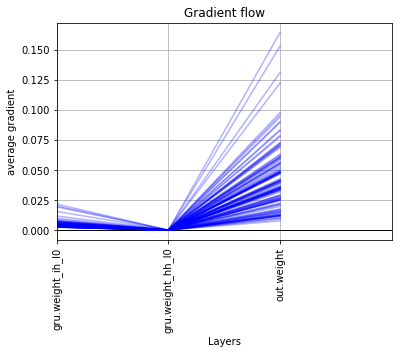

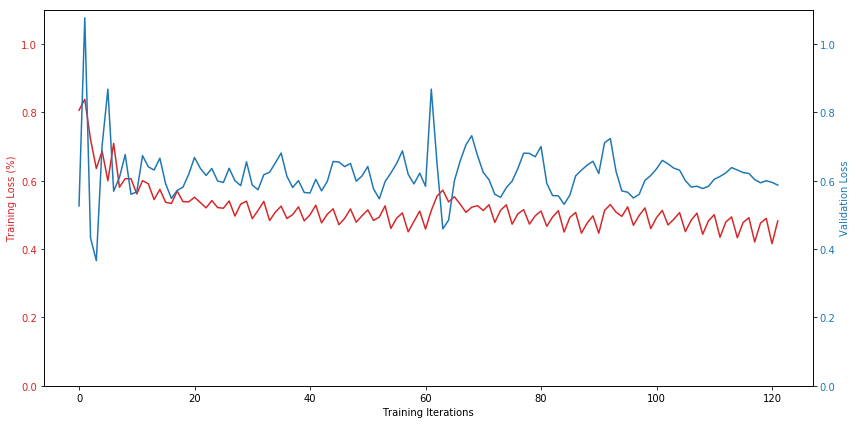

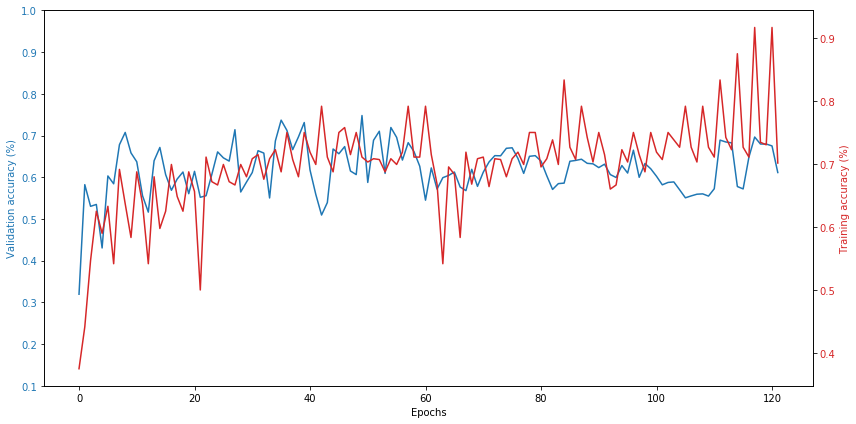

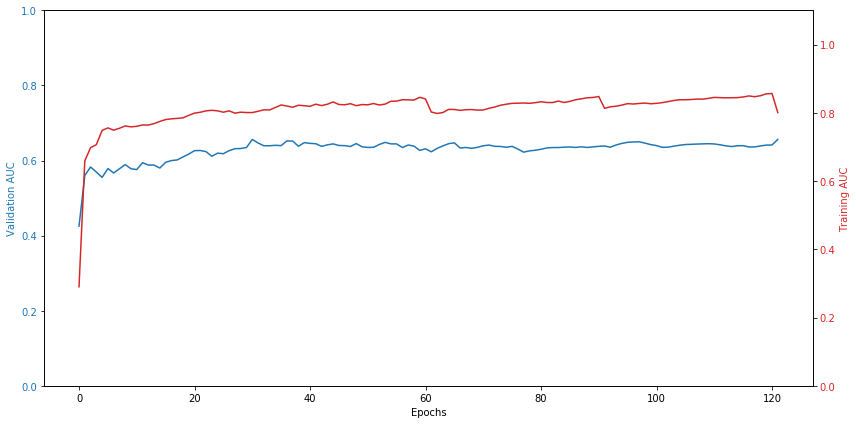

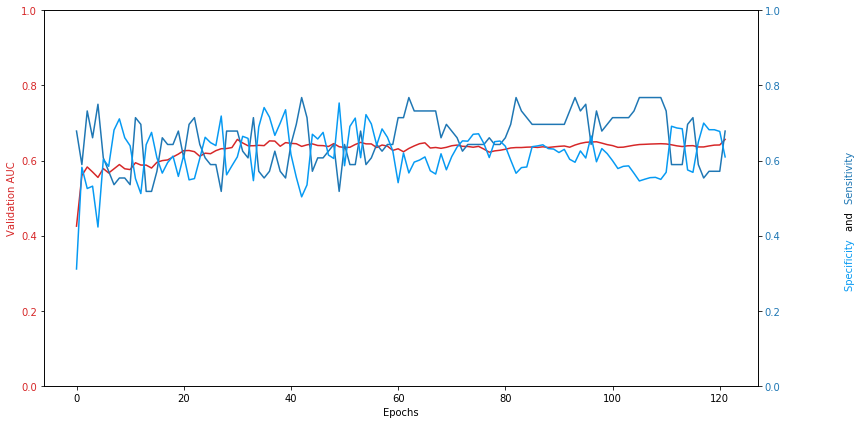


Fold  10
confused items in training set:  212
not_confused items in training set:  212
confused items in validation set:  76
not_confused items in validation set:  2300

Test confused items:

['112a_V-SortTwoFactors-5-1.pkl', '112a_V-SortTwoFactors-5-2.pkl', '112a_V-SortTwoFactors-5-3.pkl', '112a_V-SortTwoFactors-5-4.pkl', '114a_V-SortTwoFactors-12-1.pkl', '114a_V-SortTwoFactors-12-2.pkl', '114a_V-SortTwoFactors-12-3.pkl', '114a_V-SortTwoFactors-12-4.pkl', '130a_V-RV-10-1.pkl', '130a_V-RV-10-2.pkl', '130a_V-RV-10-3.pkl', '130a_V-RV-10-4.pkl', '35a_H-SortTwoFactors-15-1.pkl', '35a_H-SortTwoFactors-15-2.pkl', '35a_H-SortTwoFactors-15-3.pkl', '35a_H-SortTwoFactors-15-4.pkl', '35a_H-SortTwoFactors-22-1.pkl', '35a_H-SortTwoFactors-22-2.pkl', '35a_H-SortTwoFactors-22-3.pkl', '35a_H-SortTwoFactors-22-4.pkl', '35a_H-SortTwoFactors-4-1.pkl', '35a_H-SortTwoFactors-4-2.pkl', '35a_H-SortTwoFactors-4-3.pkl', '35a_H-SortTwoFactors-4-4.pkl', '39a_H-SortTwoFactors-10-1.pkl', '39a_H-SortTwoFactors-10-

[epoch: 13, batches:     1] loss: 0.50560 | accuracy: 0.76562
[epoch: 13, batches:     2] loss: 0.49114 | accuracy: 0.78571
Training accuracy for epoch:  0.7756696428571428
validation accuracy:  0.6477272727272727
validation loss:  0.5521888732910156
validation recall:  0.6052631578947368
validation specificity:  0.6491304347826087
validation AUC:  0.6199656750572082
Epochs without improvement:  1
[epoch: 14, batches:     1] loss: 0.49870 | accuracy: 0.75391
[epoch: 14, batches:     2] loss: 0.47638 | accuracy: 0.78571
Training accuracy for epoch:  0.7698102678571428
validation accuracy:  0.6241582491582491
validation loss:  0.654952198266983
validation recall:  0.618421052631579
validation specificity:  0.6243478260869565
validation AUC:  0.6333695652173913
Old best AUC:  0.6260640732265446
New best SUC:  0.6333695652173913
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 15, batches:     1] loss: 0.48691 | accuracy: 0.76953
[epoch: 15, batches:     2] loss: 0.

[epoch: 33, batches:     1] loss: 0.44640 | accuracy: 0.83203
[epoch: 33, batches:     2] loss: 0.41605 | accuracy: 0.84524
Training accuracy for epoch:  0.8386346726190477
validation accuracy:  0.6106902356902357
validation loss:  0.5647870481014252
validation recall:  0.6578947368421053
validation specificity:  0.6091304347826086
validation AUC:  0.6142848970251716
Epochs without improvement:  18
[epoch: 34, batches:     1] loss: 0.43820 | accuracy: 0.82031
[epoch: 34, batches:     2] loss: 0.40632 | accuracy: 0.82738
Training accuracy for epoch:  0.8238467261904762
validation accuracy:  0.5997474747474747
validation loss:  0.6428489983081818
validation recall:  0.6578947368421053
validation specificity:  0.5978260869565217
validation AUC:  0.6117562929061785
Epochs without improvement:  19
[epoch: 35, batches:     1] loss: 0.43345 | accuracy: 0.78906
[epoch: 35, batches:     2] loss: 0.39979 | accuracy: 0.84524
Training accuracy for epoch:  0.8171502976190477
validation accuracy:  0

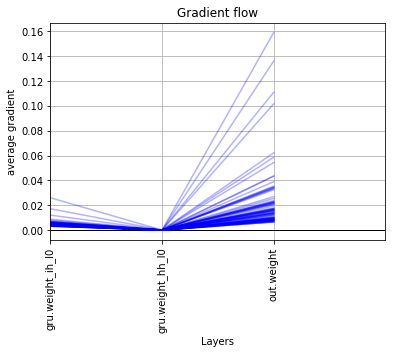

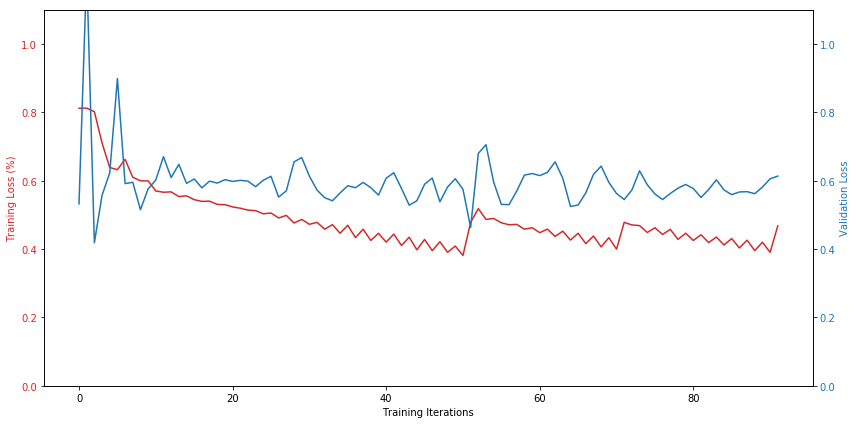

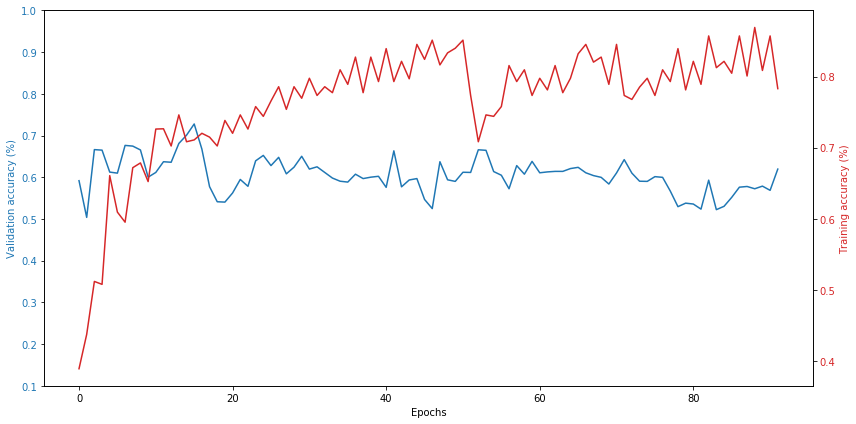

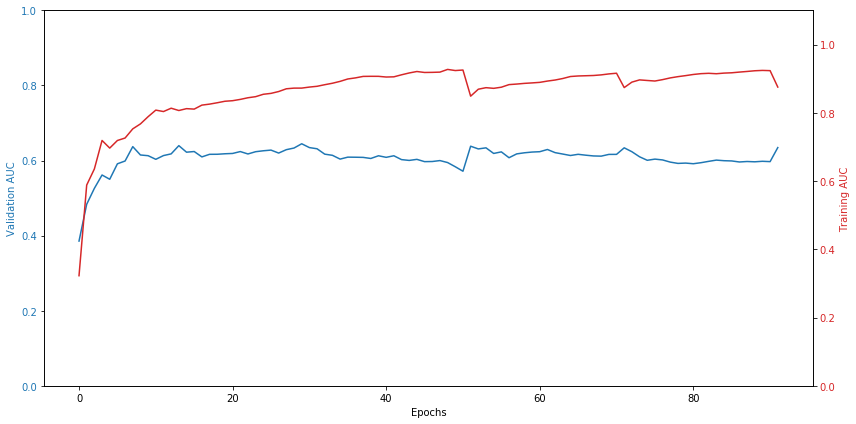

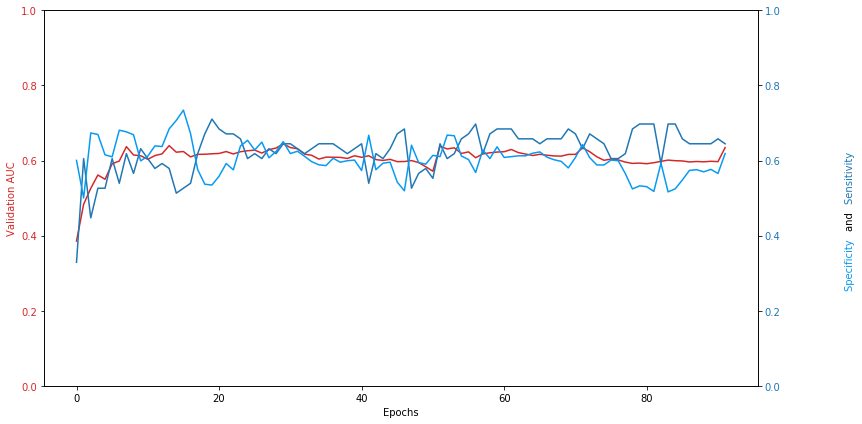


10-fold CV accuracy: 0.672139
10-fold CV sensitivity: 0.653503 
10-fold CV specificity: 0.672805 
10-fold CV AUC: 0.660976 

10-fold test accuracy: 0.654057
10-fold test sensitivity: 0.608275 
10-fold test specificity: 0.654862 
10-fold test AUC: 0.654742 


([0.5796064400715564,
  0.7702479338842976,
  0.6767764298093587,
  0.7383217993079585,
  0.5846422338568935,
  0.8229537366548043,
  0.6472537878787878,
  0.6707677165354331,
  0.6112929623567921,
  0.6195286195286195],
 [0.640625,
  0.7142857142857143,
  0.671875,
  0.5735294117647058,
  0.6875,
  0.6428571428571429,
  0.7222222222222222,
  0.5588235294117647,
  0.6785714285714286,
  0.6447368421052632],
 [0.5778084714548803,
  0.7722602739726028,
  0.6769162210338681,
  0.7433155080213903,
  0.5801457194899818,
  0.8299445471349353,
  0.6446078431372549,
  0.674643584521385,
  0.609715242881072,
  0.6186956521739131],
 [0.5984979281767956,
  0.7520231979778214,
  0.6770624442959002,
  0.6069846387752963,
  0.6587640406800244,
  0.7384913299885574,
  0.7090073529411766,
  0.578051994728645,
  0.6563098229241445,
  0.634570938215103],
 [0.5171339563862928,
  0.7632398753894081,
  0.7320872274143302,
  0.7671339563862928,
  0.5794392523364486,
  0.7220496894409938,
  0.6409657320872274

In [10]:
# monitoring validation AUC
np.random.seed(MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

cross_validate(model_type='gru',
                   folds=10,
                   epochs=300,
                   criterion_type='NLLLoss',
                   optimizer_type='Adam',
                   confused_path='./dataset/augmented/confused_highly_valid/',
                   not_confused_path='./dataset/augmented/not_confused_highly_valid/',
                   print_every=1,
                   plot_every=1,
                   hidden_size=HIDDEN_SIZE,
                   num_layers=1,
                   early_stopping=True,
                   early_stopping_metric='val_auc',
                   early_stopping_patience=30,
                   rate_decay=True,
                   rate_decay_patience=10,
                   initial_learning_rate=0.003,
                   verbose=True)


Fold  1
confused items in training set:  220
not_confused items in training set:  220
confused items in validation set:  64
not_confused items in validation set:  2172

Test confused items:

['131a_H-CDV-5-1.pkl', '131a_H-CDV-5-2.pkl', '131a_H-CDV-5-3.pkl', '131a_H-CDV-5-4.pkl', '131a_H-SortTwoFactors-12-1.pkl', '131a_H-SortTwoFactors-12-2.pkl', '131a_H-SortTwoFactors-12-3.pkl', '131a_H-SortTwoFactors-12-4.pkl', '131b_V-SortTwoFactors-21-1.pkl', '131b_V-SortTwoFactors-21-2.pkl', '131b_V-SortTwoFactors-21-3.pkl', '131b_V-SortTwoFactors-21-4.pkl', '132a_V-CDV-2-1.pkl', '132a_V-CDV-2-2.pkl', '132a_V-CDV-2-3.pkl', '132a_V-CDV-2-4.pkl', '132a_V-SortOverall-21-1.pkl', '132a_V-SortOverall-21-2.pkl', '132a_V-SortOverall-21-3.pkl', '132a_V-SortOverall-21-4.pkl', '132a_V-SortOverall-9-1.pkl', '132a_V-SortOverall-9-2.pkl', '132a_V-SortOverall-9-3.pkl', '132a_V-SortOverall-9-4.pkl', '132a_V-SortTwoFactors-6-1.pkl', '132a_V-SortTwoFactors-6-2.pkl', '132a_V-SortTwoFactors-6-3.pkl', '132a_V-SortTwoF

[epoch: 14, batches:     2] loss: 0.51698 | accuracy: 0.75000
Training accuracy for epoch:  0.755859375
validation accuracy:  0.565742397137746
validation loss:  0.6022134522596995
validation recall:  0.578125
validation specificity:  0.565377532228361
validation AUC:  0.5173766977440147
Epochs without improvement:  1
[epoch: 15, batches:     1] loss: 0.52802 | accuracy: 0.75391
[epoch: 15, batches:     2] loss: 0.51077 | accuracy: 0.75000
Training accuracy for epoch:  0.751953125
validation accuracy:  0.6024150268336315
validation loss:  0.6259142359097799
validation recall:  0.546875
validation specificity:  0.6040515653775322
validation AUC:  0.5178982504604053
Epochs without improvement:  2
[epoch: 16, batches:     1] loss: 0.52679 | accuracy: 0.74609
[epoch: 16, batches:     2] loss: 0.50432 | accuracy: 0.74457
Training accuracy for epoch:  0.7453294836956521
validation accuracy:  0.5930232558139535
validation loss:  0.6314036183887057
validation recall:  0.5625
validation specifi

Training accuracy for epoch:  0.7232506793478262
validation accuracy:  0.6086762075134168
validation loss:  0.5448364317417145
validation recall:  0.578125
validation specificity:  0.6095764272559853
validation AUC:  0.5309046961325967
Old best AUC:  0.5253042990331491
New best SUC:  0.5309046961325967
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 35, batches:     1] loss: 0.52107 | accuracy: 0.75000
[epoch: 35, batches:     2] loss: 0.51118 | accuracy: 0.72826
Training accuracy for epoch:  0.7391304347826086
validation accuracy:  0.6453488372093024
validation loss:  0.6901260614395142
validation recall:  0.453125
validation specificity:  0.651012891344383
validation AUC:  0.4870367173112339
Epochs without improvement:  1
[epoch: 36, batches:     1] loss: 0.54309 | accuracy: 0.72266
[epoch: 36, batches:     2] loss: 0.50874 | accuracy: 0.72283
Training accuracy for epoch:  0.7227411684782609
validation accuracy:  0.6118067978533095
validation loss:  0.6810333

Validation AUC:  0.5309046961325967
Validation Loss:  0.5448364317417145
Epochs without improvement:  20
[epoch: 55, batches:     1] loss: 0.52107 | accuracy: 0.75000
[epoch: 55, batches:     2] loss: 0.51504 | accuracy: 0.74457
Training accuracy for epoch:  0.7472826086956521
validation accuracy:  0.5957066189624329
validation loss:  0.5812006857660081
validation recall:  0.59375
validation specificity:  0.5957642725598526
validation AUC:  0.5265955916206263
Epochs without improvement:  21
[epoch: 56, batches:     1] loss: 0.51770 | accuracy: 0.75781
[epoch: 56, batches:     2] loss: 0.50493 | accuracy: 0.73370
Training accuracy for epoch:  0.7457540760869565
validation accuracy:  0.6198568872987478
validation loss:  0.6036470135052999
validation recall:  0.5625
validation specificity:  0.6215469613259669
validation AUC:  0.5236820902394107
Epochs without improvement:  22
[epoch: 57, batches:     1] loss: 0.52001 | accuracy: 0.75000
[epoch: 57, batches:     2] loss: 0.50101 | accuracy

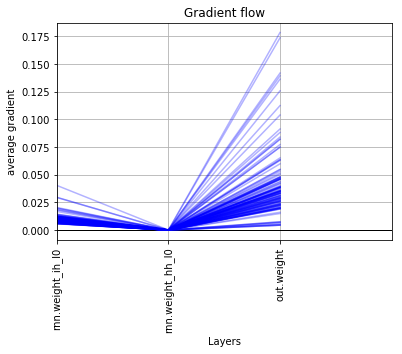

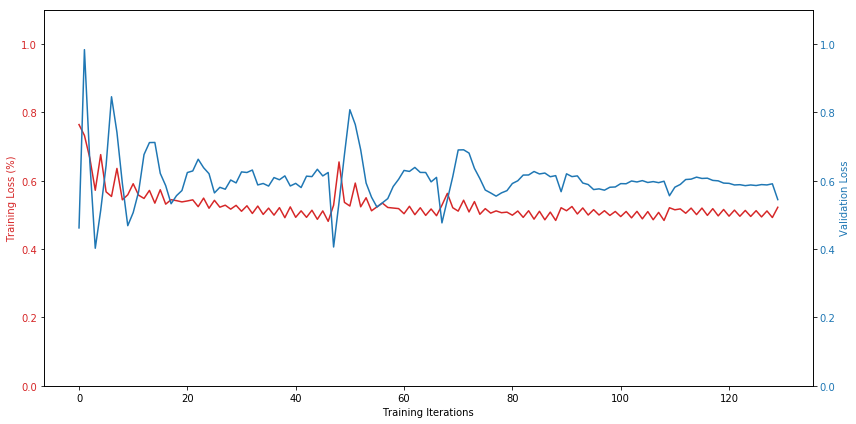

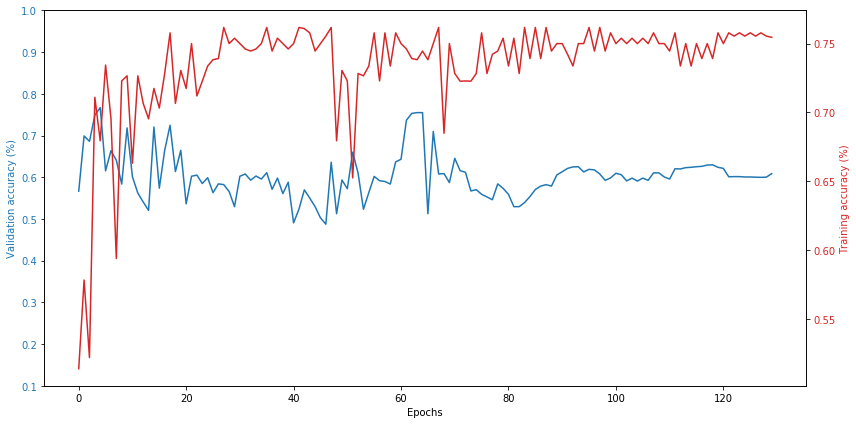

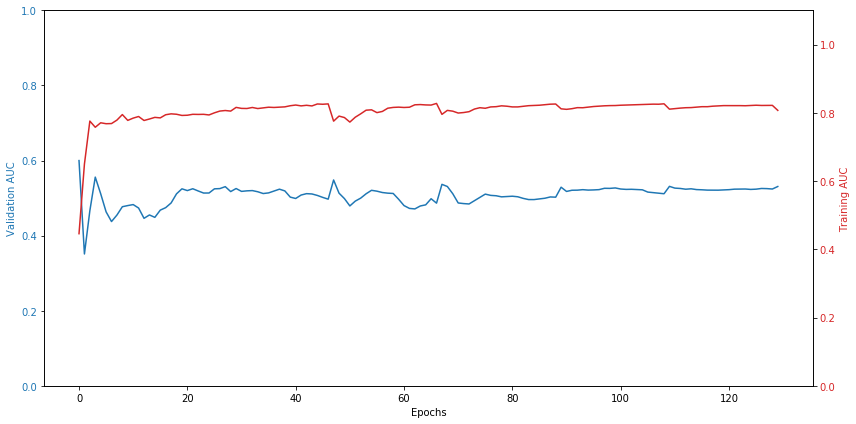

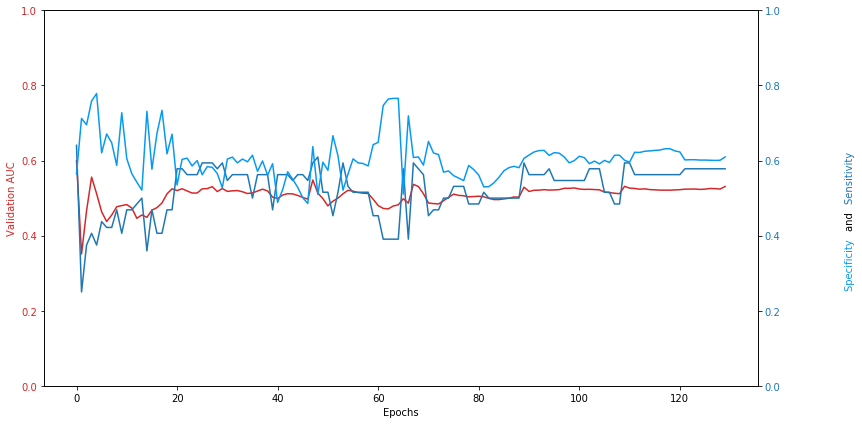


Fold  2
confused items in training set:  224
not_confused items in training set:  224
confused items in validation set:  84
not_confused items in validation set:  2336

Test confused items:

['126a_V-SortTwoFactors-6-1.pkl', '126a_V-SortTwoFactors-6-2.pkl', '126a_V-SortTwoFactors-6-3.pkl', '126a_V-SortTwoFactors-6-4.pkl', '133a_H-CDV-16-1.pkl', '133a_H-CDV-16-2.pkl', '133a_H-CDV-16-3.pkl', '133a_H-CDV-16-4.pkl', '1b_V-CDV-17-1.pkl', '1b_V-CDV-17-2.pkl', '1b_V-CDV-17-3.pkl', '1b_V-CDV-17-4.pkl', '36a_V-SortTwoFactors-2-1.pkl', '36a_V-SortTwoFactors-2-2.pkl', '36a_V-SortTwoFactors-2-3.pkl', '36a_V-SortTwoFactors-2-4.pkl', '48a_V-SortTwoFactors-12-1.pkl', '48a_V-SortTwoFactors-12-2.pkl', '48a_V-SortTwoFactors-12-3.pkl', '48a_V-SortTwoFactors-12-4.pkl', '63a_H-SortTwoFactors-5-1.pkl', '63a_H-SortTwoFactors-5-2.pkl', '63a_H-SortTwoFactors-5-3.pkl', '63a_H-SortTwoFactors-5-4.pkl', '8a_V-SortTwoFactors-10-1.pkl', '8a_V-SortTwoFactors-10-2.pkl', '8a_V-SortTwoFactors-10-3.pkl', '8a_V-SortTwoFa

[epoch: 16, batches:     1] loss: 0.64101 | accuracy: 0.58594
[epoch: 16, batches:     2] loss: 0.62802 | accuracy: 0.60938
Training accuracy for epoch:  0.59765625
validation accuracy:  0.7698347107438016
validation loss:  0.6930037915706635
validation recall:  0.6190476190476191
validation specificity:  0.7752568493150684
validation AUC:  0.7060655169602087
Old best AUC:  0.7053545947488583
New best SUC:  0.7060655169602087
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 17, batches:     1] loss: 0.61546 | accuracy: 0.61719
[epoch: 17, batches:     2] loss: 0.60906 | accuracy: 0.65625
Training accuracy for epoch:  0.63671875
validation accuracy:  0.8115702479338843
validation loss:  0.5286474704742432
validation recall:  0.5952380952380952
validation specificity:  0.8193493150684932
validation AUC:  0.6605715916503587
Epochs without improvement:  1
[epoch: 18, batches:     1] loss: 0.60870 | accuracy: 0.66797
[epoch: 18, batches:     2] loss: 0.60910 | accura

[epoch: 36, batches:     1] loss: 0.56798 | accuracy: 0.69141
[epoch: 36, batches:     2] loss: 0.56001 | accuracy: 0.68229
Training accuracy for epoch:  0.6868489583333333
validation accuracy:  0.7946280991735537
validation loss:  0.5899486601352691
validation recall:  0.6071428571428571
validation specificity:  0.8013698630136986
validation AUC:  0.6809105919765167
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.00075
New learning rate: 0.000375
Validation AUC:  0.7060655169602087
Validation Loss:  0.6930037915706635
Epochs without improvement:  20
[epoch: 37, batches:     1] loss: 0.61546 | accuracy: 0.61719
[epoch: 37, batches:     2] loss: 0.60302 | accuracy: 0.65625
Training accuracy for epoch:  0.63671875
validation accuracy:  0.7710743801652893
validation loss:  0.5673941731452942
validation recall:  0.6190476190476191
validation specificity:  0.776541095890411
validation AUC:  0.6727617416829746
Epochs without improvement:  21
[ep

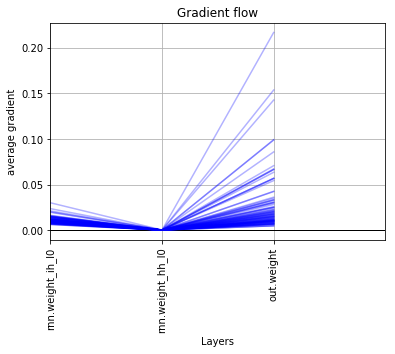

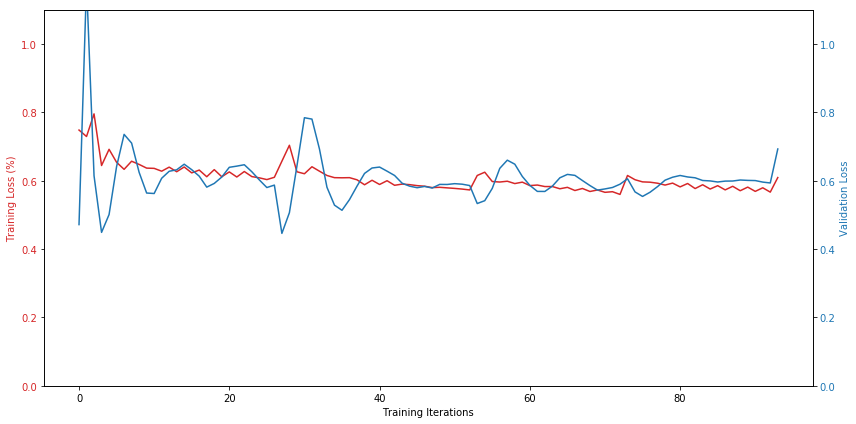

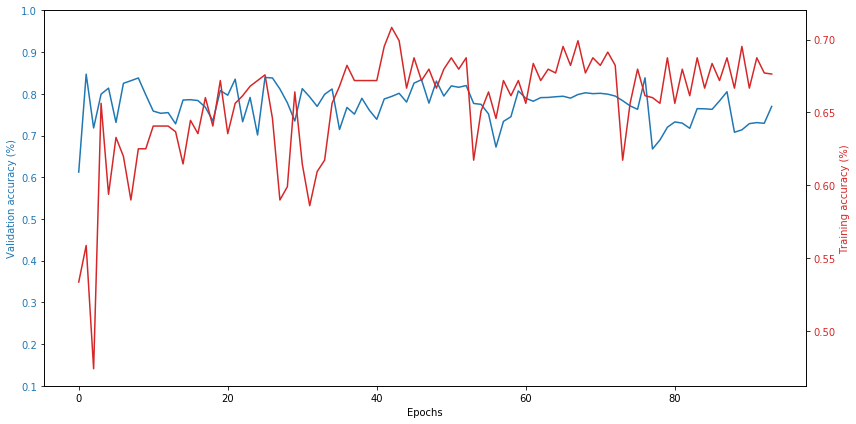

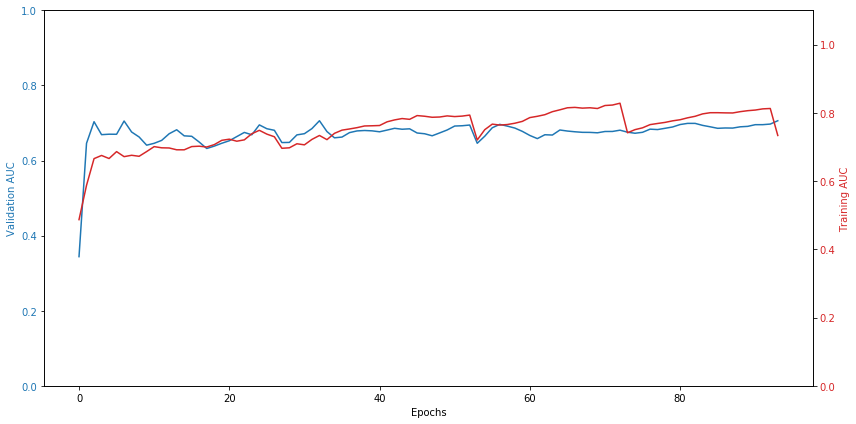

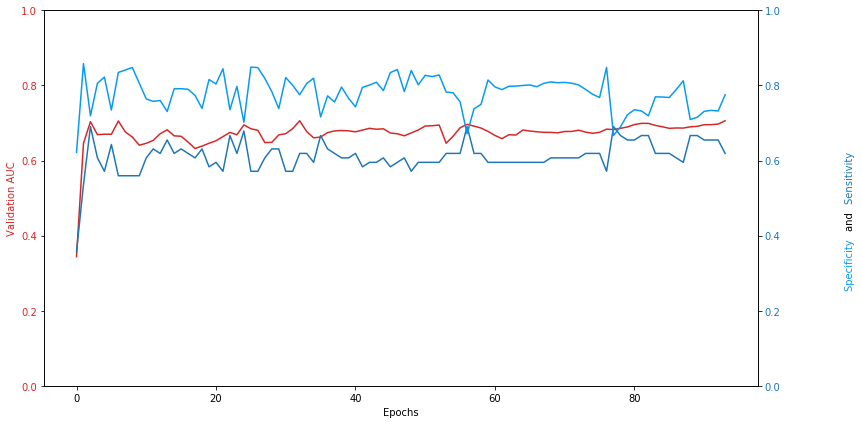


Fold  3
confused items in training set:  236
not_confused items in training set:  236
confused items in validation set:  64
not_confused items in validation set:  2244

Test confused items:

['111a_H-SortTwoFactors-3-1.pkl', '111a_H-SortTwoFactors-3-2.pkl', '111a_H-SortTwoFactors-3-3.pkl', '111a_H-SortTwoFactors-3-4.pkl', '137a_H-FE-4-1.pkl', '137a_H-FE-4-2.pkl', '137a_H-FE-4-3.pkl', '137a_H-FE-4-4.pkl', '137a_H-SortTwoFactors-2-1.pkl', '137a_H-SortTwoFactors-2-2.pkl', '137a_H-SortTwoFactors-2-3.pkl', '137a_H-SortTwoFactors-2-4.pkl', '137b_V-FE-20-1.pkl', '137b_V-FE-20-2.pkl', '137b_V-FE-20-3.pkl', '137b_V-FE-20-4.pkl', '145b_V-SortTwoFactors-10-1.pkl', '145b_V-SortTwoFactors-10-2.pkl', '145b_V-SortTwoFactors-10-3.pkl', '145b_V-SortTwoFactors-10-4.pkl', '145b_V-SortTwoFactors-24-1.pkl', '145b_V-SortTwoFactors-24-2.pkl', '145b_V-SortTwoFactors-24-3.pkl', '145b_V-SortTwoFactors-24-4.pkl', '14a_V-SortTwoFactors-3-1.pkl', '14a_V-SortTwoFactors-3-2.pkl', '14a_V-SortTwoFactors-3-3.pkl', '14

Validation AUC:  0.6485071301247771
Validation Loss:  0.6357774853706359
Epochs without improvement:  10
[epoch: 15, batches:     1] loss: 0.62014 | accuracy: 0.64062
[epoch: 15, batches:     2] loss: 0.67773 | accuracy: 0.56019
Training accuracy for epoch:  0.6004050925925926
validation accuracy:  0.645580589254766
validation loss:  0.5023093611001969
validation recall:  0.671875
validation specificity:  0.6448306595365418
validation AUC:  0.6400749220142602
Epochs without improvement:  11
[epoch: 16, batches:     1] loss: 0.62095 | accuracy: 0.64062
[epoch: 16, batches:     2] loss: 0.63347 | accuracy: 0.63889
Training accuracy for epoch:  0.6397569444444444
validation accuracy:  0.7508665511265165
validation loss:  0.5485810458660125
validation recall:  0.59375
validation specificity:  0.7553475935828877
validation AUC:  0.6410775958110517
Epochs without improvement:  12
[epoch: 17, batches:     1] loss: 0.60942 | accuracy: 0.64062
[epoch: 17, batches:     2] loss: 0.62354 | accurac

[epoch: 35, batches:     1] loss: 0.58120 | accuracy: 0.67578
[epoch: 35, batches:     2] loss: 0.59030 | accuracy: 0.67593
Training accuracy for epoch:  0.675853587962963
validation accuracy:  0.800259965337955
validation loss:  0.6659071326255799
validation recall:  0.578125
validation specificity:  0.8065953654188949
validation AUC:  0.6391070632798573
Epochs without improvement:  14
[epoch: 36, batches:     1] loss: 0.57184 | accuracy: 0.67969
[epoch: 36, batches:     2] loss: 0.58351 | accuracy: 0.67593
Training accuracy for epoch:  0.677806712962963
validation accuracy:  0.7725303292894281
validation loss:  0.6061776518821717
validation recall:  0.5625
validation specificity:  0.7785204991087344
validation AUC:  0.6362940062388592
Epochs without improvement:  15
[epoch: 37, batches:     1] loss: 0.57098 | accuracy: 0.68359
[epoch: 37, batches:     2] loss: 0.57502 | accuracy: 0.67593
Training accuracy for epoch:  0.679759837962963
validation accuracy:  0.7790294627383015
validati

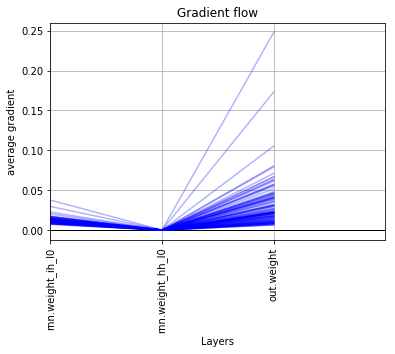

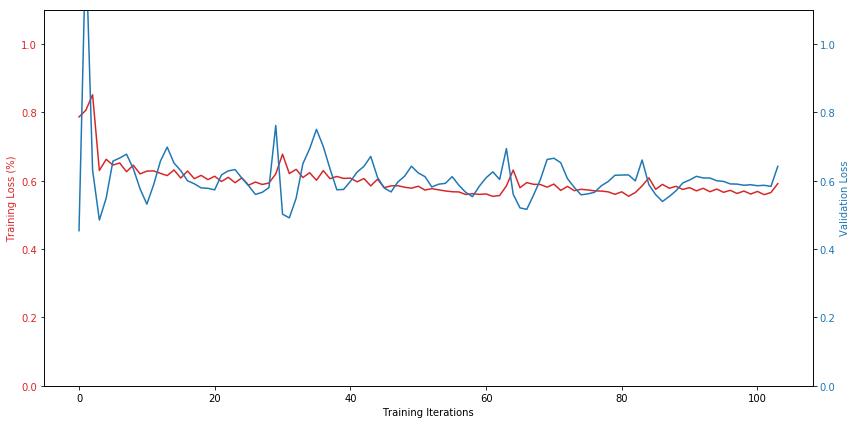

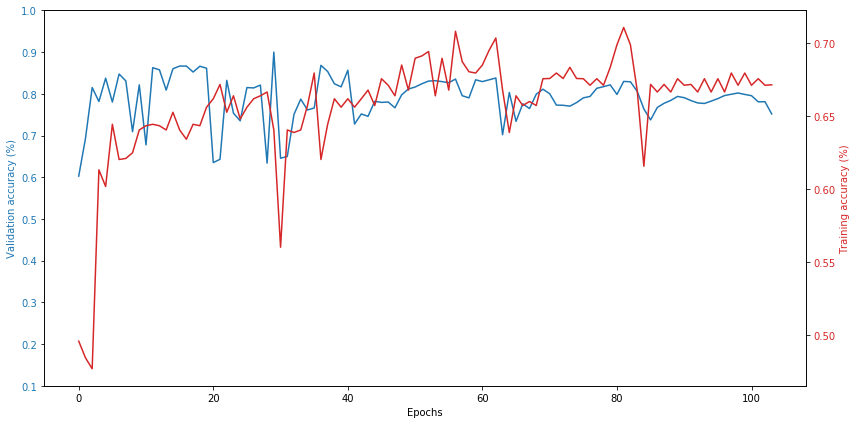

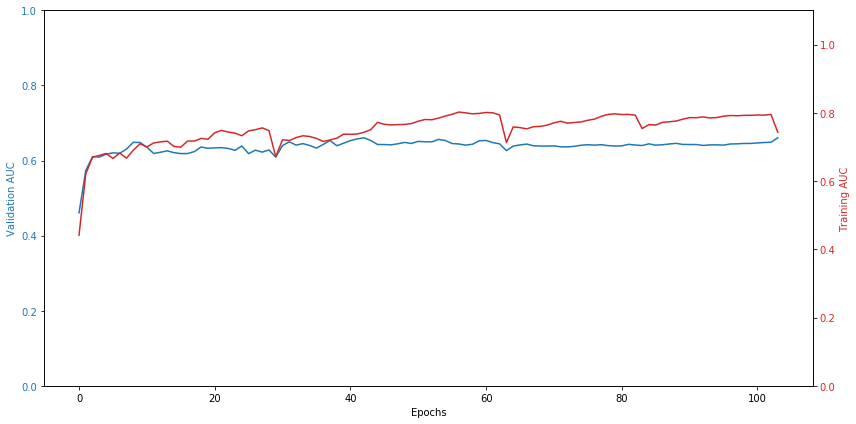

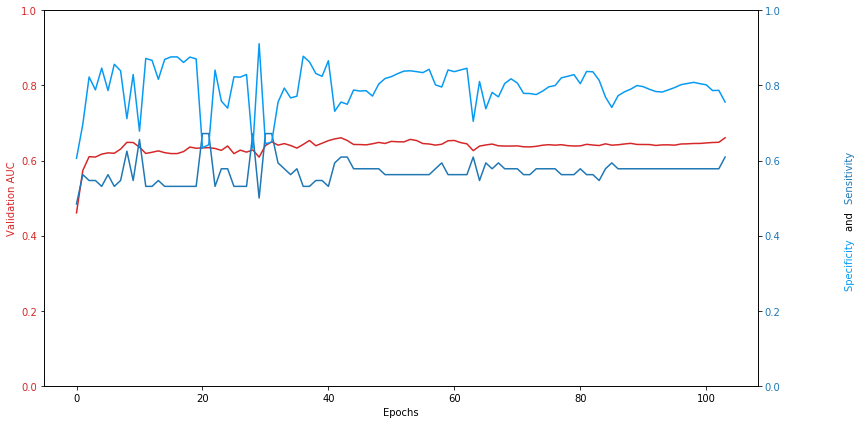


Fold  4
confused items in training set:  248
not_confused items in training set:  248
confused items in validation set:  68
not_confused items in validation set:  2244

Test confused items:

['58a_V-SortTwoFactors-14-1.pkl', '58a_V-SortTwoFactors-14-2.pkl', '58a_V-SortTwoFactors-14-3.pkl', '58a_V-SortTwoFactors-14-4.pkl', '58a_V-SortTwoFactors-23-1.pkl', '58a_V-SortTwoFactors-23-2.pkl', '58a_V-SortTwoFactors-23-3.pkl', '58a_V-SortTwoFactors-23-4.pkl', '58a_V-SortTwoFactors-6-1.pkl', '58a_V-SortTwoFactors-6-2.pkl', '58a_V-SortTwoFactors-6-3.pkl', '58a_V-SortTwoFactors-6-4.pkl', '86a_V-FE-10-1.pkl', '86a_V-FE-10-2.pkl', '86a_V-FE-10-3.pkl', '86a_V-FE-10-4.pkl', '86a_V-SortTwoFactors-4-1.pkl', '86a_V-SortTwoFactors-4-2.pkl', '86a_V-SortTwoFactors-4-3.pkl', '86a_V-SortTwoFactors-4-4.pkl', '86b_H-CDV-6-1.pkl', '86b_H-CDV-6-2.pkl', '86b_H-CDV-6-3.pkl', '86b_H-CDV-6-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 496
    Root Location: ./dataset/augmented/train3-1/
  

[epoch: 16, batches:     1] loss: 0.61231 | accuracy: 0.64062
[epoch: 16, batches:     2] loss: 0.57383 | accuracy: 0.69583
Training accuracy for epoch:  0.6682291666666667
validation accuracy:  0.6128892733564014
validation loss:  0.5593606173992157
validation recall:  0.5588235294117647
validation specificity:  0.6145276292335116
validation AUC:  0.5554616231519345
Epochs without improvement:  1
[epoch: 17, batches:     1] loss: 0.61214 | accuracy: 0.62891
[epoch: 17, batches:     2] loss: 0.56762 | accuracy: 0.70417
Training accuracy for epoch:  0.6665364583333333
validation accuracy:  0.6686851211072664
validation loss:  0.5341820150613785
validation recall:  0.5147058823529411
validation specificity:  0.6733511586452763
validation AUC:  0.5588759567998323
Epochs without improvement:  2
[epoch: 18, batches:     1] loss: 0.60978 | accuracy: 0.63672
[epoch: 18, batches:     2] loss: 0.56270 | accuracy: 0.70000
Training accuracy for epoch:  0.668359375
validation accuracy:  0.86245674

[epoch: 36, batches:     1] loss: 0.60133 | accuracy: 0.62109
[epoch: 36, batches:     2] loss: 0.55642 | accuracy: 0.71250
Training accuracy for epoch:  0.666796875
validation accuracy:  0.7932525951557093
validation loss:  0.5315406262874603
validation recall:  0.45588235294117646
validation specificity:  0.803475935828877
validation AUC:  0.5578536227325155
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.0015
New learning rate: 0.00075
Validation AUC:  0.5994121579112929
Validation Loss:  0.6000384449958801
Epochs without improvement:  10
[epoch: 37, batches:     1] loss: 0.63122 | accuracy: 0.62109
[epoch: 37, batches:     2] loss: 0.60795 | accuracy: 0.60000
Training accuracy for epoch:  0.610546875
validation accuracy:  0.8135813148788927
validation loss:  0.5957130491733551
validation recall:  0.4264705882352941
validation specificity:  0.8253119429590018
validation AUC:  0.5504154870504352
Epochs without improvement:  11
[epoch: 38

[epoch: 56, batches:     1] loss: 0.59842 | accuracy: 0.62500
[epoch: 56, batches:     2] loss: 0.55727 | accuracy: 0.70833
Training accuracy for epoch:  0.6666666666666667
validation accuracy:  0.5929930795847751
validation loss:  0.5498894989490509
validation recall:  0.6029411764705882
validation specificity:  0.5926916221033868
validation AUC:  0.5888775296214741
Epochs without improvement:  3
[epoch: 57, batches:     1] loss: 0.59721 | accuracy: 0.62500
[epoch: 57, batches:     2] loss: 0.55602 | accuracy: 0.70000
Training accuracy for epoch:  0.6625
validation accuracy:  0.6059688581314879
validation loss:  0.5587557256221771
validation recall:  0.5882352941176471
validation specificity:  0.60650623885918
validation AUC:  0.5877339572192514
Epochs without improvement:  4
[epoch: 58, batches:     1] loss: 0.59490 | accuracy: 0.62891
[epoch: 58, batches:     2] loss: 0.55538 | accuracy: 0.70000
Training accuracy for epoch:  0.664453125
validation accuracy:  0.596885813148789
valida

[epoch: 76, batches:     1] loss: 0.59515 | accuracy: 0.64062
[epoch: 76, batches:     2] loss: 0.56036 | accuracy: 0.70417
Training accuracy for epoch:  0.6723958333333333
validation accuracy:  0.629325259515571
validation loss:  0.5570580959320068
validation recall:  0.6029411764705882
validation specificity:  0.6301247771836007
validation AUC:  0.6010570672119115
Epochs without improvement:  1
[epoch: 77, batches:     1] loss: 0.59597 | accuracy: 0.62891
[epoch: 77, batches:     2] loss: 0.55873 | accuracy: 0.70833
Training accuracy for epoch:  0.6686197916666667
validation accuracy:  0.6193771626297578
validation loss:  0.5545334875583648
validation recall:  0.6029411764705882
validation specificity:  0.6198752228163993
validation AUC:  0.5966072926496803
Epochs without improvement:  2
[epoch: 78, batches:     1] loss: 0.59613 | accuracy: 0.62500
[epoch: 78, batches:     2] loss: 0.55768 | accuracy: 0.70833
Training accuracy for epoch:  0.6666666666666667
validation accuracy:  0.59

[epoch: 95, batches:     1] loss: 0.59450 | accuracy: 0.62891
[epoch: 95, batches:     2] loss: 0.55695 | accuracy: 0.70833
Training accuracy for epoch:  0.6686197916666667
validation accuracy:  0.6003460207612457
validation loss:  0.5595145583152771
validation recall:  0.6029411764705882
validation specificity:  0.6002673796791443
validation AUC:  0.601243839781902
Epochs without improvement:  5
[epoch: 96, batches:     1] loss: 0.59435 | accuracy: 0.62891
[epoch: 96, batches:     2] loss: 0.55675 | accuracy: 0.70417
Training accuracy for epoch:  0.6665364583333333
validation accuracy:  0.597318339100346
validation loss:  0.5597026586532593
validation recall:  0.6029411764705882
validation specificity:  0.5971479500891266
validation AUC:  0.6010701740589284
Epochs without improvement:  6
[epoch: 97, batches:     1] loss: 0.59415 | accuracy: 0.62891
[epoch: 97, batches:     2] loss: 0.55657 | accuracy: 0.70417
Training accuracy for epoch:  0.6665364583333333
validation accuracy:  0.598

[epoch: 115, batches:     1] loss: 0.59386 | accuracy: 0.64062
[epoch: 115, batches:     2] loss: 0.55877 | accuracy: 0.70417
Training accuracy for epoch:  0.6723958333333333
validation accuracy:  0.6029411764705882
validation loss:  0.564465469121933
validation recall:  0.6029411764705882
validation specificity:  0.6029411764705882
validation AUC:  0.6025905683128865
Epochs without improvement:  25
[epoch: 116, batches:     1] loss: 0.59385 | accuracy: 0.64062
[epoch: 116, batches:     2] loss: 0.55865 | accuracy: 0.70417
Training accuracy for epoch:  0.6723958333333333
validation accuracy:  0.6029411764705882
validation loss:  0.5642948687076569
validation recall:  0.6029411764705882
validation specificity:  0.6029411764705882
validation AUC:  0.6027019765125302
Epochs without improvement:  26
[epoch: 117, batches:     1] loss: 0.59385 | accuracy: 0.64062
[epoch: 117, batches:     2] loss: 0.55853 | accuracy: 0.70417
Training accuracy for epoch:  0.6723958333333333
validation accurac

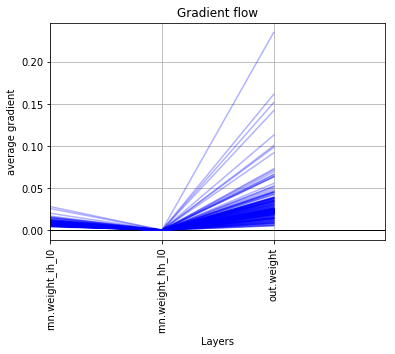

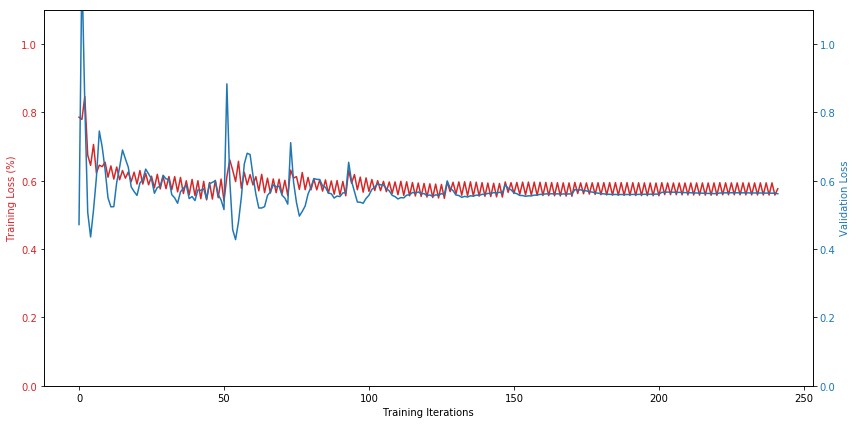

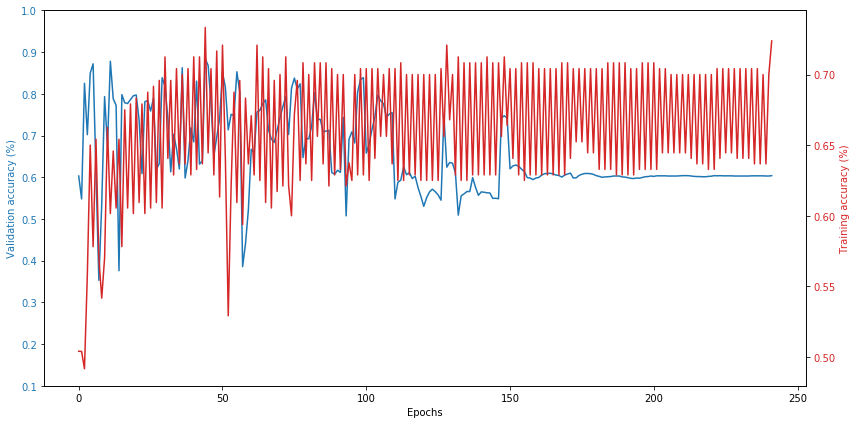

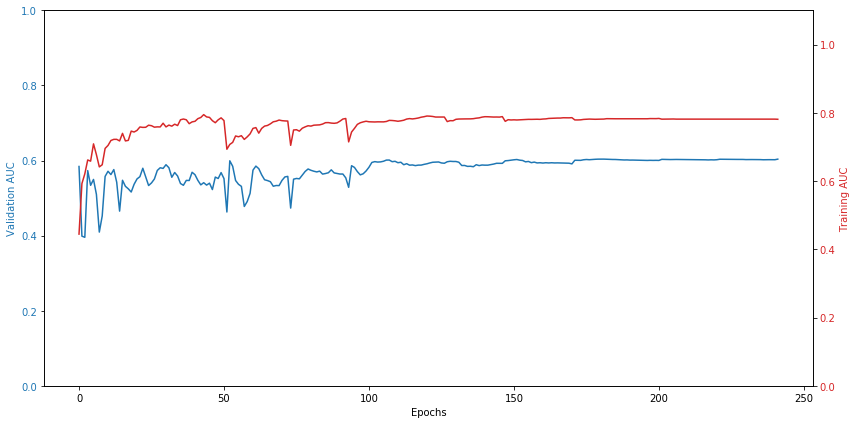

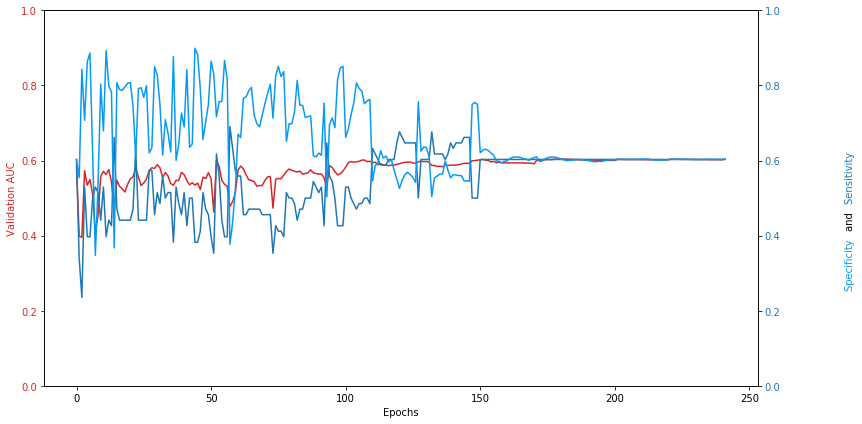


Fold  5
confused items in training set:  220
not_confused items in training set:  220
confused items in validation set:  96
not_confused items in validation set:  2196

Test confused items:

['122a_V-SortTwoFactors-4-1.pkl', '122a_V-SortTwoFactors-4-2.pkl', '122a_V-SortTwoFactors-4-3.pkl', '122a_V-SortTwoFactors-4-4.pkl', '142a_V-CDV-15-1.pkl', '142a_V-CDV-15-2.pkl', '142a_V-CDV-15-3.pkl', '142a_V-CDV-15-4.pkl', '142b_H-CDV-22-1.pkl', '142b_H-CDV-22-2.pkl', '142b_H-CDV-22-3.pkl', '142b_H-CDV-22-4.pkl', '25a_H-RV-22-1.pkl', '25a_H-RV-22-2.pkl', '25a_H-RV-22-3.pkl', '25a_H-RV-22-4.pkl', '32a_V-SortTwoFactors-11-1.pkl', '32a_V-SortTwoFactors-11-2.pkl', '32a_V-SortTwoFactors-11-3.pkl', '32a_V-SortTwoFactors-11-4.pkl', '82a_V-SortTwoFactors-4-1.pkl', '82a_V-SortTwoFactors-4-2.pkl', '82a_V-SortTwoFactors-4-3.pkl', '82a_V-SortTwoFactors-4-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 440
    Root Location: ./dataset/augmented/train3-1/
    Transforms (if any): None


Training accuracy for epoch:  0.6311990489130435
validation accuracy:  0.6588132635253054
validation loss:  0.7506057686275907
validation recall:  0.65625
validation specificity:  0.6589253187613844
validation AUC:  0.6470215733151183
Epochs without improvement:  12
[epoch: 17, batches:     1] loss: 0.64051 | accuracy: 0.54688
[epoch: 17, batches:     2] loss: 0.57817 | accuracy: 0.66304
Training accuracy for epoch:  0.6049592391304348
validation accuracy:  0.56239092495637
validation loss:  0.6788872414165072
validation recall:  0.7395833333333334
validation specificity:  0.5546448087431693
validation AUC:  0.6538830069823922
Old best AUC:  0.6532473816029144
New best SUC:  0.6538830069823922
New best model found. Saving now.
Epochs without improvement:  0
[epoch: 18, batches:     1] loss: 0.62615 | accuracy: 0.62500
[epoch: 18, batches:     2] loss: 0.57270 | accuracy: 0.67935
Training accuracy for epoch:  0.6521739130434783
validation accuracy:  0.6522687609075044
validation loss:  

[epoch: 36, batches:     2] loss: 0.54266 | accuracy: 0.71196
Training accuracy for epoch:  0.6841032608695652
validation accuracy:  0.8416230366492147
validation loss:  0.6150644752714369
validation recall:  0.5
validation specificity:  0.8565573770491803
validation AUC:  0.6255407559198543
Epochs without improvement:  17
[epoch: 37, batches:     1] loss: 0.57888 | accuracy: 0.66797
[epoch: 37, batches:     2] loss: 0.54013 | accuracy: 0.70652
Training accuracy for epoch:  0.6872452445652174
validation accuracy:  0.8167539267015707
validation loss:  0.6327369411786398
validation recall:  0.5
validation specificity:  0.8306010928961749
validation AUC:  0.6270562955373405
Epochs without improvement:  18
[epoch: 38, batches:     1] loss: 0.57547 | accuracy: 0.67188
[epoch: 38, batches:     2] loss: 0.53645 | accuracy: 0.71739
Training accuracy for epoch:  0.6946331521739131
validation accuracy:  0.8237347294938918
validation loss:  0.6194946500990126
validation recall:  0.5
validation sp

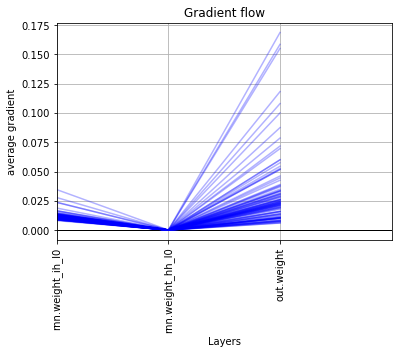

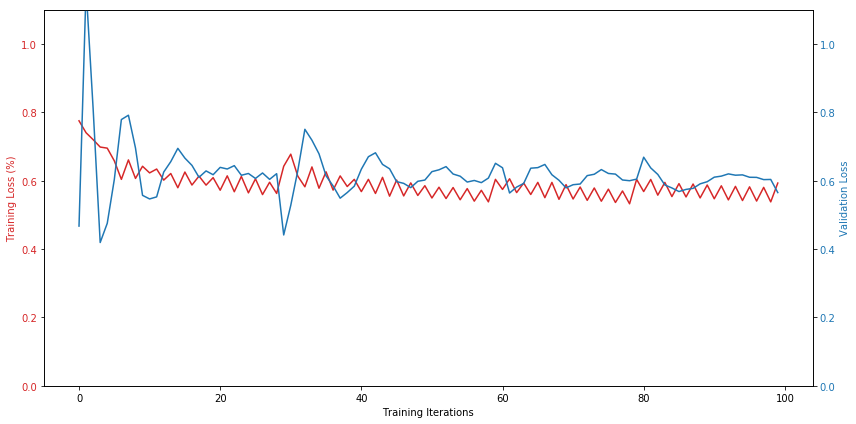

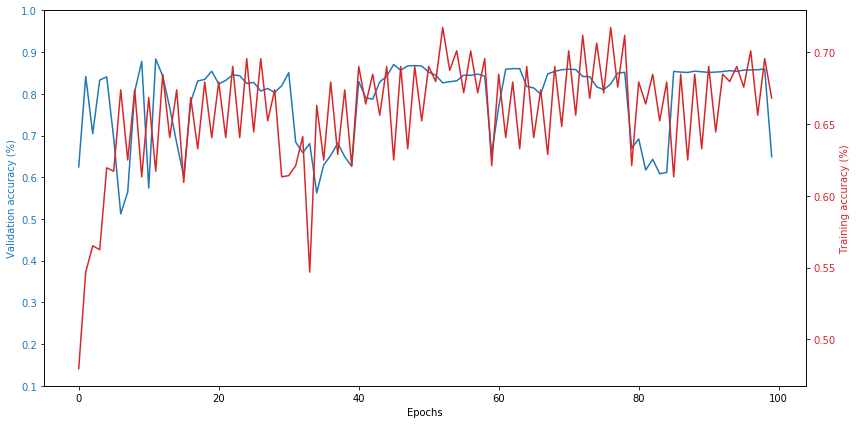

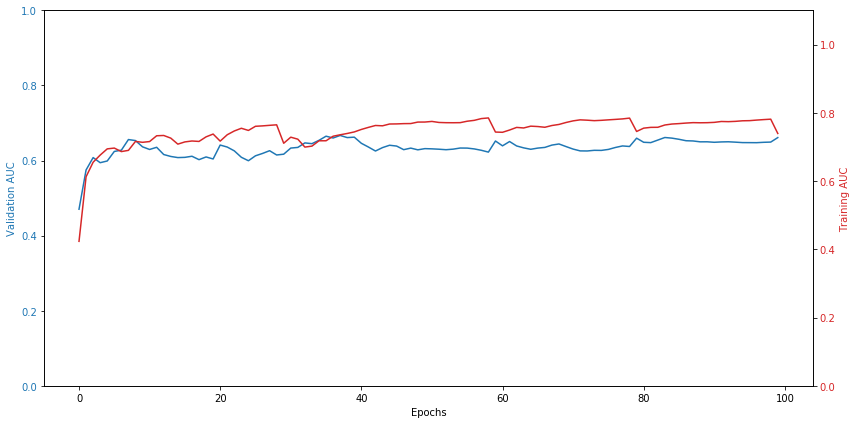

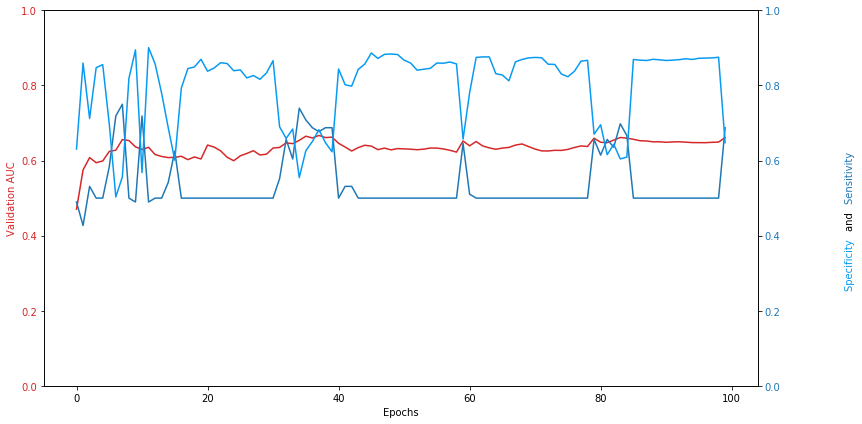


Fold  6
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  84
not_confused items in validation set:  2164

Test confused items:

['10a_V-CDV-2-1.pkl', '10a_V-CDV-2-2.pkl', '10a_V-CDV-2-3.pkl', '10a_V-CDV-2-4.pkl', '12b_H-CDV-5-1.pkl', '12b_H-CDV-5-2.pkl', '12b_H-CDV-5-3.pkl', '12b_H-CDV-5-4.pkl', '3a_H-SortTwoFactors-11-1.pkl', '3a_H-SortTwoFactors-11-2.pkl', '3a_H-SortTwoFactors-11-3.pkl', '3a_H-SortTwoFactors-11-4.pkl', '9a_H-SortTwoFactors-12-1.pkl', '9a_H-SortTwoFactors-12-2.pkl', '9a_H-SortTwoFactors-12-3.pkl', '9a_H-SortTwoFactors-12-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 480
    Root Location: ./dataset/augmented/train3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2248
    Root Location: ./dataset/augmented/val3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Test data:  Da

[epoch: 17, batches:     1] loss: 0.60309 | accuracy: 0.66406
[epoch: 17, batches:     2] loss: 0.63700 | accuracy: 0.62500
Training accuracy for epoch:  0.64453125
validation accuracy:  0.8701067615658363
validation loss:  0.5681575371159447
validation recall:  0.5595238095238095
validation specificity:  0.8821626617375231
validation AUC:  0.6988436317225597
Epochs without improvement:  13
[epoch: 18, batches:     1] loss: 0.62351 | accuracy: 0.65625
[epoch: 18, batches:     2] loss: 0.62995 | accuracy: 0.62500
Training accuracy for epoch:  0.640625
validation accuracy:  0.8554270462633452
validation loss:  0.6326604949103461
validation recall:  0.5714285714285714
validation specificity:  0.8664510166358595
validation AUC:  0.7102917876947453
Epochs without improvement:  14
[epoch: 19, batches:     1] loss: 0.59718 | accuracy: 0.65625
[epoch: 19, batches:     2] loss: 0.63078 | accuracy: 0.65625
Training accuracy for epoch:  0.65625
validation accuracy:  0.8491992882562278
validation 

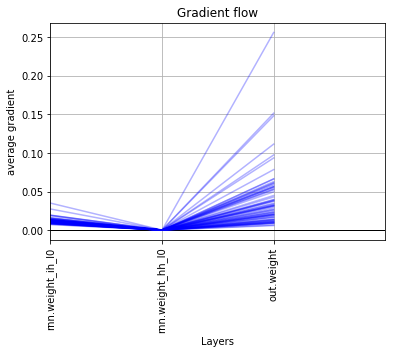

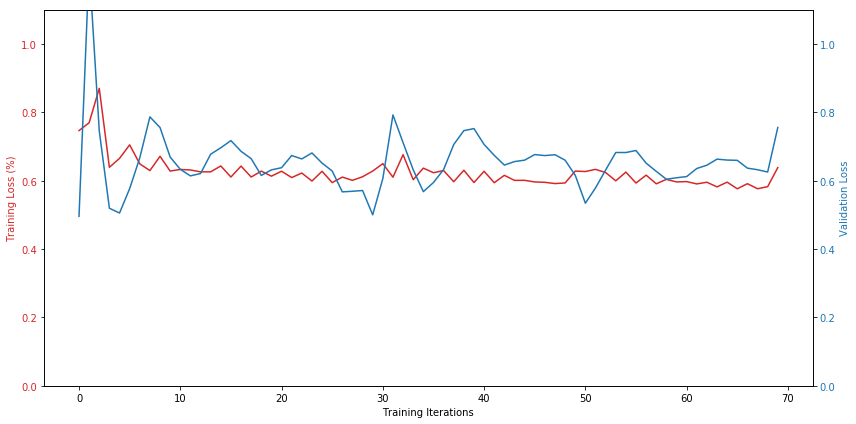

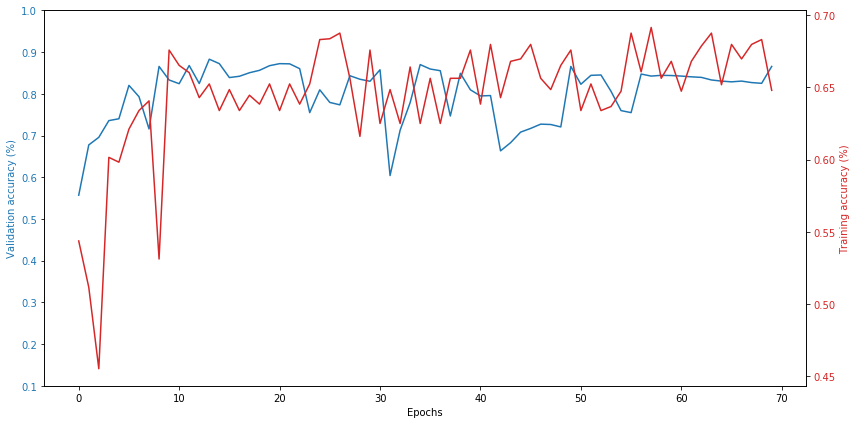

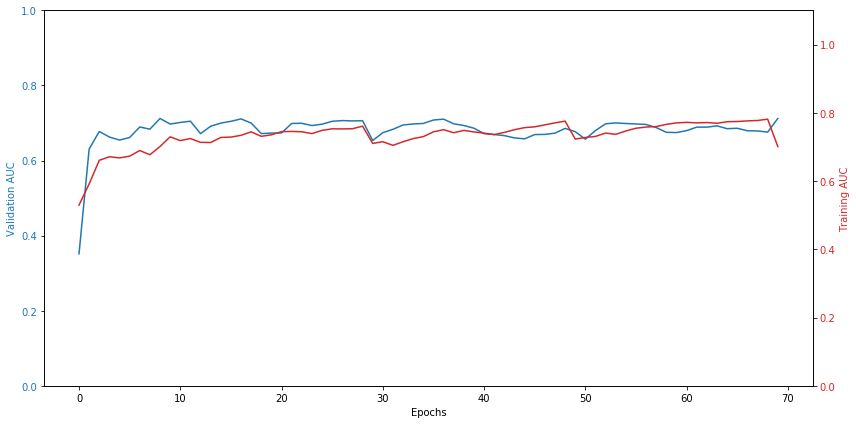

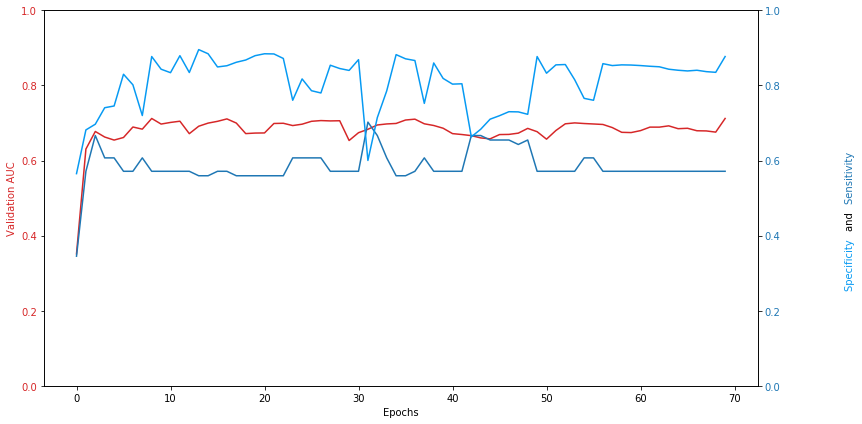


Fold  7
confused items in training set:  224
not_confused items in training set:  224
confused items in validation set:  72
not_confused items in validation set:  2040

Test confused items:

['105a_H-FE-17-1.pkl', '105a_H-FE-17-2.pkl', '105a_H-FE-17-3.pkl', '105a_H-FE-17-4.pkl', '105a_H-RV-22-1.pkl', '105a_H-RV-22-2.pkl', '105a_H-RV-22-3.pkl', '105a_H-RV-22-4.pkl', '105a_H-RV-8-1.pkl', '105a_H-RV-8-2.pkl', '105a_H-RV-8-3.pkl', '105a_H-RV-8-4.pkl', '105b_V-FE-20-1.pkl', '105b_V-FE-20-2.pkl', '105b_V-FE-20-3.pkl', '105b_V-FE-20-4.pkl', '105b_V-FE-8-1.pkl', '105b_V-FE-8-2.pkl', '105b_V-FE-8-3.pkl', '105b_V-FE-8-4.pkl', '105b_V-RV-5-1.pkl', '105b_V-RV-5-2.pkl', '105b_V-RV-5-3.pkl', '105b_V-RV-5-4.pkl', '134b_H-CDV-15-1.pkl', '134b_H-CDV-15-2.pkl', '134b_H-CDV-15-3.pkl', '134b_H-CDV-15-4.pkl', '134b_H-CDV-4-1.pkl', '134b_H-CDV-4-2.pkl', '134b_H-CDV-4-3.pkl', '134b_H-CDV-4-4.pkl', '50a_V-SortTwoFactors-22-1.pkl', '50a_V-SortTwoFactors-22-2.pkl', '50a_V-SortTwoFactors-22-3.pkl', '50a_V-SortT

[epoch: 15, batches:     1] loss: 0.57654 | accuracy: 0.67578
[epoch: 15, batches:     2] loss: 0.58993 | accuracy: 0.65104
Training accuracy for epoch:  0.6634114583333333
validation accuracy:  0.7305871212121212
validation loss:  0.6386426753467984
validation recall:  0.6944444444444444
validation specificity:  0.7318627450980392
validation AUC:  0.6815597766884532
Epochs without improvement:  2
[epoch: 16, batches:     1] loss: 0.57226 | accuracy: 0.68750
[epoch: 16, batches:     2] loss: 0.58376 | accuracy: 0.64583
Training accuracy for epoch:  0.6666666666666667
validation accuracy:  0.8016098484848485
validation loss:  0.6256867713398404
validation recall:  0.5694444444444444
validation specificity:  0.8098039215686275
validation AUC:  0.6667483660130719
Epochs without improvement:  3
[epoch: 17, batches:     1] loss: 0.57554 | accuracy: 0.69531
[epoch: 17, batches:     2] loss: 0.58416 | accuracy: 0.64583
Training accuracy for epoch:  0.6705729166666667
validation accuracy:  0.7

[epoch: 35, batches:     2] loss: 0.56245 | accuracy: 0.69792
Training accuracy for epoch:  0.6966145833333333
validation accuracy:  0.7234848484848485
validation loss:  0.6237002015113831
validation recall:  0.6805555555555556
validation specificity:  0.725
validation AUC:  0.6985089869281045
Epochs without improvement:  6
[epoch: 36, batches:     1] loss: 0.55936 | accuracy: 0.71094
[epoch: 36, batches:     2] loss: 0.55931 | accuracy: 0.69271
Training accuracy for epoch:  0.7018229166666667
validation accuracy:  0.8020833333333334
validation loss:  0.6039634082052443
validation recall:  0.625
validation specificity:  0.8083333333333333
validation AUC:  0.6885825163398693
Epochs without improvement:  7
[epoch: 37, batches:     1] loss: 0.55687 | accuracy: 0.68750
[epoch: 37, batches:     2] loss: 0.55696 | accuracy: 0.64583
Training accuracy for epoch:  0.6666666666666667
validation accuracy:  0.8134469696969697
validation loss:  0.5876433584425185
validation recall:  0.625
validatio

[epoch: 55, batches:     2] loss: 0.55424 | accuracy: 0.68750
Training accuracy for epoch:  0.697265625
validation accuracy:  0.790719696969697
validation loss:  0.6013494862450494
validation recall:  0.625
validation specificity:  0.7965686274509803
validation AUC:  0.684640522875817
Epochs without improvement:  26
[epoch: 56, batches:     1] loss: 0.55359 | accuracy: 0.70312
[epoch: 56, batches:     2] loss: 0.55350 | accuracy: 0.66667
Training accuracy for epoch:  0.6848958333333333
validation accuracy:  0.7921401515151515
validation loss:  0.5873974363009135
validation recall:  0.625
validation specificity:  0.7980392156862746
validation AUC:  0.6847562636165576
Epochs without improvement:  27
[epoch: 57, batches:     1] loss: 0.55144 | accuracy: 0.69922
[epoch: 57, batches:     2] loss: 0.55149 | accuracy: 0.66667
Training accuracy for epoch:  0.6829427083333333
validation accuracy:  0.7836174242424242
validation loss:  0.5922341677877638
validation recall:  0.625
validation speci

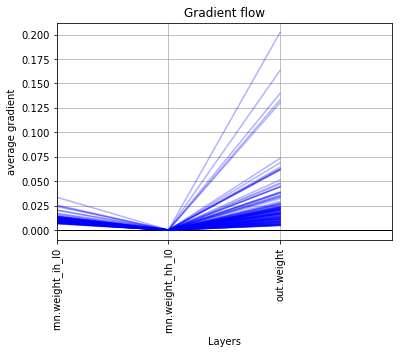

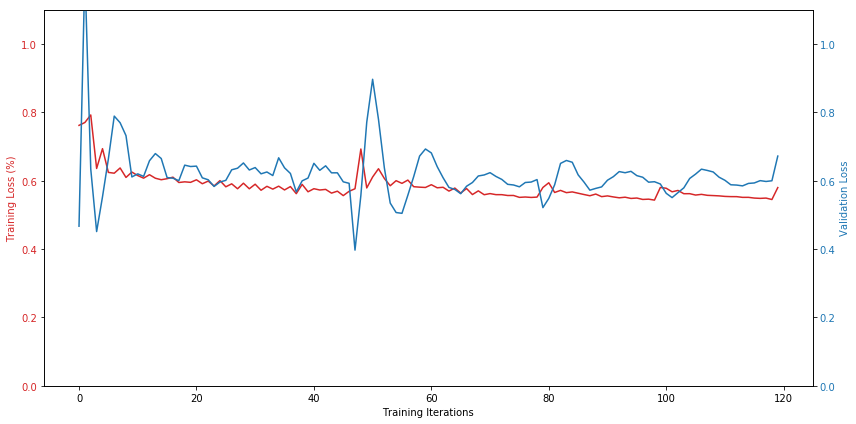

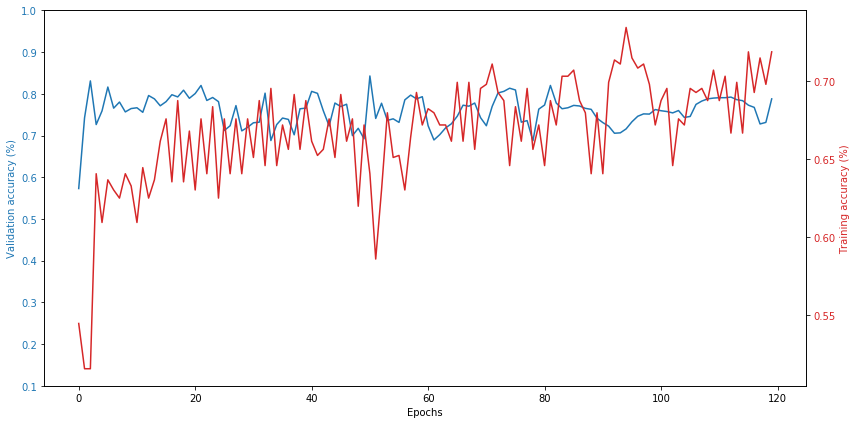

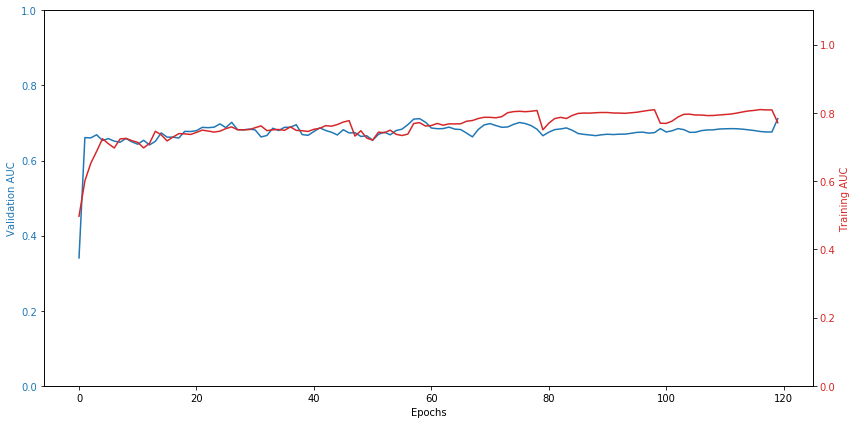

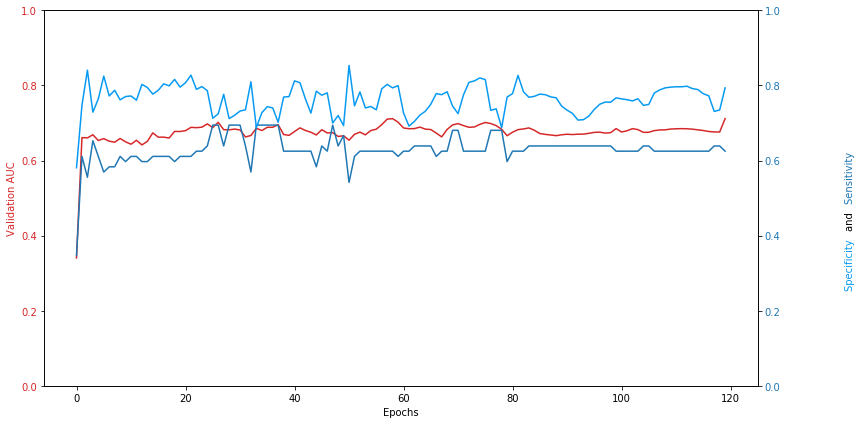


Fold  8
confused items in training set:  236
not_confused items in training set:  236
confused items in validation set:  68
not_confused items in validation set:  1964

Test confused items:

['121a_H-CDV-9-1.pkl', '121a_H-CDV-9-2.pkl', '121a_H-CDV-9-3.pkl', '121a_H-CDV-9-4.pkl', '121a_H-SortTwoFactors-20-1.pkl', '121a_H-SortTwoFactors-20-2.pkl', '121a_H-SortTwoFactors-20-3.pkl', '121a_H-SortTwoFactors-20-4.pkl', '121b_V-FE-2-1.pkl', '121b_V-FE-2-2.pkl', '121b_V-FE-2-3.pkl', '121b_V-FE-2-4.pkl', '121b_V-SortTwoFactors-11-1.pkl', '121b_V-SortTwoFactors-11-2.pkl', '121b_V-SortTwoFactors-11-3.pkl', '121b_V-SortTwoFactors-11-4.pkl', '129b_V-SortTwoFactors-23-1.pkl', '129b_V-SortTwoFactors-23-2.pkl', '129b_V-SortTwoFactors-23-3.pkl', '129b_V-SortTwoFactors-23-4.pkl', '141a_H-RV-18-1.pkl', '141a_H-RV-18-2.pkl', '141a_H-RV-18-3.pkl', '141a_H-RV-18-4.pkl', '141a_H-SortTwoFactors-22-1.pkl', '141a_H-SortTwoFactors-22-2.pkl', '141a_H-SortTwoFactors-22-3.pkl', '141a_H-SortTwoFactors-22-4.pkl', '55

[epoch: 16, batches:     1] loss: 0.57513 | accuracy: 0.66406
[epoch: 16, batches:     2] loss: 0.53463 | accuracy: 0.71759
Training accuracy for epoch:  0.6908275462962963
validation accuracy:  0.6141732283464567
validation loss:  0.5591272227466106
validation recall:  0.5147058823529411
validation specificity:  0.6176171079429735
validation AUC:  0.5356565233017851
Epochs without improvement:  6
[epoch: 17, batches:     1] loss: 0.57557 | accuracy: 0.66406
[epoch: 17, batches:     2] loss: 0.53721 | accuracy: 0.72222
Training accuracy for epoch:  0.6931423611111112
validation accuracy:  0.6934055118110236
validation loss:  0.5873385518789291
validation recall:  0.45588235294117646
validation specificity:  0.7016293279022403
validation AUC:  0.5352297232538636
Epochs without improvement:  7
[epoch: 18, batches:     1] loss: 0.56297 | accuracy: 0.69141
[epoch: 18, batches:     2] loss: 0.53531 | accuracy: 0.70833
Training accuracy for epoch:  0.6998697916666667
validation accuracy:  0.

Training accuracy for epoch:  0.6990017361111112
validation accuracy:  0.719488188976378
validation loss:  0.5738326497375965
validation recall:  0.4411764705882353
validation specificity:  0.7291242362525459
validation AUC:  0.5271841679645382
Epochs without improvement:  13
[epoch: 36, batches:     1] loss: 0.57864 | accuracy: 0.66016
[epoch: 36, batches:     2] loss: 0.53965 | accuracy: 0.73611
Training accuracy for epoch:  0.6981336805555556
validation accuracy:  0.7150590551181102
validation loss:  0.5512135103344917
validation recall:  0.45588235294117646
validation specificity:  0.7240325865580448
validation AUC:  0.5355704145201868
Epochs without improvement:  14
[epoch: 37, batches:     1] loss: 0.57325 | accuracy: 0.67188
[epoch: 37, batches:     2] loss: 0.53469 | accuracy: 0.73611
Training accuracy for epoch:  0.7039930555555556
validation accuracy:  0.5182086614173228
validation loss:  0.563965629786253
validation recall:  0.6323529411764706
validation specificity:  0.5142

[epoch: 55, batches:     1] loss: 0.55466 | accuracy: 0.68359
[epoch: 55, batches:     2] loss: 0.53047 | accuracy: 0.72222
Training accuracy for epoch:  0.7029079861111112
validation accuracy:  0.5551181102362205
validation loss:  0.5983458533883095
validation recall:  0.5735294117647058
validation specificity:  0.5544806517311609
validation AUC:  0.5453793279022403
Epochs without improvement:  3
[epoch: 56, batches:     1] loss: 0.55341 | accuracy: 0.67969
[epoch: 56, batches:     2] loss: 0.52943 | accuracy: 0.72222
Training accuracy for epoch:  0.7009548611111112
validation accuracy:  0.562992125984252
validation loss:  0.5982623770833015
validation recall:  0.5735294117647058
validation specificity:  0.5626272912423625
validation AUC:  0.5448214927518868
Epochs without improvement:  4
[epoch: 57, batches:     1] loss: 0.55218 | accuracy: 0.67969
[epoch: 57, batches:     2] loss: 0.52855 | accuracy: 0.71759
Training accuracy for epoch:  0.6986400462962963
validation accuracy:  0.55

[epoch: 75, batches:     1] loss: 0.53549 | accuracy: 0.69922
[epoch: 75, batches:     2] loss: 0.51000 | accuracy: 0.72685
Training accuracy for epoch:  0.7130353009259259
validation accuracy:  0.5969488188976378
validation loss:  0.5879593007266521
validation recall:  0.5441176470588235
validation specificity:  0.5987780040733197
validation AUC:  0.5528633041811428
Epochs without improvement:  5
[epoch: 76, batches:     1] loss: 0.53461 | accuracy: 0.69922
[epoch: 76, batches:     2] loss: 0.50886 | accuracy: 0.72685
Training accuracy for epoch:  0.7130353009259259
validation accuracy:  0.6013779527559056
validation loss:  0.5896702781319618
validation recall:  0.5441176470588235
validation specificity:  0.6033604887983707
validation AUC:  0.5533050796693423
Epochs without improvement:  6
[epoch: 77, batches:     1] loss: 0.53388 | accuracy: 0.69531
[epoch: 77, batches:     2] loss: 0.50754 | accuracy: 0.72685
Training accuracy for epoch:  0.7110821759259259
validation accuracy:  0.6

[epoch: 95, batches:     1] loss: 0.53860 | accuracy: 0.69531
[epoch: 95, batches:     2] loss: 0.51218 | accuracy: 0.72685
Training accuracy for epoch:  0.7110821759259259
validation accuracy:  0.6028543307086615
validation loss:  0.5841824859380722
validation recall:  0.5588235294117647
validation specificity:  0.6043788187372708
validation AUC:  0.5508528513238289
Epochs without improvement:  25
[epoch: 96, batches:     1] loss: 0.53845 | accuracy: 0.69531
[epoch: 96, batches:     2] loss: 0.51186 | accuracy: 0.72685
Training accuracy for epoch:  0.7110821759259259
validation accuracy:  0.6013779527559056
validation loss:  0.584570374339819
validation recall:  0.5588235294117647
validation specificity:  0.6028513238289206
validation AUC:  0.5505458547981311
Epochs without improvement:  26
[epoch: 97, batches:     1] loss: 0.53813 | accuracy: 0.69922
[epoch: 97, batches:     2] loss: 0.51169 | accuracy: 0.72685
Training accuracy for epoch:  0.7130353009259259
validation accuracy:  0.

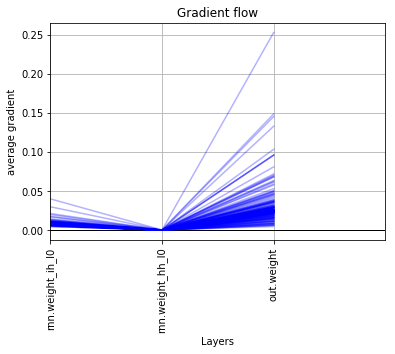

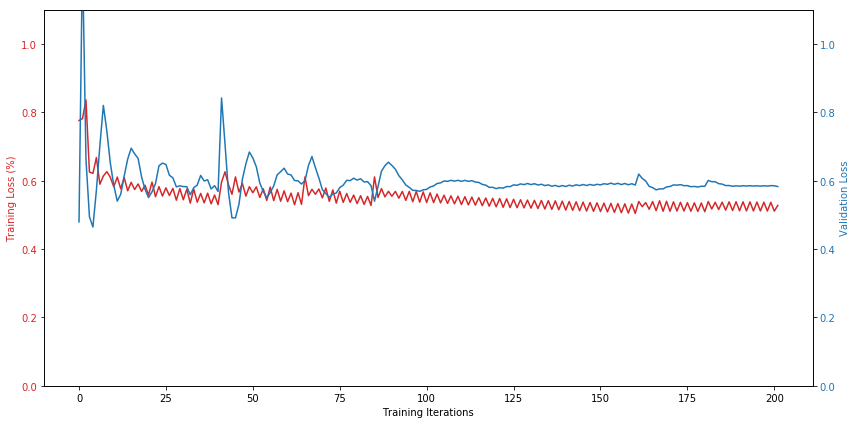

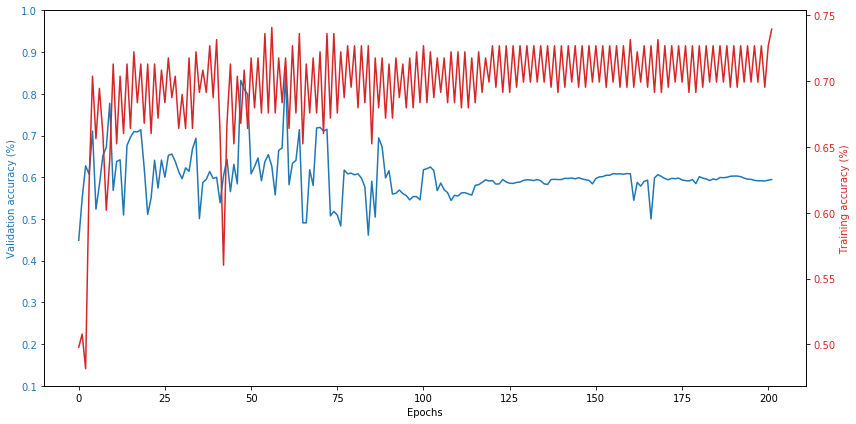

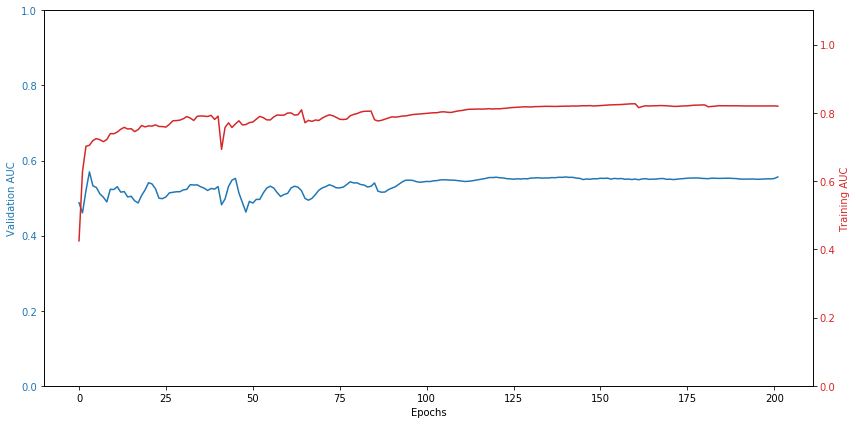

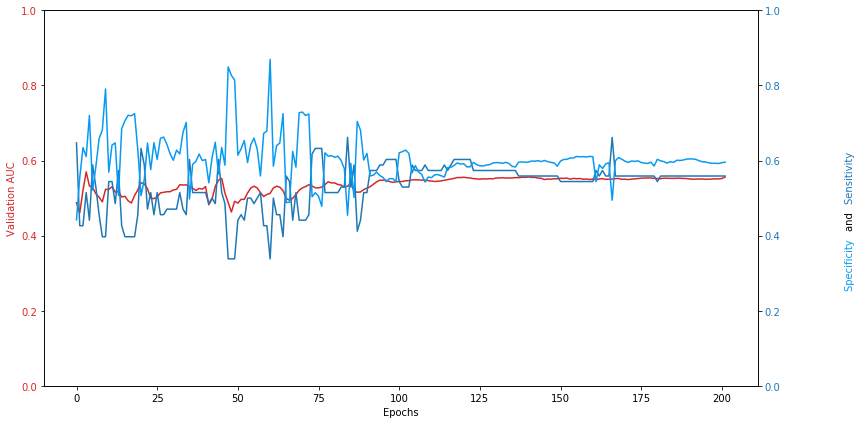


Fold  9
confused items in training set:  268
not_confused items in training set:  268
confused items in validation set:  56
not_confused items in validation set:  2388

Test confused items:

['103a_H-CDV-12-1.pkl', '103a_H-CDV-12-2.pkl', '103a_H-CDV-12-3.pkl', '103a_H-CDV-12-4.pkl', '103a_H-CDV-17-1.pkl', '103a_H-CDV-17-2.pkl', '103a_H-CDV-17-3.pkl', '103a_H-CDV-17-4.pkl', '11a_H-SortTwoFactors-5-1.pkl', '11a_H-SortTwoFactors-5-2.pkl', '11a_H-SortTwoFactors-5-3.pkl', '11a_H-SortTwoFactors-5-4.pkl', '143a_H-CDV-17-1.pkl', '143a_H-CDV-17-2.pkl', '143a_H-CDV-17-3.pkl', '143a_H-CDV-17-4.pkl']
Training data:  Dataset DatasetFolder
    Number of datapoints: 536
    Root Location: ./dataset/augmented/train3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Validation data:  Dataset DatasetFolder
    Number of datapoints: 2444
    Root Location: ./dataset/augmented/val3-1/
    Transforms (if any): None
    Target Transforms (if any): None
Test data:  Dataset DatasetFolder


[epoch: 15, batches:     1] loss: 0.58248 | accuracy: 0.64453
[epoch: 15, batches:     2] loss: 0.56820 | accuracy: 0.65625
[epoch: 15, batches:     3] loss: 0.58049 | accuracy: 0.70833
Training accuracy for epoch:  0.6697048611111112
validation accuracy:  0.4725859247135843
validation loss:  0.6628579914569854
validation recall:  0.6428571428571429
validation specificity:  0.4685929648241206
validation AUC:  0.5108840332615459
Epochs without improvement:  2
[epoch: 16, batches:     1] loss: 0.57522 | accuracy: 0.65234
[epoch: 16, batches:     2] loss: 0.57374 | accuracy: 0.66797
[epoch: 16, batches:     3] loss: 0.56165 | accuracy: 0.70833
Training accuracy for epoch:  0.6762152777777778
validation accuracy:  0.5675122749590835
validation loss:  0.5799710929393769
validation recall:  0.5892857142857143
validation specificity:  0.567001675041876
validation AUC:  0.5671287987556832
Epochs without improvement:  3
[epoch: 17, batches:     1] loss: 0.57116 | accuracy: 0.70703
[epoch: 17, b

Training accuracy for epoch:  0.71875
validation accuracy:  0.80810147299509
validation loss:  0.6440901011228561
validation recall:  0.4107142857142857
validation specificity:  0.8174204355108877
validation AUC:  0.5621896685810002
Epochs without improvement:  19
[epoch: 33, batches:     1] loss: 0.53263 | accuracy: 0.73828
[epoch: 33, batches:     2] loss: 0.52892 | accuracy: 0.69922
[epoch: 33, batches:     3] loss: 0.48436 | accuracy: 0.75000
Training accuracy for epoch:  0.7291666666666666
validation accuracy:  0.4897708674304419
validation loss:  0.6571355700492859
validation recall:  0.6428571428571429
validation specificity:  0.4861809045226131
validation AUC:  0.5572991445321847
No increase in validation AUC score in 10 epochs. Reducing learning rate.
Old learning rate: 0.00075
New learning rate: 0.000375
Validation AUC:  0.5753768844221105
Validation Loss:  0.5312134444713592
Epochs without improvement:  20
[epoch: 34, batches:     1] loss: 0.57120 | accuracy: 0.69141
[epoch:

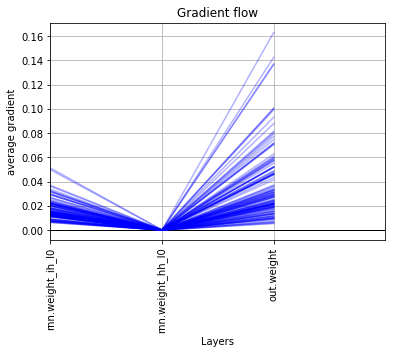

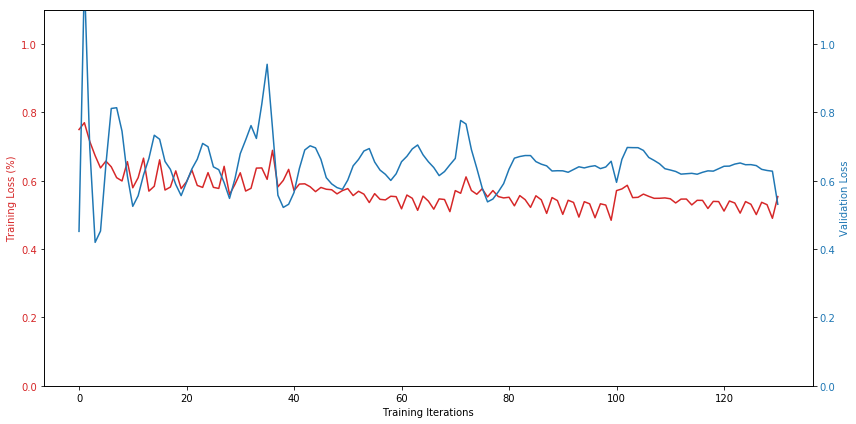

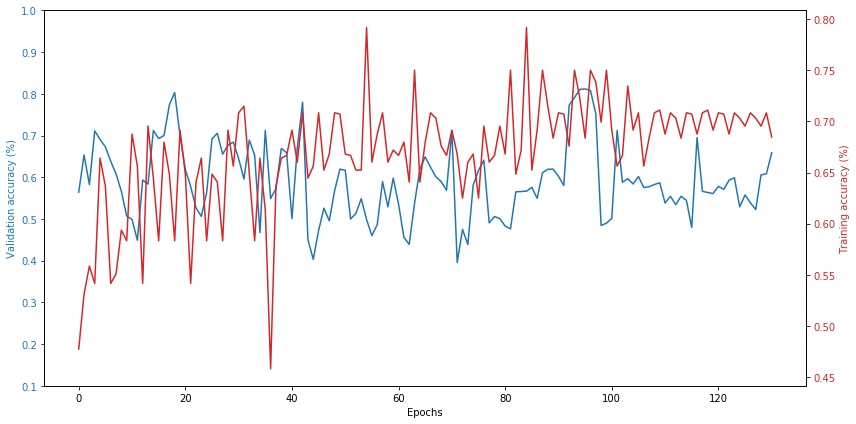

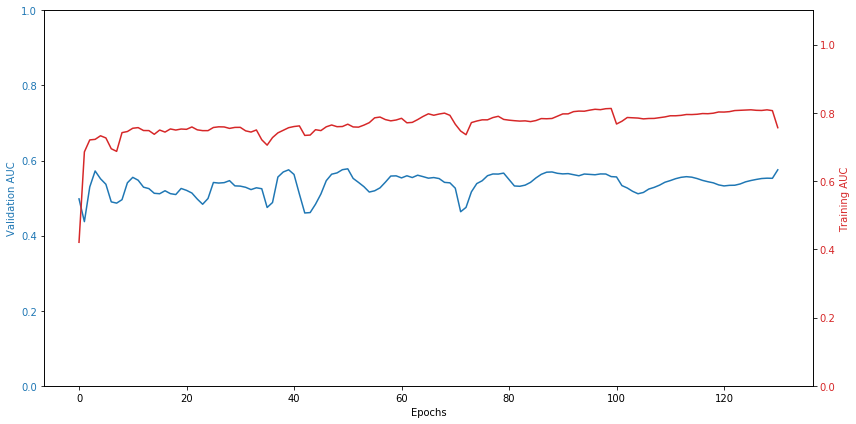

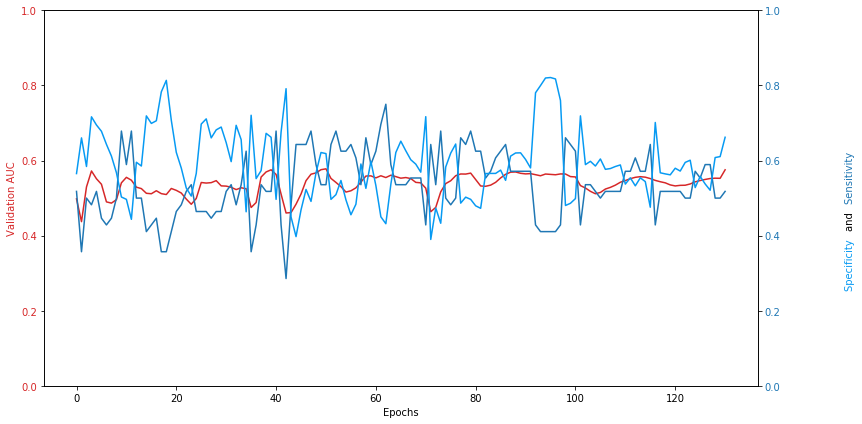


Fold  10
confused items in training set:  212
not_confused items in training set:  212
confused items in validation set:  76
not_confused items in validation set:  2300

Test confused items:

['112a_V-SortTwoFactors-5-1.pkl', '112a_V-SortTwoFactors-5-2.pkl', '112a_V-SortTwoFactors-5-3.pkl', '112a_V-SortTwoFactors-5-4.pkl', '114a_V-SortTwoFactors-12-1.pkl', '114a_V-SortTwoFactors-12-2.pkl', '114a_V-SortTwoFactors-12-3.pkl', '114a_V-SortTwoFactors-12-4.pkl', '130a_V-RV-10-1.pkl', '130a_V-RV-10-2.pkl', '130a_V-RV-10-3.pkl', '130a_V-RV-10-4.pkl', '35a_H-SortTwoFactors-15-1.pkl', '35a_H-SortTwoFactors-15-2.pkl', '35a_H-SortTwoFactors-15-3.pkl', '35a_H-SortTwoFactors-15-4.pkl', '35a_H-SortTwoFactors-22-1.pkl', '35a_H-SortTwoFactors-22-2.pkl', '35a_H-SortTwoFactors-22-3.pkl', '35a_H-SortTwoFactors-22-4.pkl', '35a_H-SortTwoFactors-4-1.pkl', '35a_H-SortTwoFactors-4-2.pkl', '35a_H-SortTwoFactors-4-3.pkl', '35a_H-SortTwoFactors-4-4.pkl', '39a_H-SortTwoFactors-10-1.pkl', '39a_H-SortTwoFactors-10-

Validation AUC:  0.6265961098398168
Validation Loss:  0.7824910819530487
Epochs without improvement:  10
[epoch: 14, batches:     1] loss: 0.64529 | accuracy: 0.61719
[epoch: 14, batches:     2] loss: 0.65475 | accuracy: 0.61310
Training accuracy for epoch:  0.6151413690476191
validation accuracy:  0.6182659932659933
validation loss:  0.577311584353447
validation recall:  0.618421052631579
validation specificity:  0.6182608695652174
validation AUC:  0.5968249427917619
Epochs without improvement:  11
[epoch: 15, batches:     1] loss: 0.64213 | accuracy: 0.60547
[epoch: 15, batches:     2] loss: 0.64329 | accuracy: 0.61905
Training accuracy for epoch:  0.6122581845238095
validation accuracy:  0.6254208754208754
validation loss:  0.7358391940593719
validation recall:  0.5921052631578947
validation specificity:  0.6265217391304347
validation AUC:  0.5888901601830664
Epochs without improvement:  12
[epoch: 16, batches:     1] loss: 0.62502 | accuracy: 0.59375
[epoch: 16, batches:     2] los

validation accuracy:  0.7192760942760943
validation loss:  0.7824910819530487
validation recall:  0.631578947368421
validation specificity:  0.7221739130434782
validation AUC:  0.6265961098398168


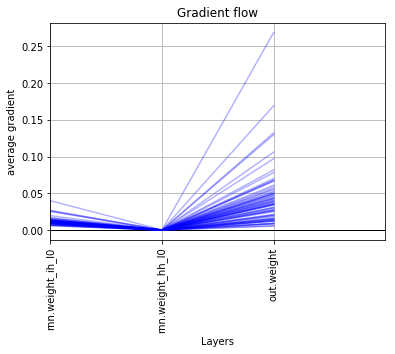

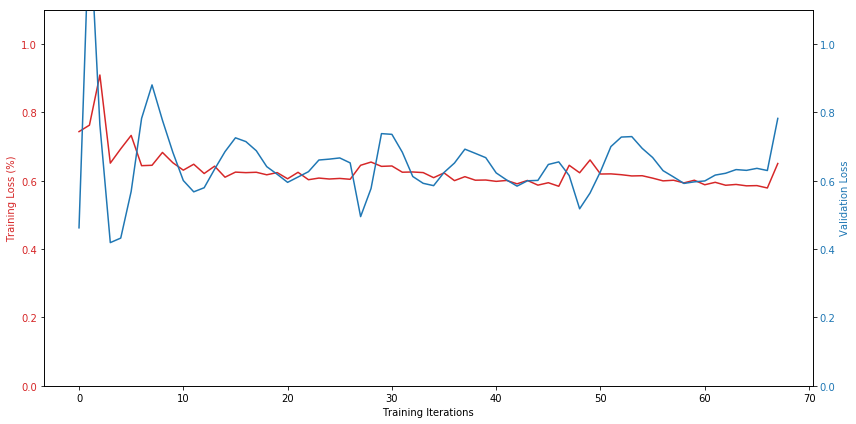

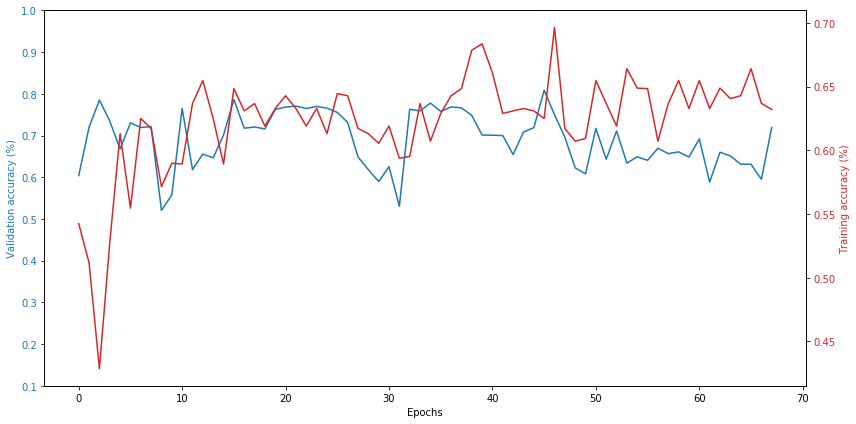

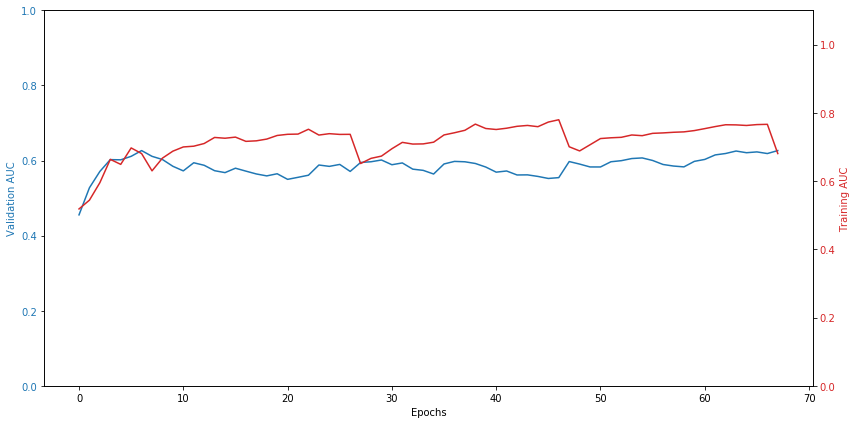

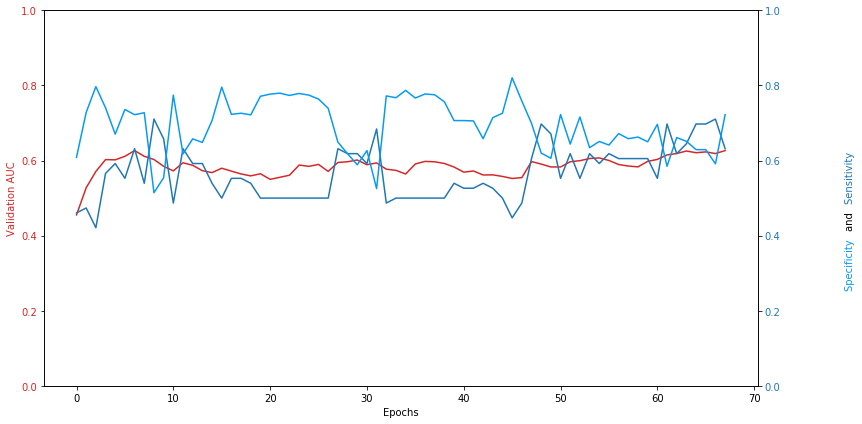


10-fold CV accuracy: 0.700932
10-fold CV sensitivity: 0.600168 
10-fold CV specificity: 0.704266 
10-fold CV AUC: 0.634462 

10-fold test accuracy: 0.733565
10-fold test sensitivity: 0.590656 
10-fold test specificity: 0.737777 
10-fold test AUC: 0.616629 


([0.6086762075134168,
  0.7698347107438016,
  0.7517331022530329,
  0.6038062283737025,
  0.6492146596858639,
  0.8656583629893239,
  0.7878787878787878,
  0.594488188976378,
  0.6587561374795418,
  0.7192760942760943],
 [0.578125,
  0.6190476190476191,
  0.609375,
  0.6029411764705882,
  0.6875,
  0.5714285714285714,
  0.625,
  0.5588235294117647,
  0.5178571428571429,
  0.631578947368421],
 [0.6095764272559853,
  0.7752568493150684,
  0.7557932263814616,
  0.6038324420677362,
  0.6475409836065574,
  0.8770794824399261,
  0.7936274509803921,
  0.5957230142566191,
  0.6620603015075377,
  0.7221739130434782],
 [0.5309046961325967,
  0.7060655169602087,
  0.6606993649732619,
  0.6037734612561603,
  0.6612093010018215,
  0.7121072088724584,
  0.7116217320261439,
  0.5562702168443753,
  0.5753768844221105,
  0.6265961098398168],
 [0.9361370716510904,
  0.6448598130841121,
  0.6378504672897196,
  0.7336448598130841,
  0.4797507788161994,
  0.8097826086956522,
  0.7920560747663551,
  0.59423

In [11]:
# monitoring validation AUC
np.random.seed(MANUAL_SEED)
random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

cross_validate(model_type='rnn',
                   folds=10,
                   epochs=300,
                   criterion_type='NLLLoss',
                   optimizer_type='Adam',
                   confused_path='./dataset/augmented/confused_highly_valid/',
                   not_confused_path='./dataset/augmented/not_confused_highly_valid/',
                   print_every=1,
                   plot_every=1,
                   hidden_size=HIDDEN_SIZE,
                   num_layers=1,
                   early_stopping=True,
                   early_stopping_metric='val_auc',
                   early_stopping_patience=30,
                   rate_decay=True,
                   rate_decay_patience=10,
                   initial_learning_rate=0.003,
                   verbose=True)